In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
data_folder = "data"
years = [str(i) for i in range(2006, 2015)]

classes_30 = ["Asterionellopsis", "bad", "Chaetoceros", "Chaetoceros_flagellate", "Ciliate_mix", "Corethron", "Cylindrotheca", "Dictyocha","dino30", "detritus",
	"Dinobryon", "Ditylum", "Eucampia", "flagellate_sp3", "Guinardia_delicatula", "Guinardia_flaccida", "Guinardia_striata", "Heterocapsa_triquetra", "Laboea_strobila", "Leptocylindrus",
	"pennate", "Phaeocystis", "Pleurosigma", "Prorocentrum", "Pseudonitzschia", "Skeletonema", "Thalassionema", "Thalassiosira", "Thalassiosira_dirty", "Tintinnid"]

#another approach is to get all classes and get its stats
all_classes = [name for name in os.listdir(data_folder+"/"+years[0]) if os.path.isdir(data_folder+"/"+years[0]+"/"+name)]

class_stats = {c_name:{ year:[0] for year in years} for c_name in classes_30}

image_files = []
for year in years:
    data_path = data_folder+"/"+year

    if os.path.isdir(data_path):
        non_hab_causing = [0]
        for class_name in os.listdir(data_path):
            if class_name not in classes_30:
                continue
            c_path = data_path + "/"+class_name


            if os.path.isdir(c_path):
                image_files.extend([ [class_name] + [y for y in x.split("_")] for x in os.listdir(c_path) if ".png" in x])
classes_df = pd.DataFrame(image_files, columns = ["class", "IFCB", "year", "day", "time", "order"])

#print(classes_df)



In [7]:
y = classes_df.groupby(['class', 'year', 'day', 'time']).agg(['count']).reset_index()
y.index = pd.to_datetime(y.year +'-' +y.day +" "+ y.time, format='%Y-%j %H%M%S')


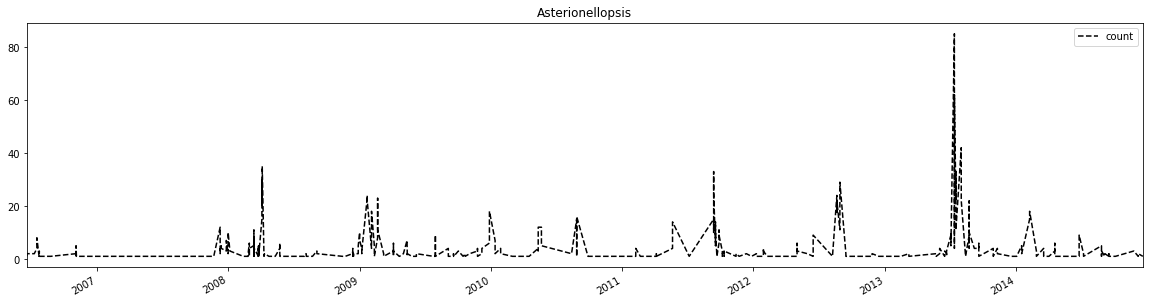

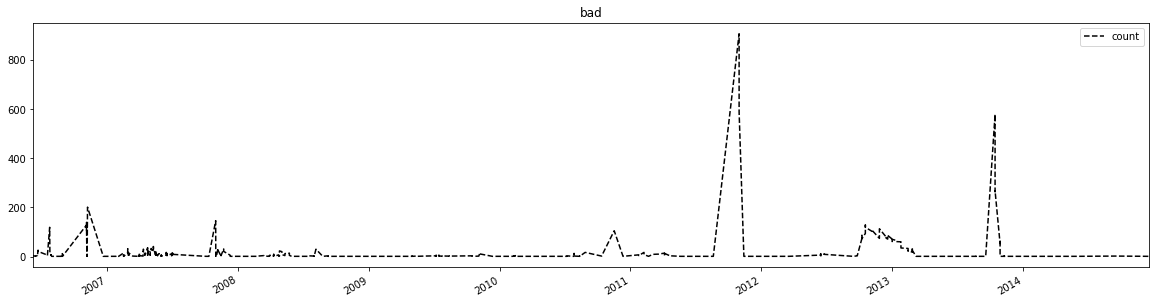

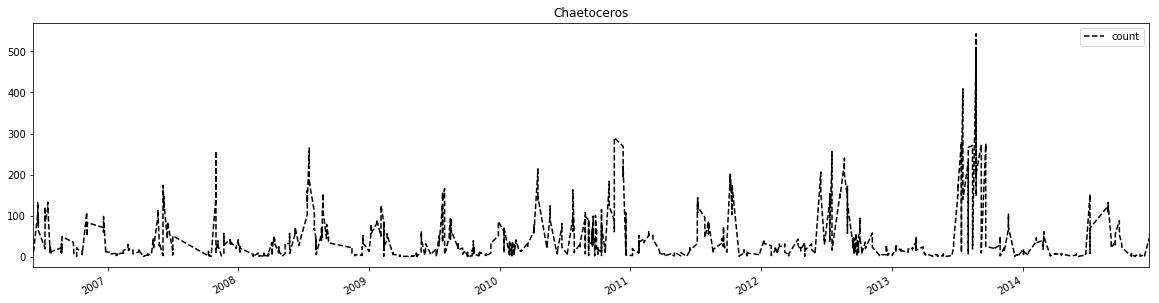

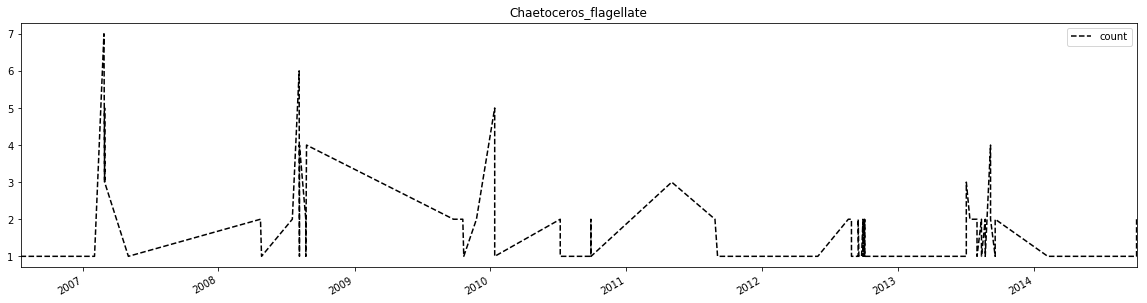

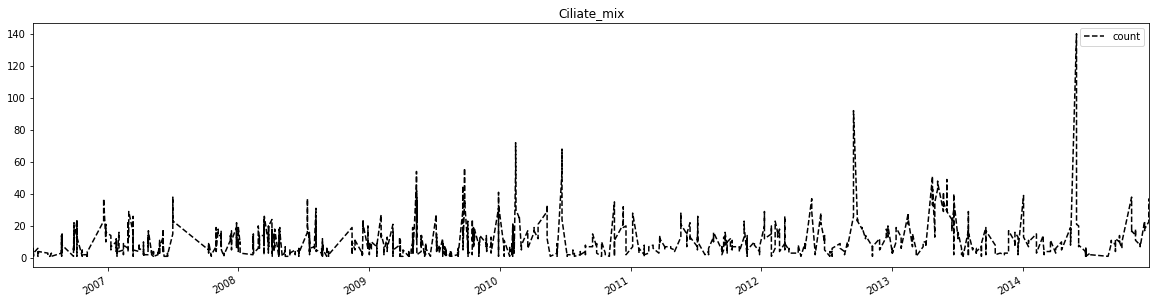

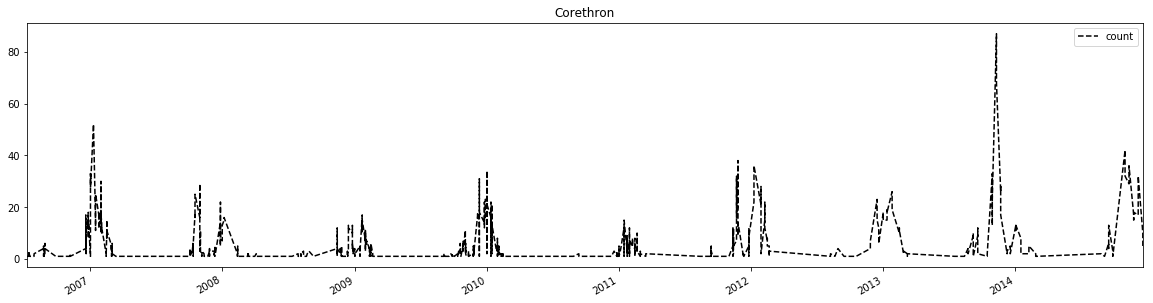

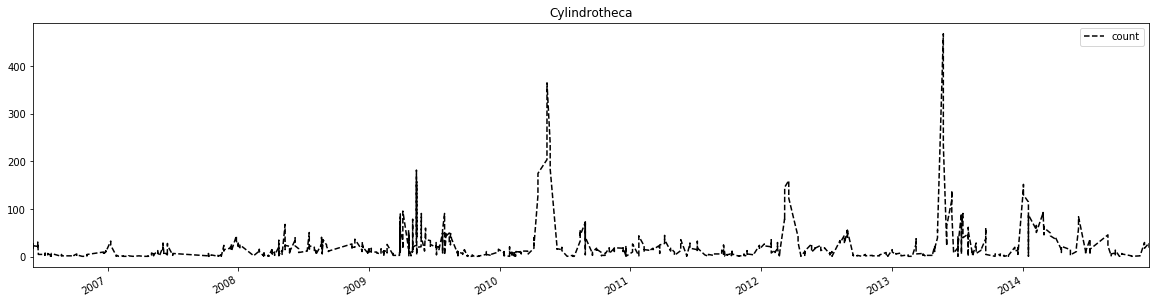

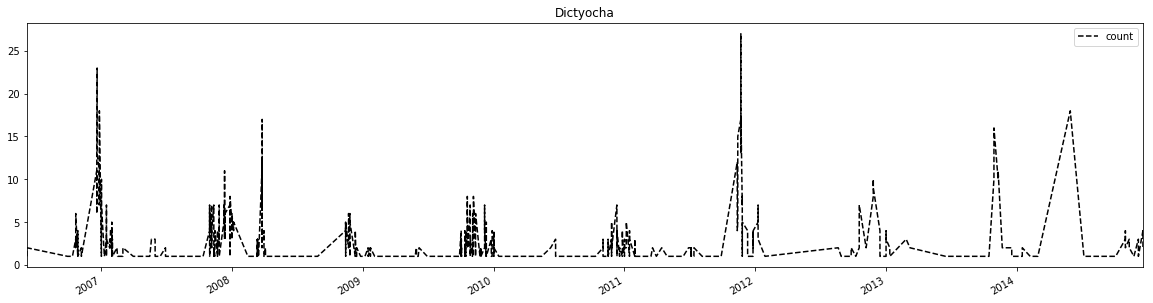

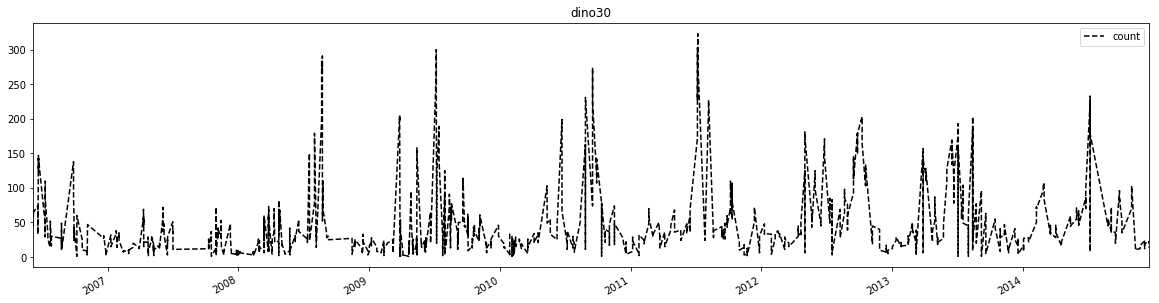

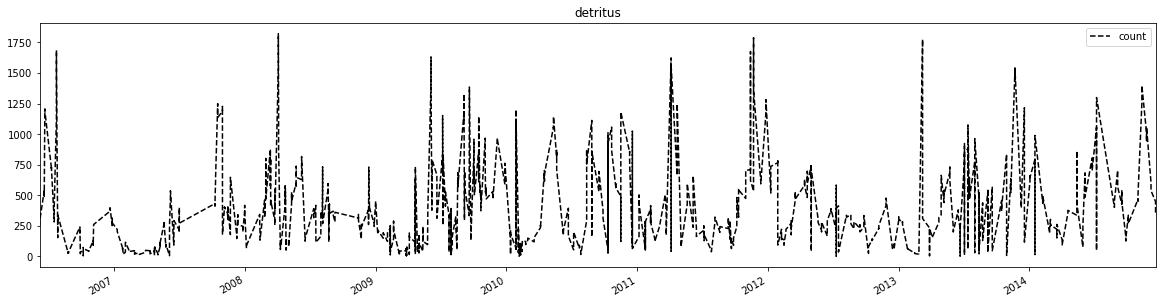

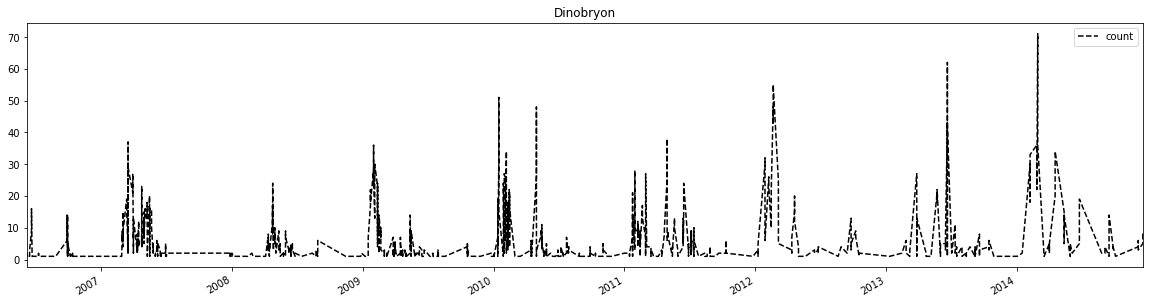

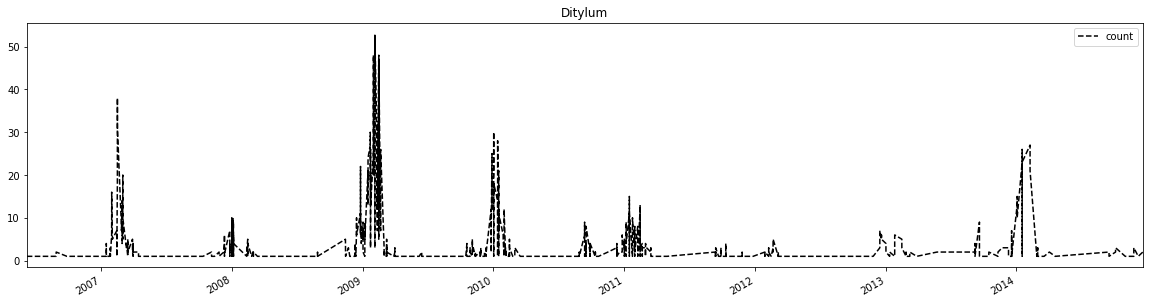

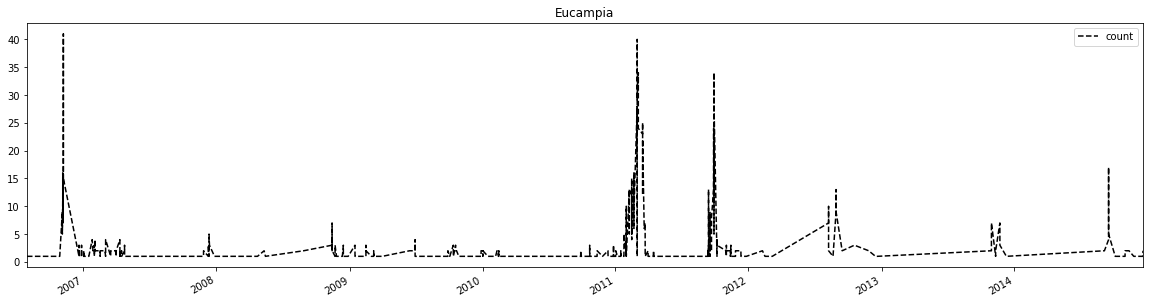

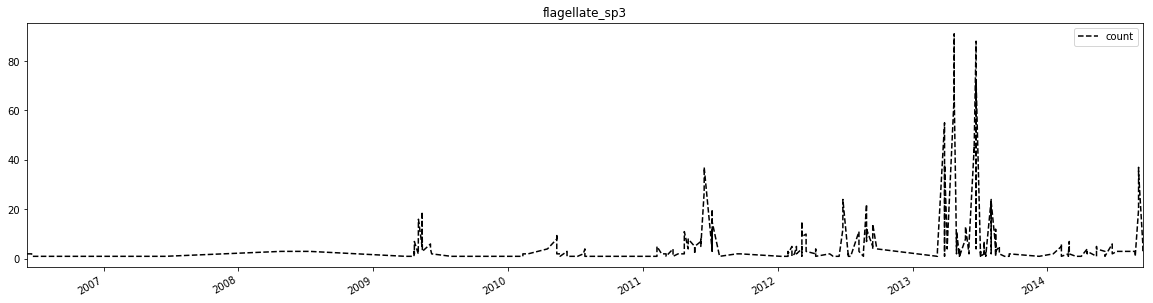

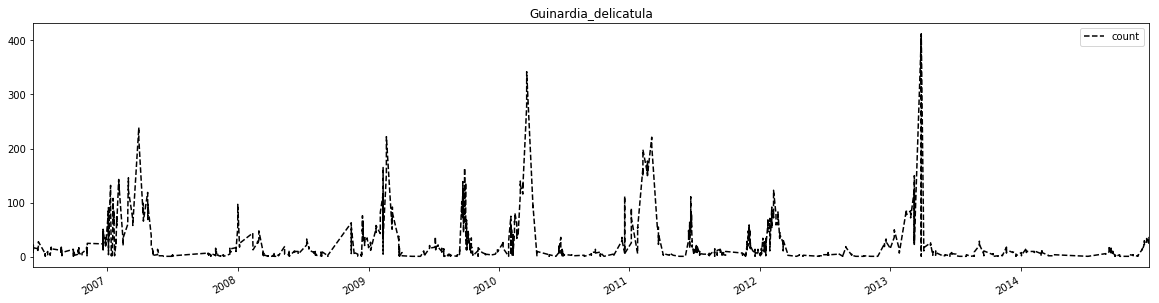

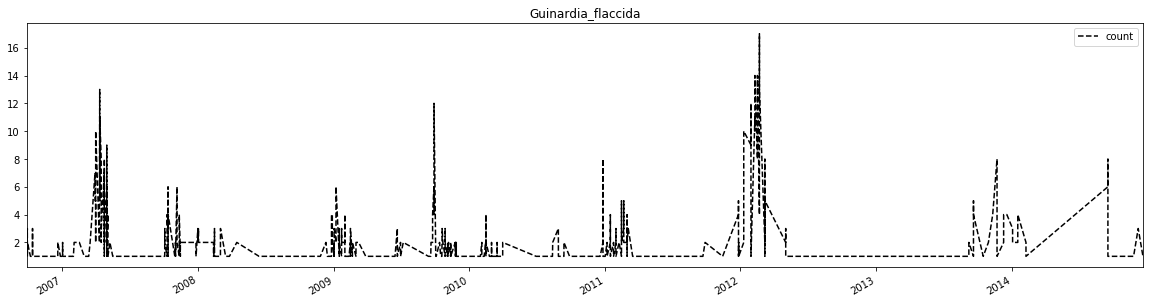

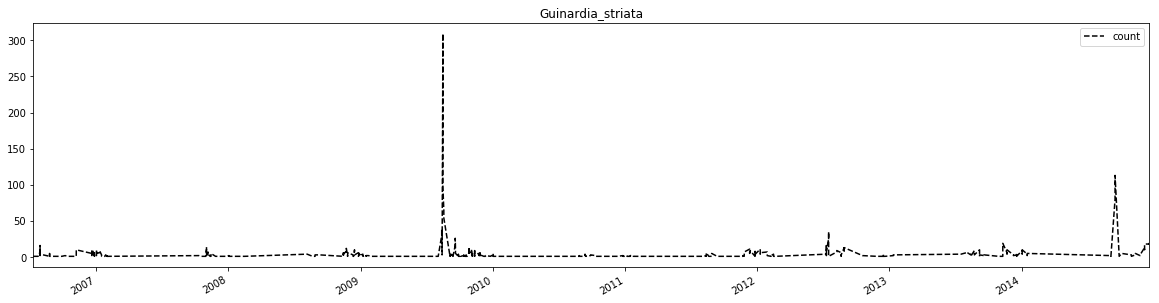

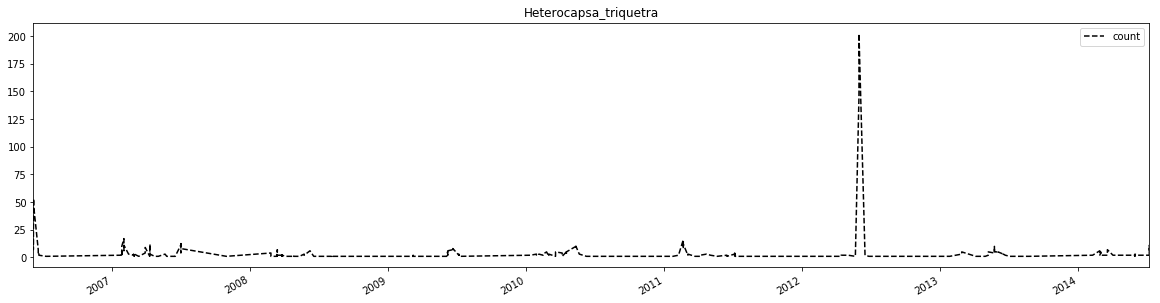

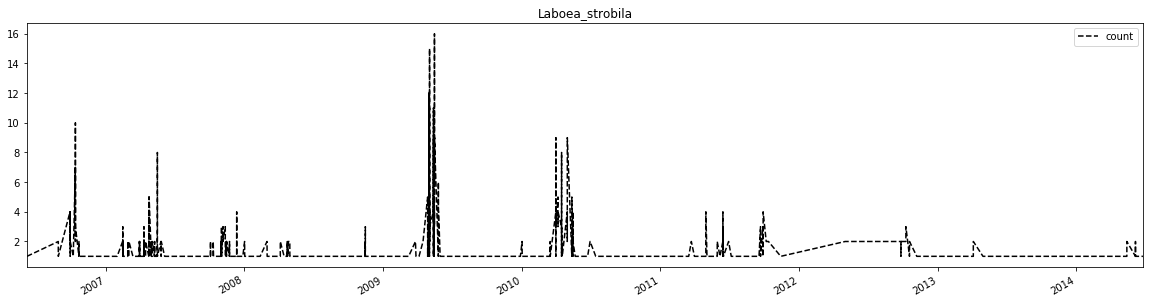

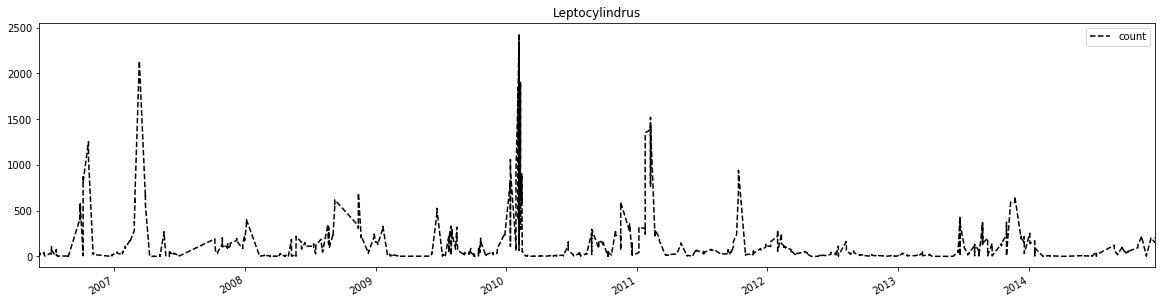

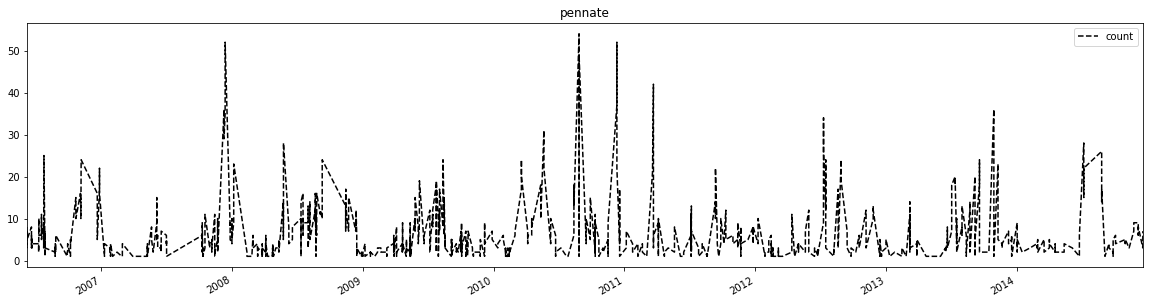

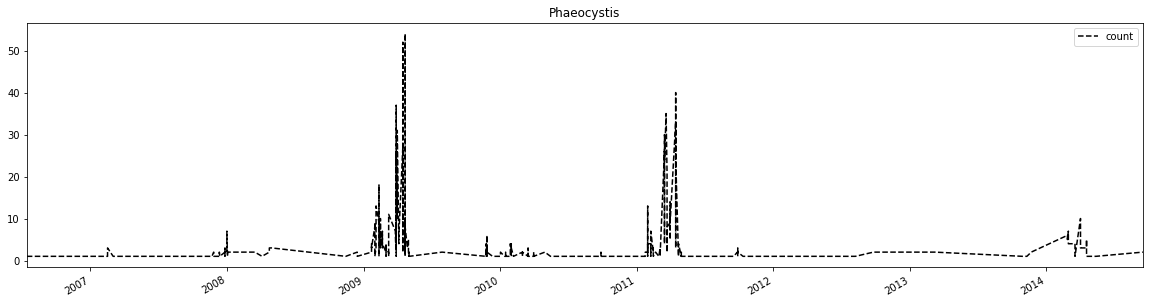

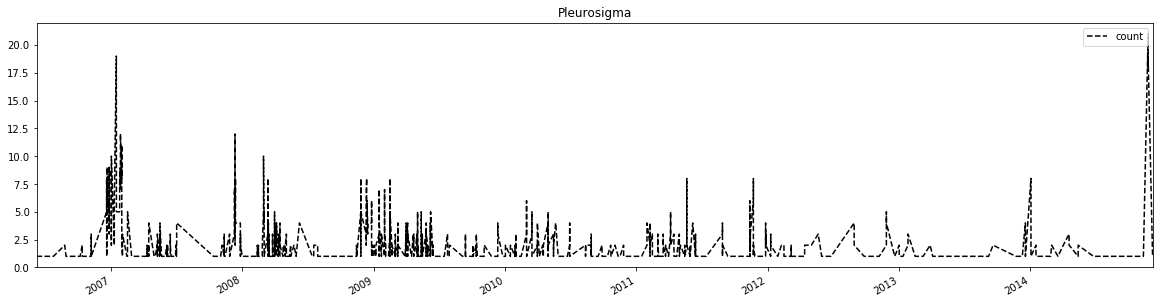

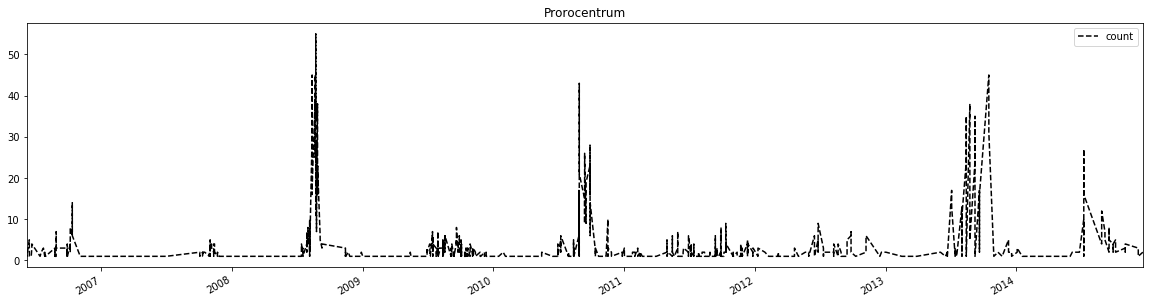

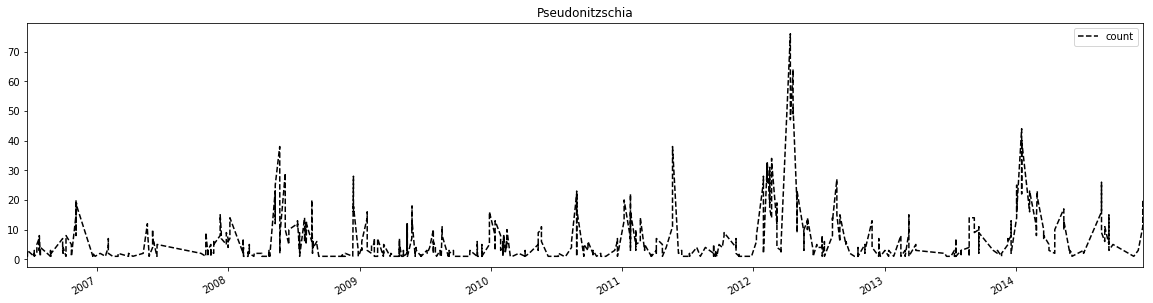

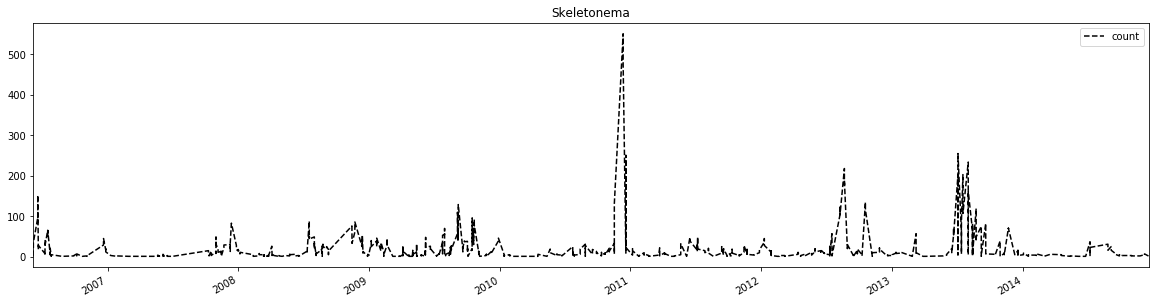

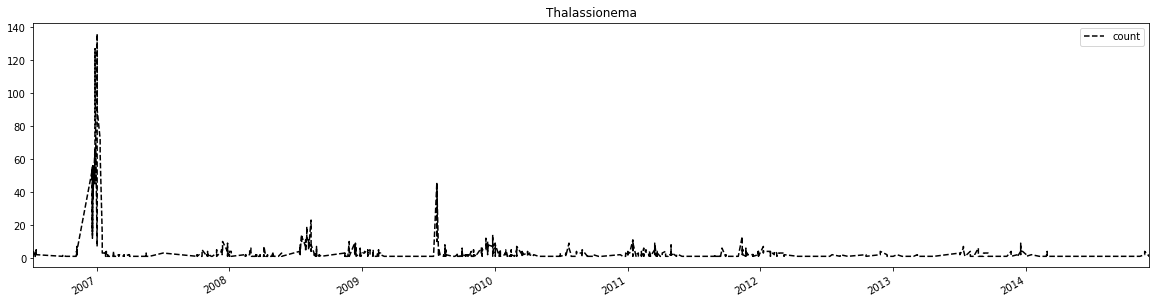

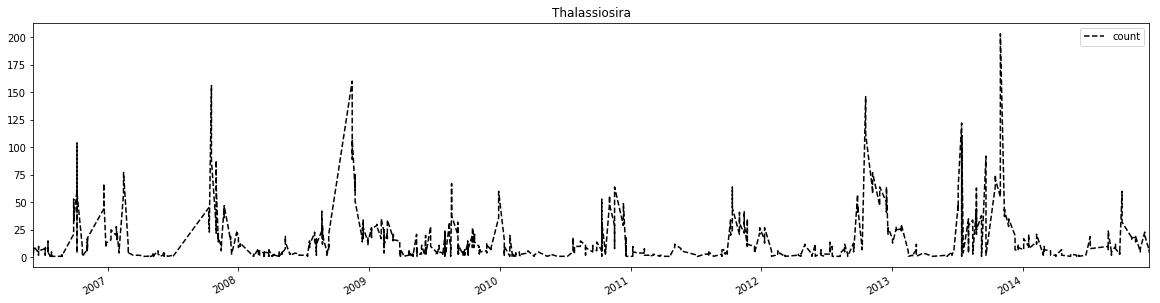

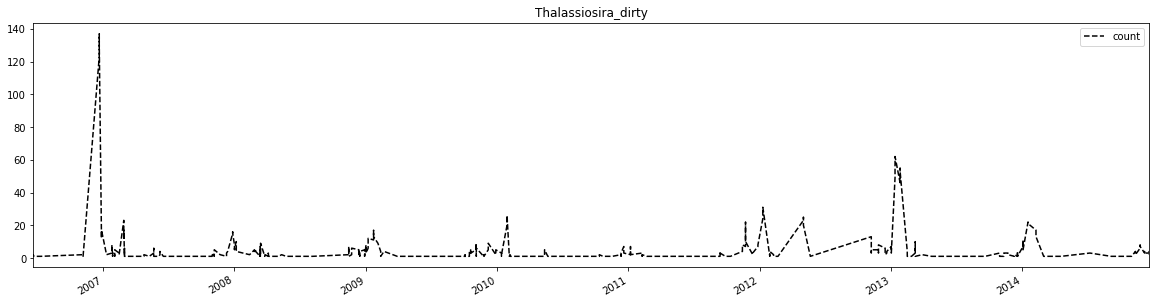

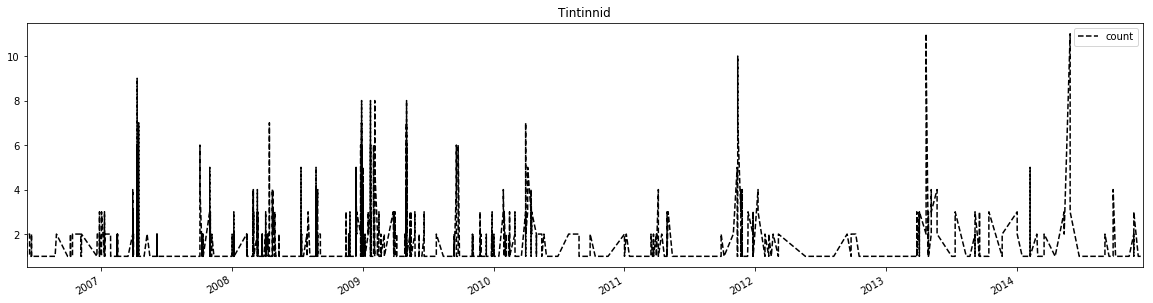

In [8]:
plt.rcParams['figure.figsize'] = [20, 5]
for c_name in classes_30:
    c = y.loc[y['class'] == c_name]
    c.plot(y='order', style='k--')
    plt.title(c_name)
    plt.show()
    

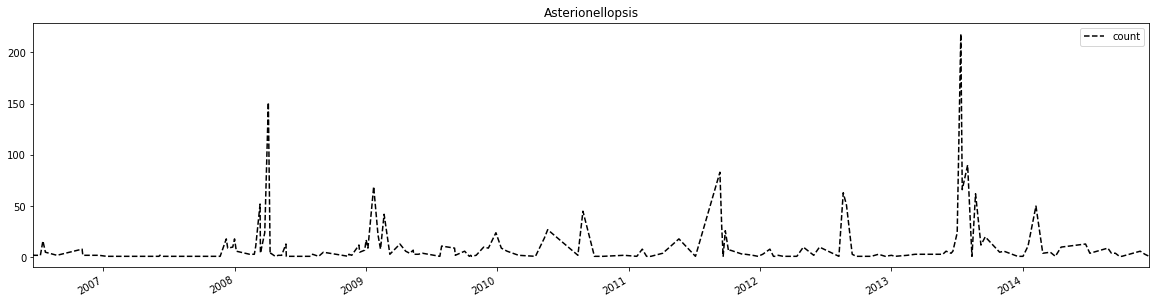

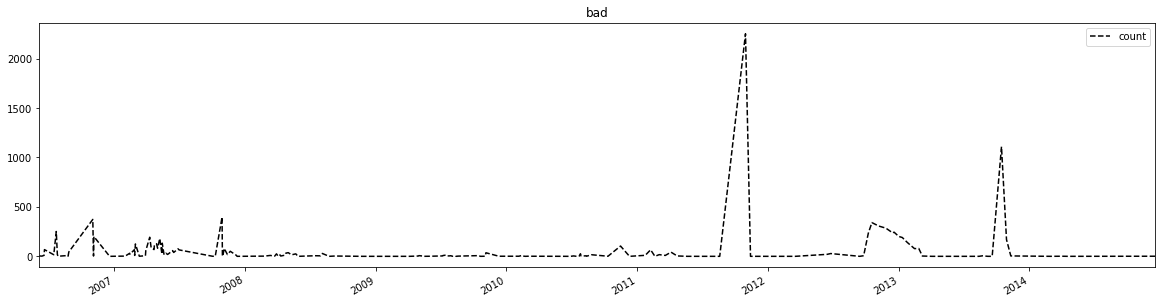

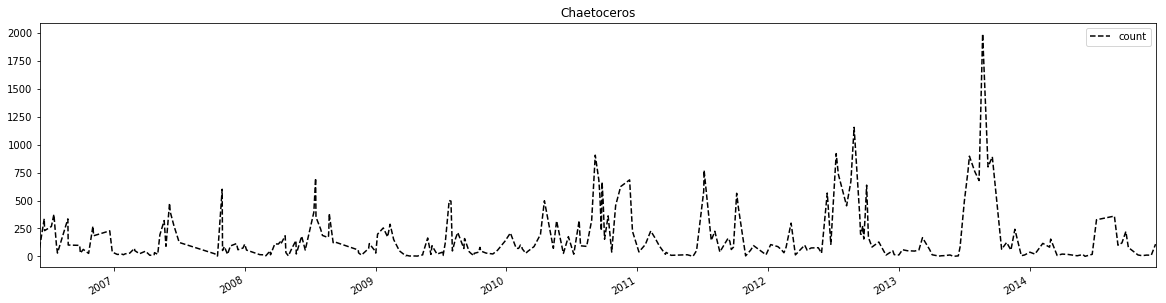

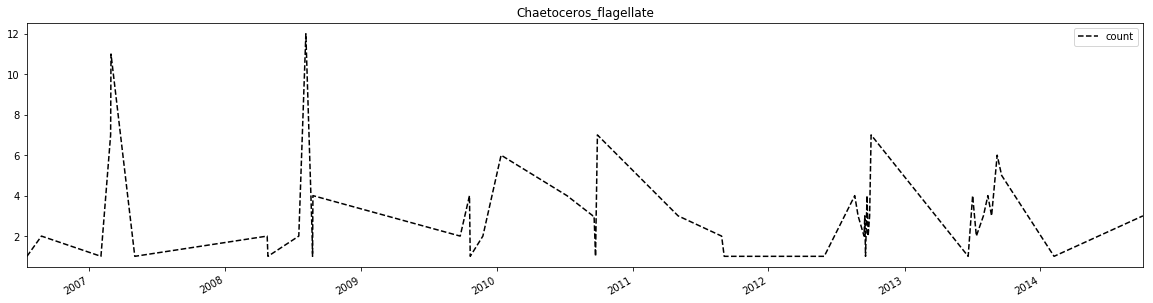

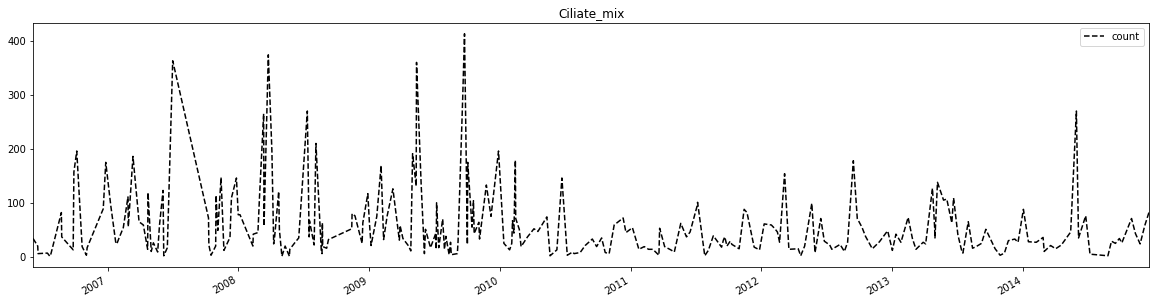

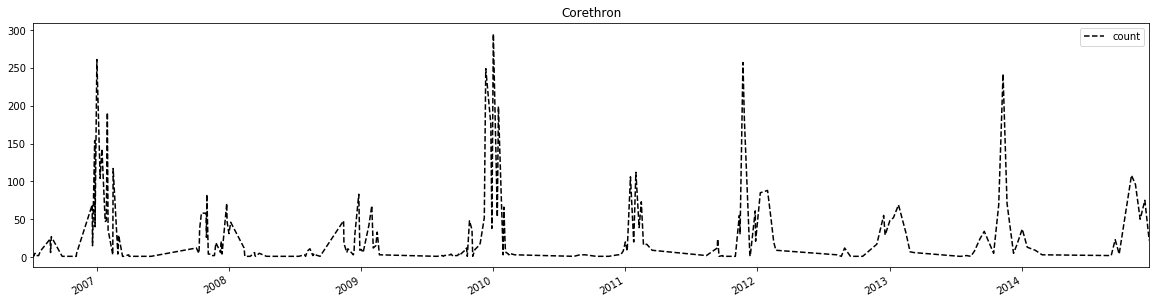

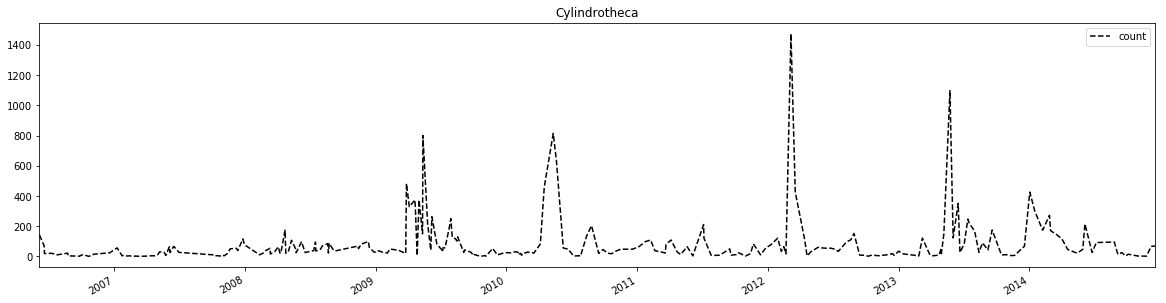

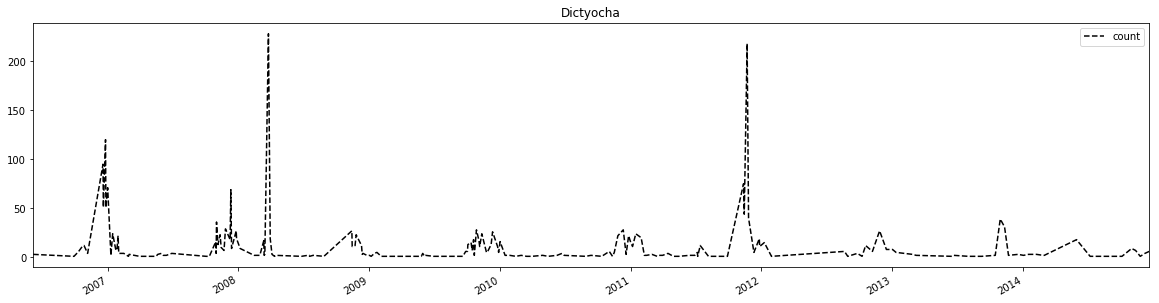

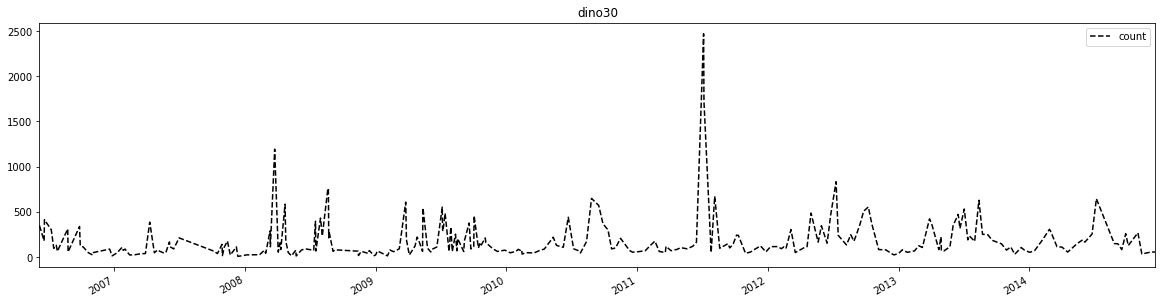

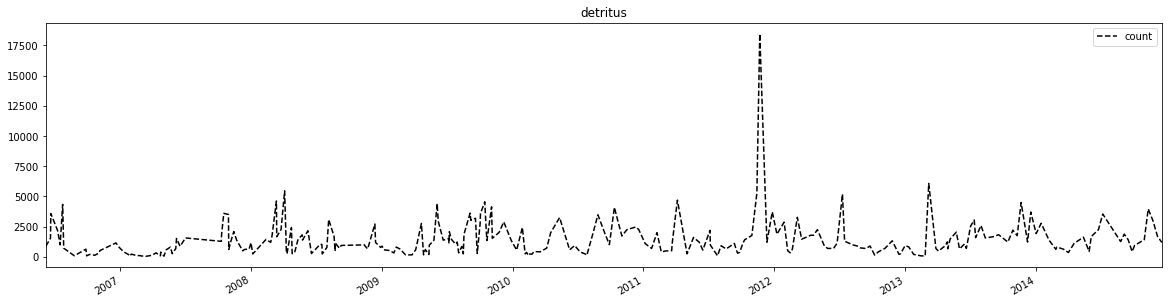

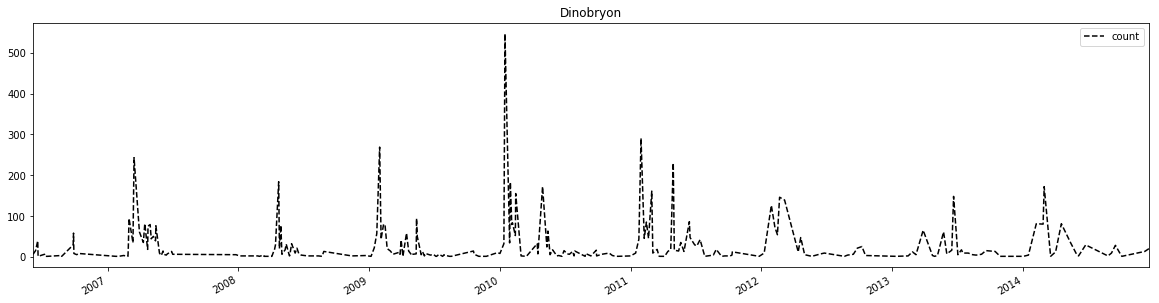

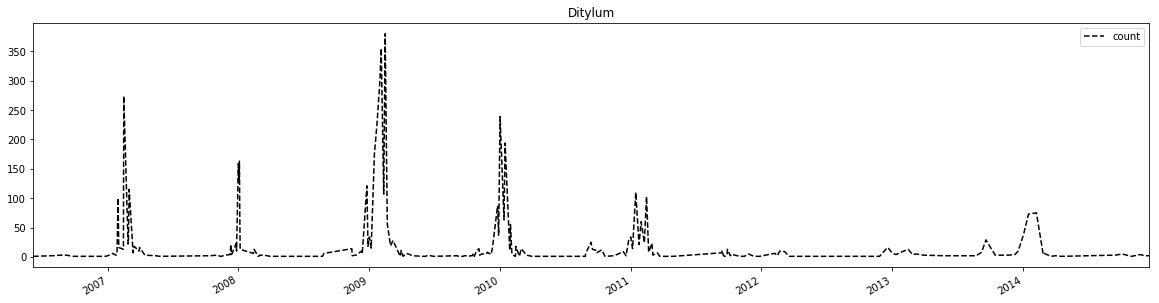

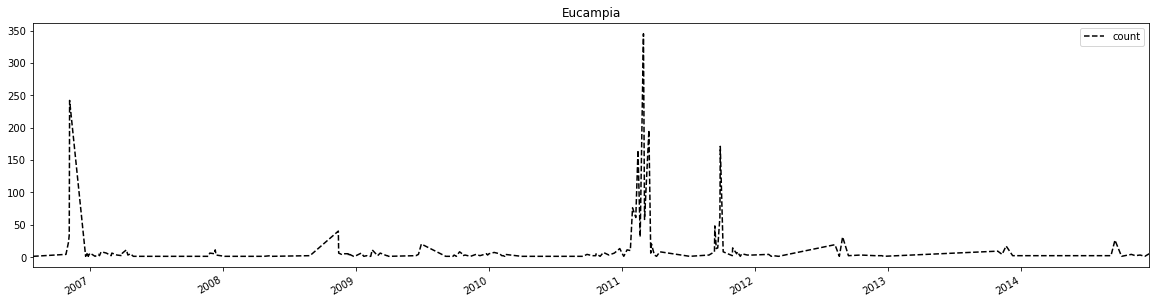

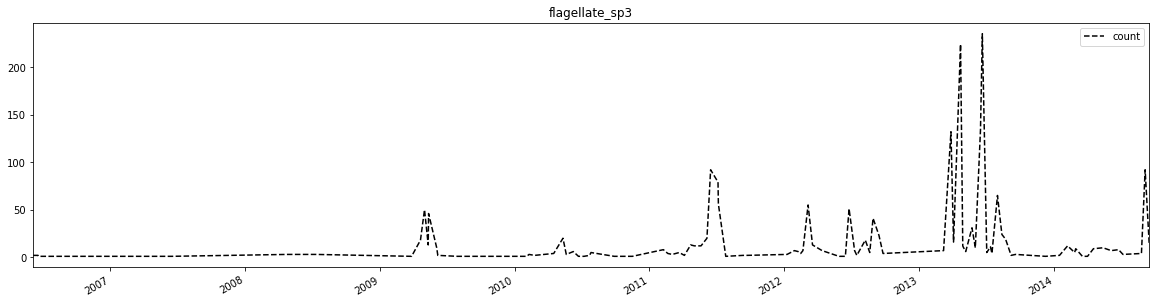

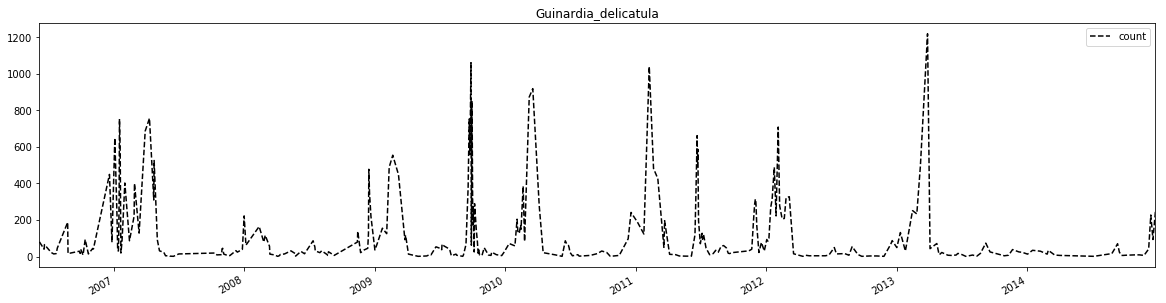

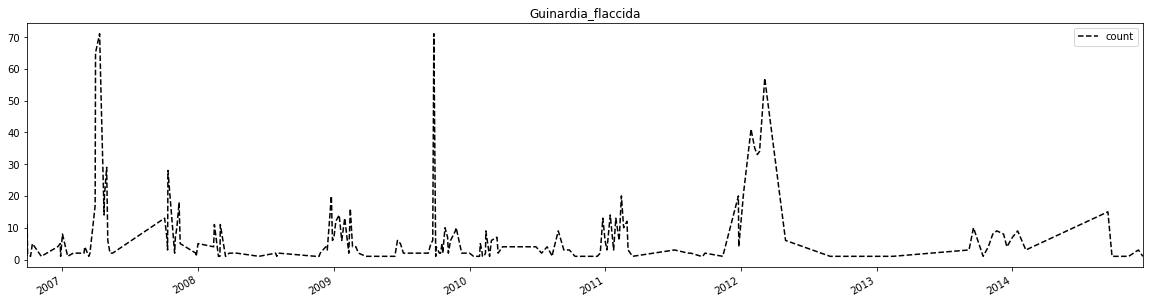

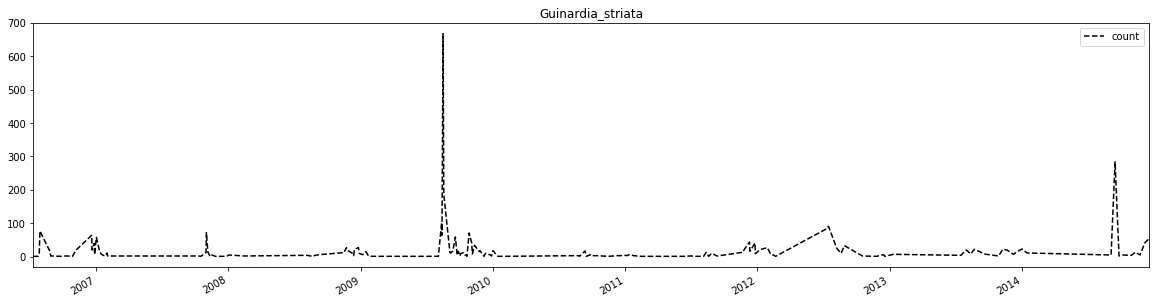

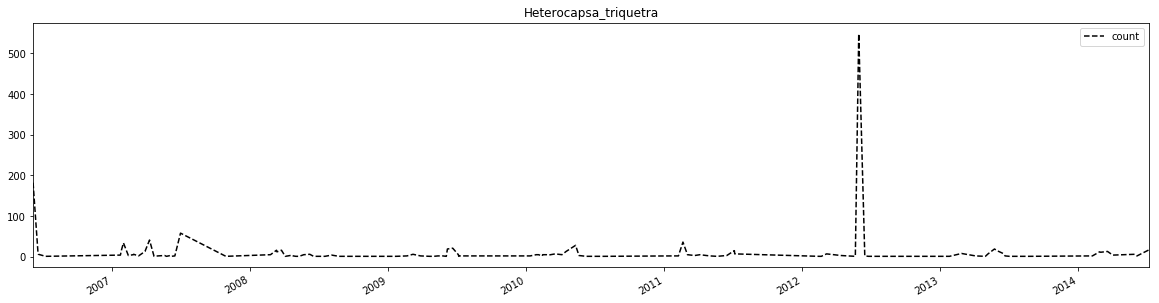

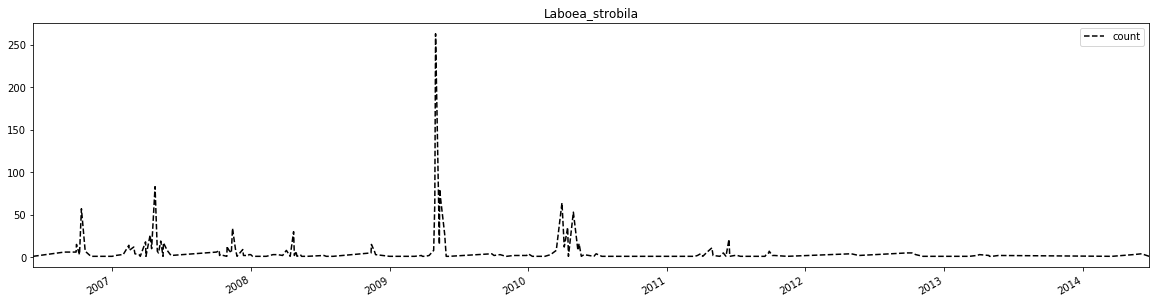

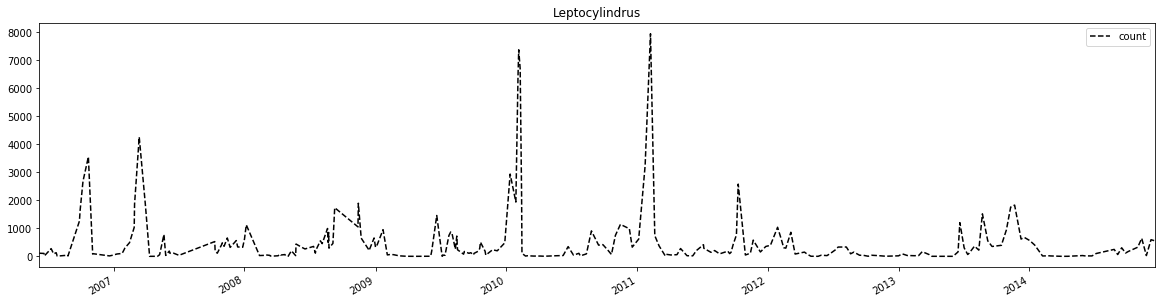

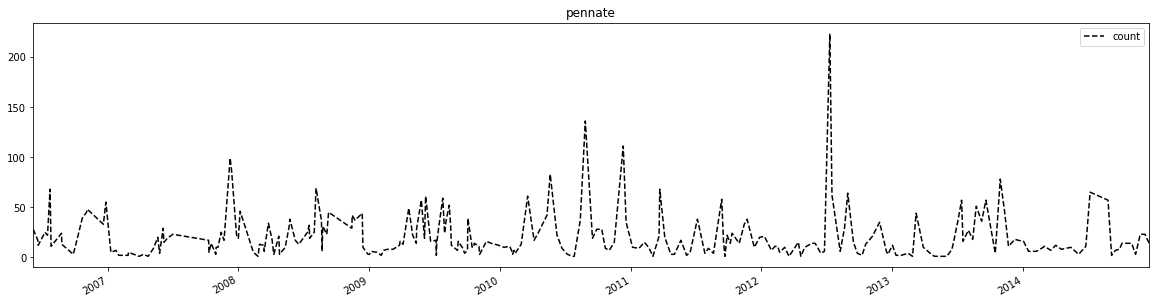

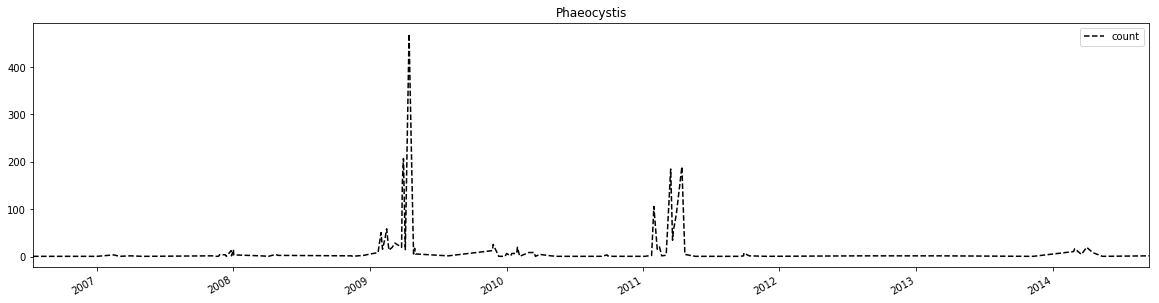

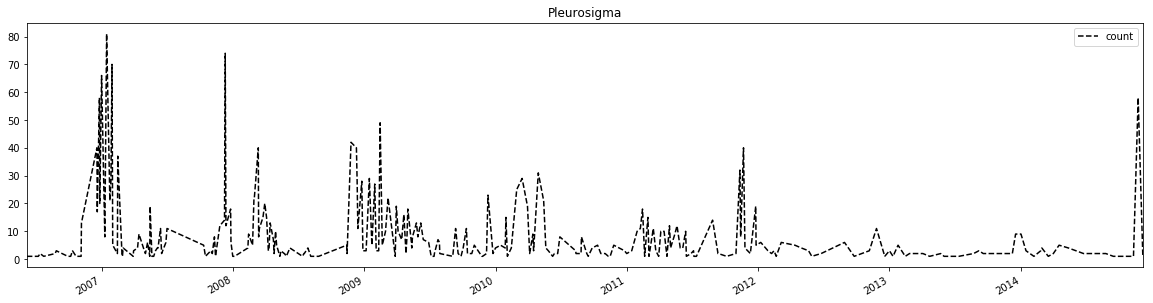

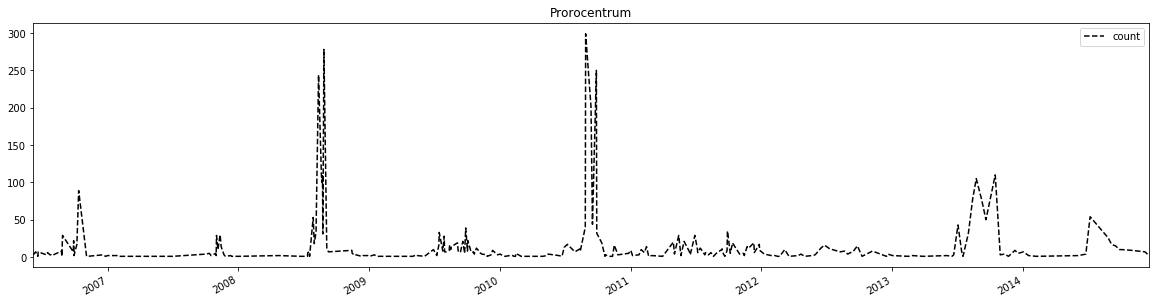

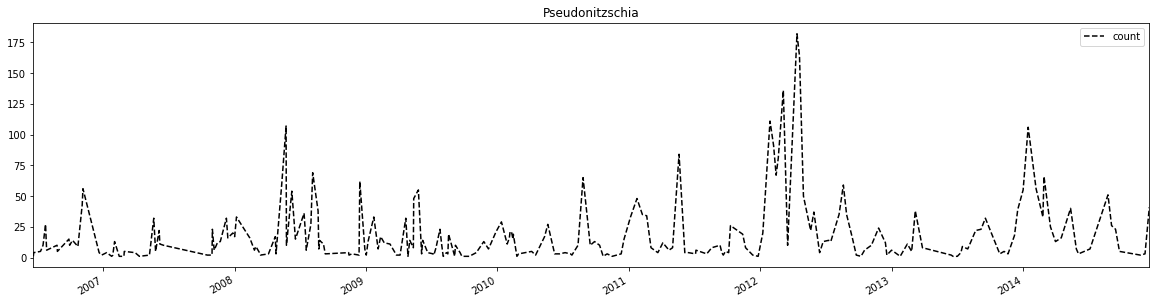

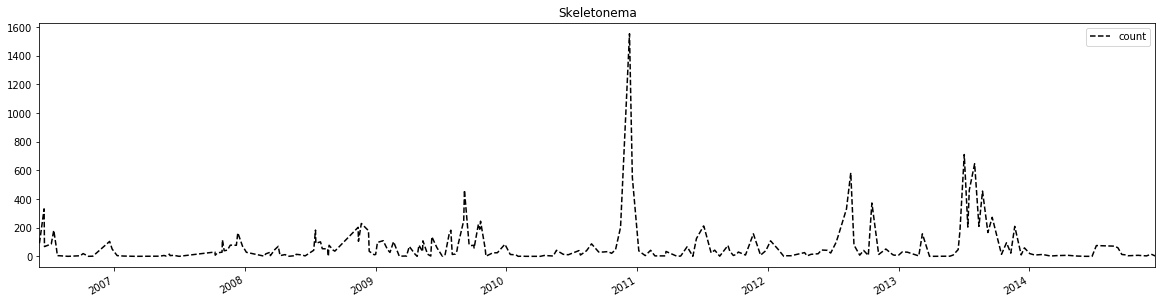

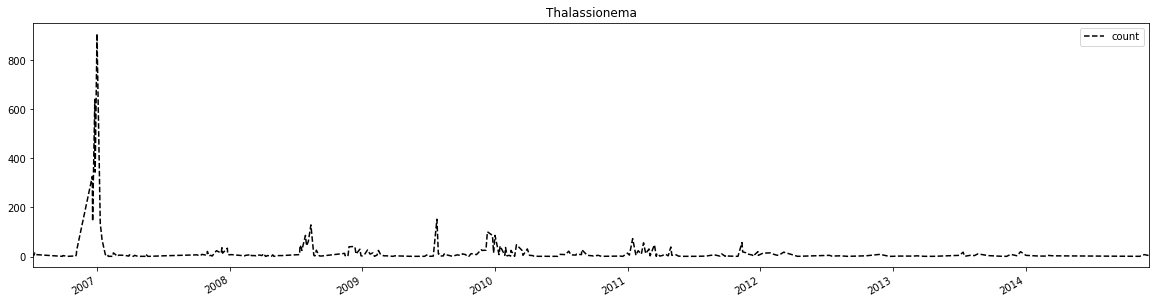

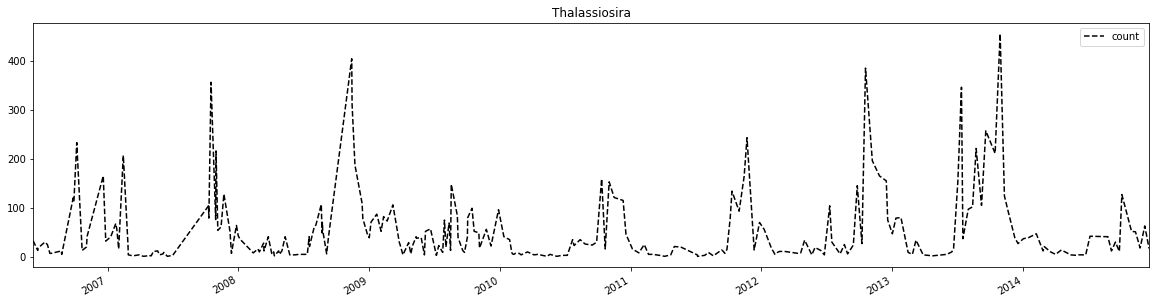

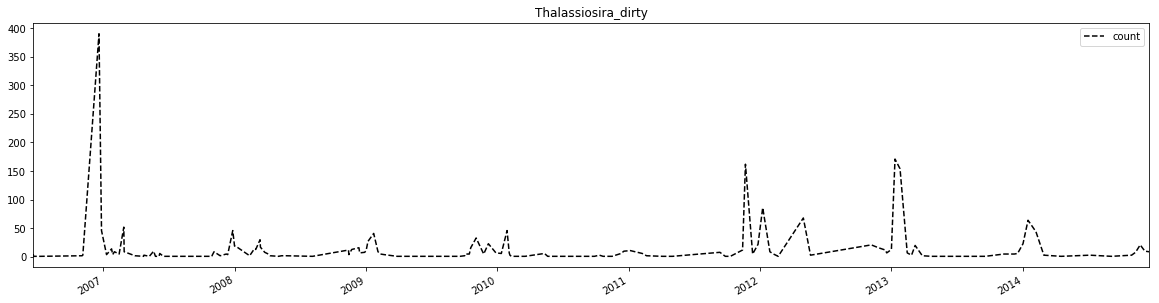

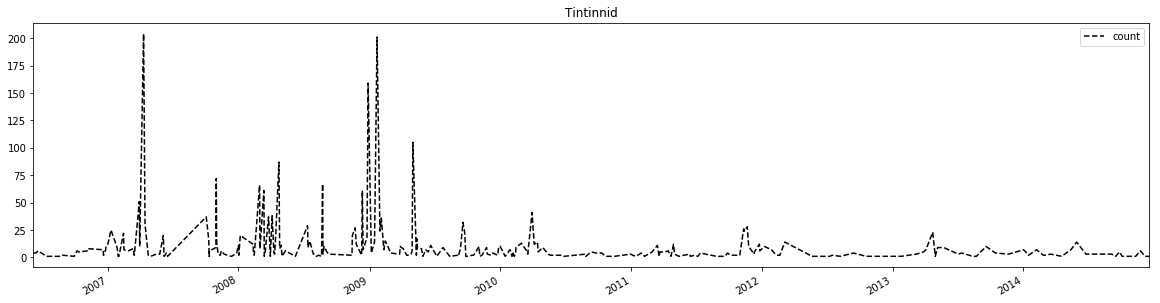

In [20]:
y_day = classes_df.groupby(['class', 'year', 'day']).agg(['count']).reset_index()
y_day.index = pd.to_datetime(y_day.year +'-' +y_day.day, format='%Y-%j')

plt.rcParams['figure.figsize'] = [20, 5]
for c_name in classes_30:
    c = y_day.loc[y_day['class'] == c_name]
    c.plot(y='order', style='k--')
    plt.title(c_name)
    plt.show()

In [23]:
# getting the different IFCB numbers:
ifcbs = classes_df['IFCB'].unique()
for ifcb in ifcbs:
    ind = classes_df['IFCB']==ifcb
    print(ifcb+":", len(classes_df[ind]))

IFCB1: 486380
IFCB5: 291275


In [10]:
# automatically fix the ifcb files
folder = "data/ifcb-raw"
entire_df = None
for f_name in os.listdir(folder):
    f_path = folder+"/"+f_name
    if entire_df is None:
        entire_df = pd.read_csv(f_path)
        entire_df["classified"] = entire_df.loc[:, entire_df.columns != "pid"].idxmax(axis=1)
        entire_df["prob"] = entire_df.max(axis=1)
        to_drop = entire_df.columns.drop(["pid", "classified", "prob"])
        entire_df = entire_df.drop(to_drop, axis=1)
        print("og_df shape:", entire_df.shape)
    else:
        temp_df = pd.read_csv(f_path)
        
        # check if temp_df has headers
        if "pid" not in temp_df.columns.values:
            print(f_name)
            print(temp_df[:1])
            print(f_name)
            continue
        # cleaning up df
        temp_df["classified"] = temp_df.select_dtypes(include="number").idxmax(axis=1)
        temp_df["prob"] = entire_df.max(axis=1)
        to_drop = temp_df.columns.drop(["pid", "classified", "prob"])
        temp_df = temp_df.drop(to_drop, axis=1)
        
        # adding dfs
        entire_df, temp_df = entire_df.align(temp_df, join='outer', axis=1)
        entire_df = entire_df.append(temp_df, ignore_index = True) 
        print("new_df shape:", entire_df.shape)

entire_df.to_csv("cleaned_ifcb.csv", index=False, header=True)

og_df shape: (3814, 3)
new_df shape: (8767, 3)
new_df shape: (11057, 3)
new_df shape: (11800, 3)
new_df shape: (18073, 3)
new_df shape: (18495, 3)
new_df shape: (19062, 3)
new_df shape: (20139, 3)
new_df shape: (24626, 3)


In [11]:
# now checking whether the autoclass (of IFCB) is == annotated version (given in WHOI-P of git repo)
import glob

entire_df = pd.read_csv("cleaned_ifcb.csv")
entire_df["annotated"]=0

count = 0
interested_cl_count=0
total = 0
misclassified = 0 
not_exist = 0
for index, row in entire_df.iterrows():
    total += 1
    year = row.pid.split("_")[1]
    data_path = "data/"+year
    if os.path.isdir(data_path+"/"+row.classified):
        interested_cl_count +=1
        file = data_path+"/"+row.classified+"/"+row.pid+".png"
        if os.path.isfile(file):
            #print(file)
            entire_df.set_value(index,'annotated',1)
            count += 1
    else:
        # check for misclassification first
        if row.classified == "mix":
            entire_df.drop(index, inplace=True)
            continue
        
        dirList = glob.glob(data_path+"/**/"+row.pid+".png", recursive=True)
        if len(dirList)>0:
            # missclassified
            plnktn = dirList[0].split("/")[2]
            print(plnktn)
            misclassified += 1
        else:
            not_exist += 1
            entire_df.drop(index, inplace=True)
            
print(count/interested_cl_count)
        
    

/home/czm/anaconda3/envs/redtide/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Chaetoceros_pennate
Chaetoceros
Chaetoceros_pennate
Chaetoceros
Chaetoceros
Chaetoceros_other
Chaetoceros
Chaetoceros
pennates_on_diatoms
Chaetoceros
Chaetoceros
Chaetoceros
Chaetoceros
Chaetoceros_pennate
Chaetoceros
Chaetoceros_didymus_flagellate
Chaetoceros_pennate
dino30
Thalassiosira_dirty
Prorocentrum
Thalassiosira_dirty
Cerataulina
detritus
detritus
dino30
detritus
detritus
detritus
detritus
detritus
detritus
mix_elongated
dino30
Ciliate_mix
detritus
detritus
DactFragCerataul
detritus
detritus
mix_elongated
DactFragCerataul
DactFragCerataul
DactFragCerataul
detritus
mix_elongated
detritus
DactFragCerataul
dino30
Paralia
Guinardia_delicatula
Tintinnid
Cerataulina
detritus
detritus
detritus
mix_elongated
detritus
detritus
DactFragCerataul
DactFragCerataul
dino30
detritus
detritus
Ciliate_mix
detritus
detritus
detritus
DactFragCerataul
detritus
Corethron
DactFragCerataul
Leptocylindrus
detritus
dino30
Thalassiosira
dino30
detritus
Corethron
detritus
detritus
detritus
Leptocylindrus

In [13]:
print(count, interested_cl_count, count/interested_cl_count, count/total)
print(misclassified, total, misclassified/total)
print(not_exist, total, not_exist/total)

1370 7671 0.17859470733932994 0.05563225858848372
269 24626 0.010923414277592788
2924 24626 0.11873629497279298


In [ ]:
a = entire_df[["classified","annotated"]].groupby("classified").mean()
a.plot(kind='bar')

In [ ]:
autoclass_df[["classified","annotated"]].groupby("classified").agg(['sum', 'count'])

In [202]:
# HAB - Santa Cruz data. 
data_file = "data/ERDDAP-Cali/"
schab_df = pd.read_csv(data_file+"SantaCruzWharf-HABs.csv", skiprows=[1])
#schab_df.drop(0, axis=0, inplace=True) # first row are the units

# dropping all columns which only have nan
x = schab_df.isna().all()
y = [x[x==True].index[i] for i in range(len(x[x==True]))]
schab_df.drop(y, axis=1, inplace=True)

# dropping other columns/rows
schab_df.drop(["SampleID", "Location_Code", "Chl_Volume_Filtered"], axis=1, inplace=True)

schab_df.time = schab_df.apply(lambda row: parser.parse(row.time), axis=1)

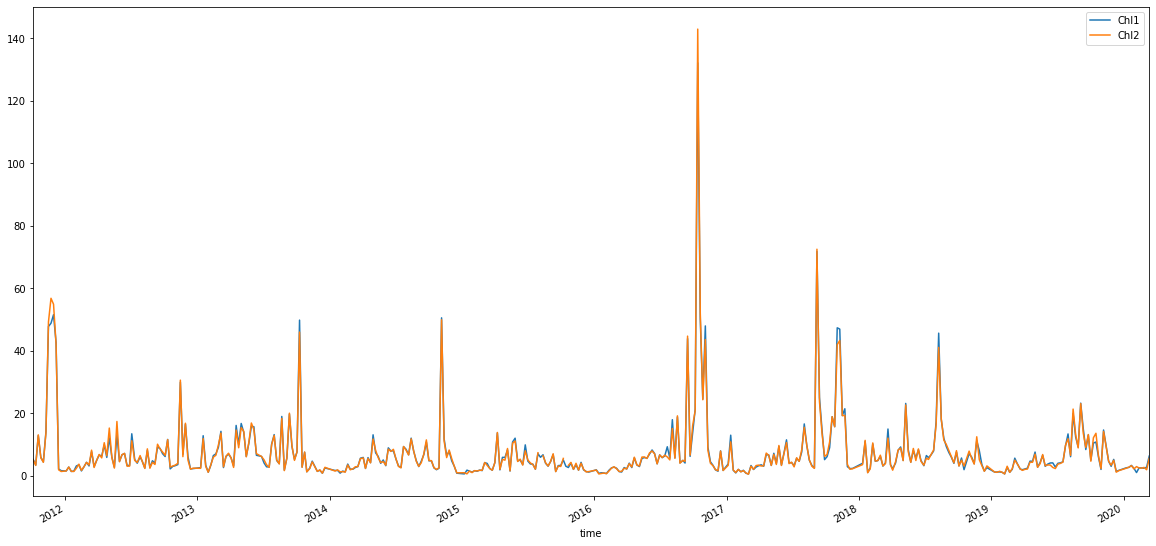

In [203]:
schab_df1 = schab_df.set_index('time')
schab_df1.Chl1.plot(legend=True)
schab_df1.Chl2.plot(legend=True)

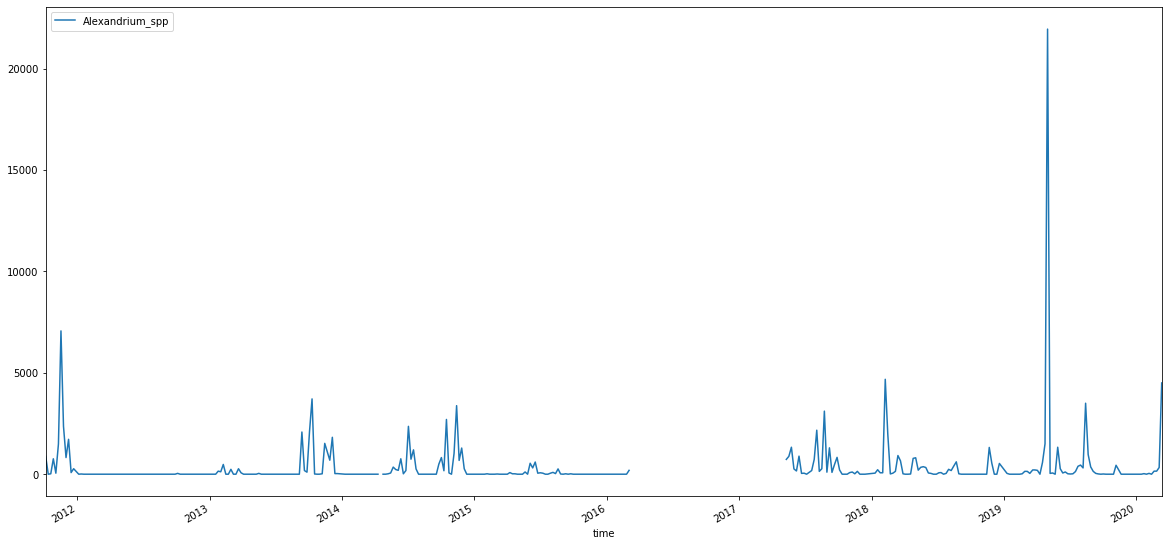

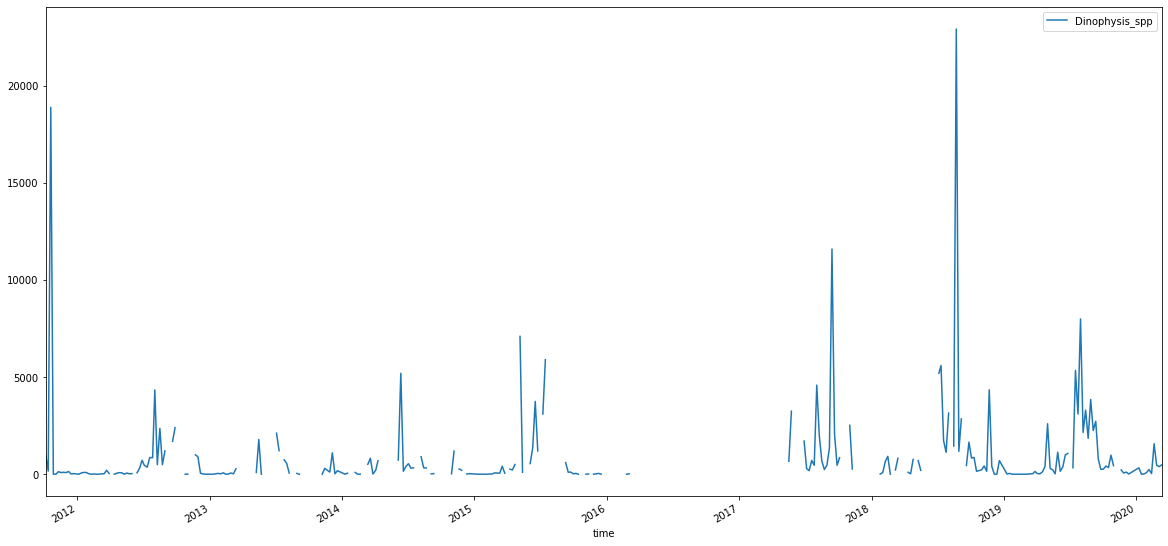

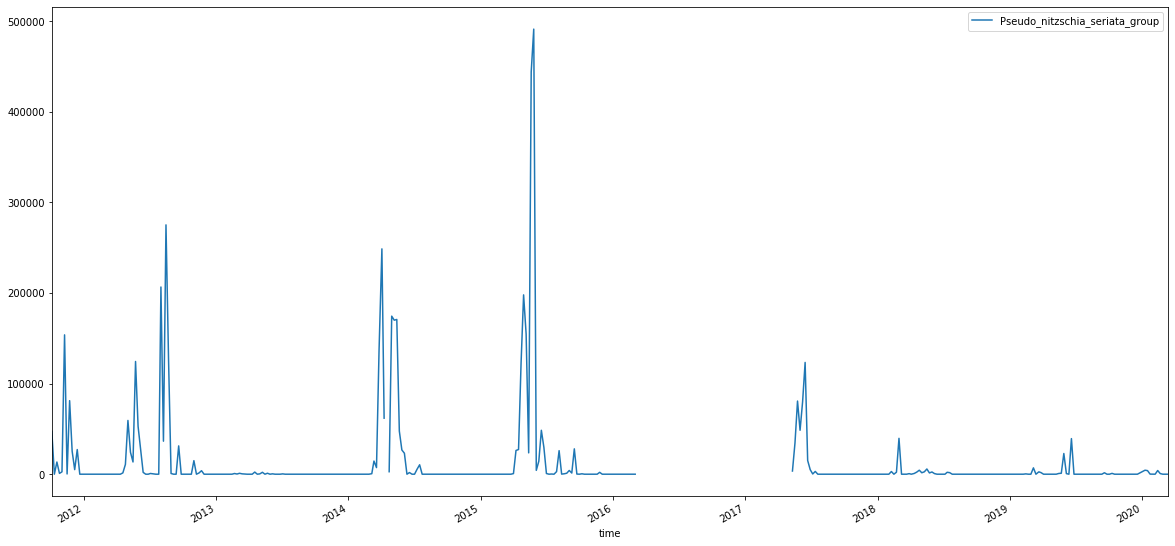

In [204]:
schab_df1.Alexandrium_spp.plot(legend=True)
plt.show()
schab_df1.Dinophysis_spp.plot(legend=True)
plt.show()
schab_df1.Pseudo_nitzschia_seriata_group.plot(legend=True)

In [205]:
# HAB - Cal Poly data. 
data_file = "data/ERDDAP-Cali/"
schab_df = pd.read_csv(data_file+"CalPoly-HABs.csv", skiprows=[1])
#schab_df.drop(0, axis=0, inplace=True) # first row are the units

# dropping all columns which only have nan
x = schab_df.isna().all()
y = [x[x==True].index[i] for i in range(len(x[x==True]))]
schab_df.drop(y, axis=1, inplace=True)

# dropping other columns/rows
schab_df.drop(["SampleID", "Location_Code", "Chl_Volume_Filtered"], axis=1, inplace=True)

schab_df.time = schab_df.apply(lambda row: parser.parse(row.time), axis=1)

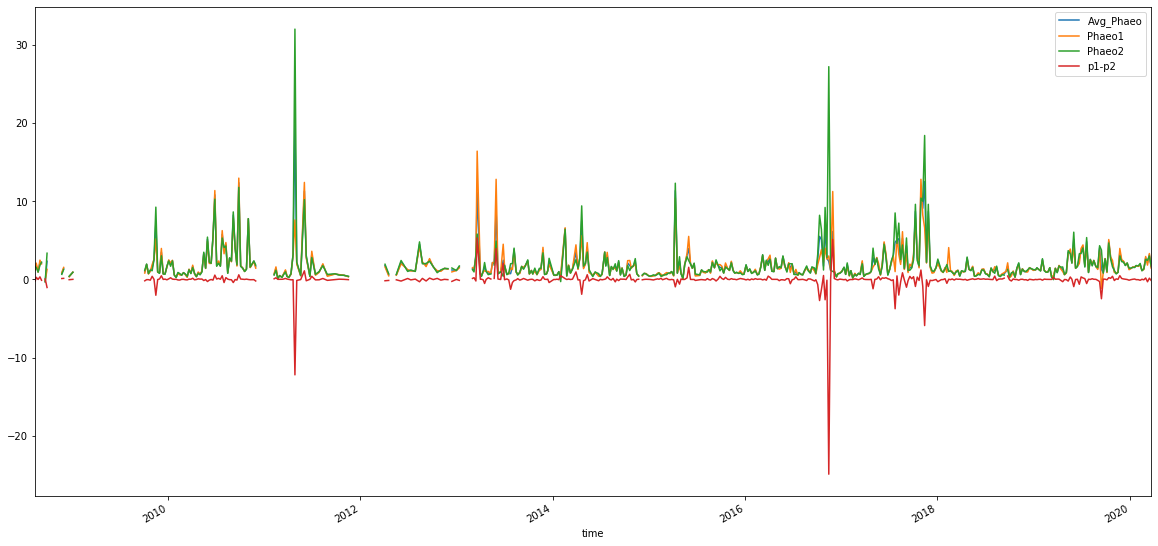

In [226]:
schab_df1.Avg_Phaeo.plot(legend=True)
schab_df1.Phaeo1.plot(legend=True)
schab_df1.Phaeo2.plot(legend=True)

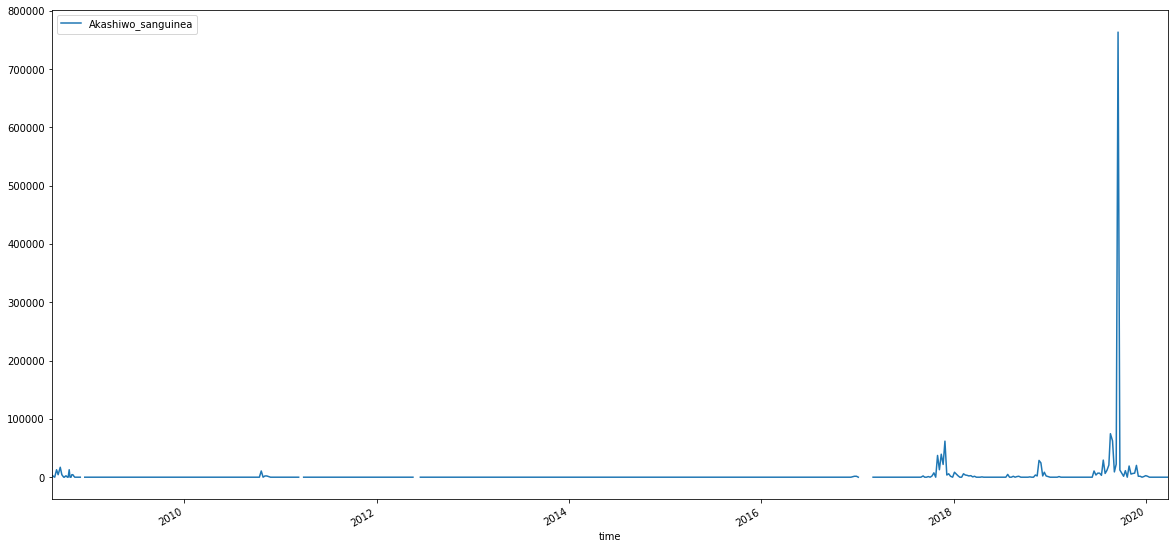

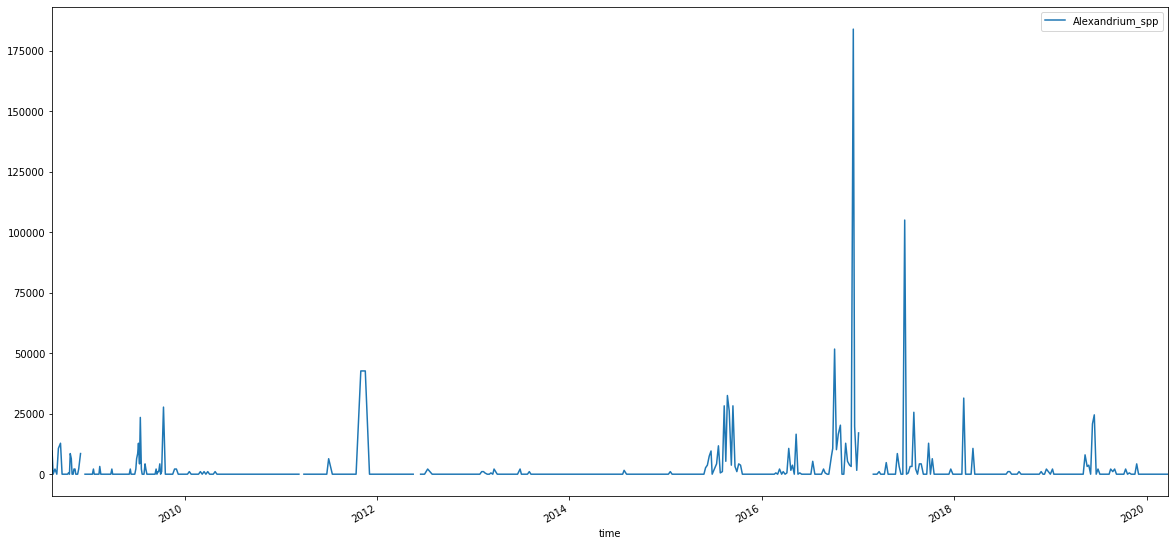

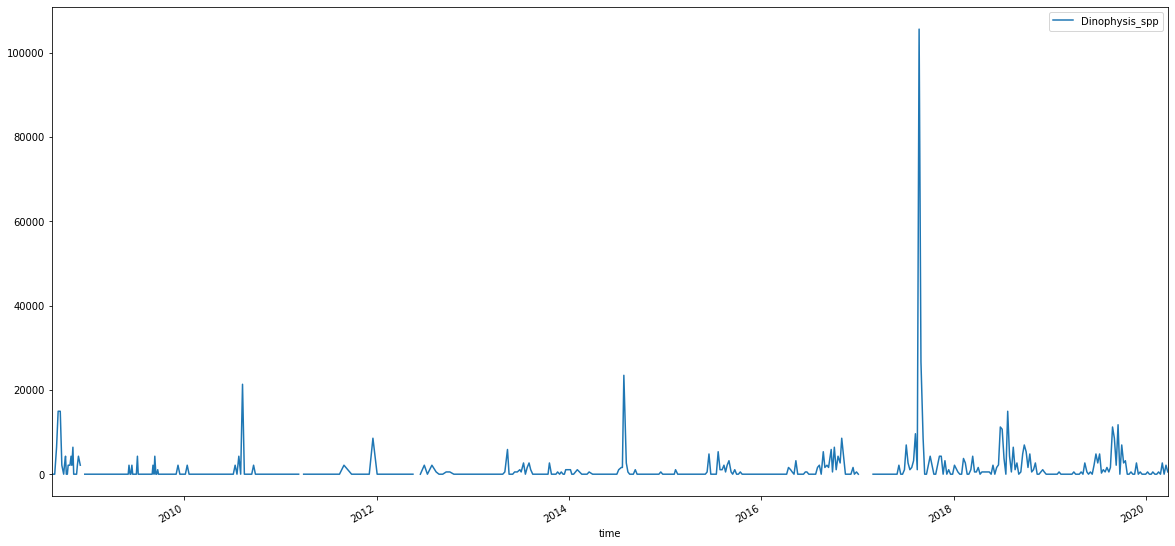

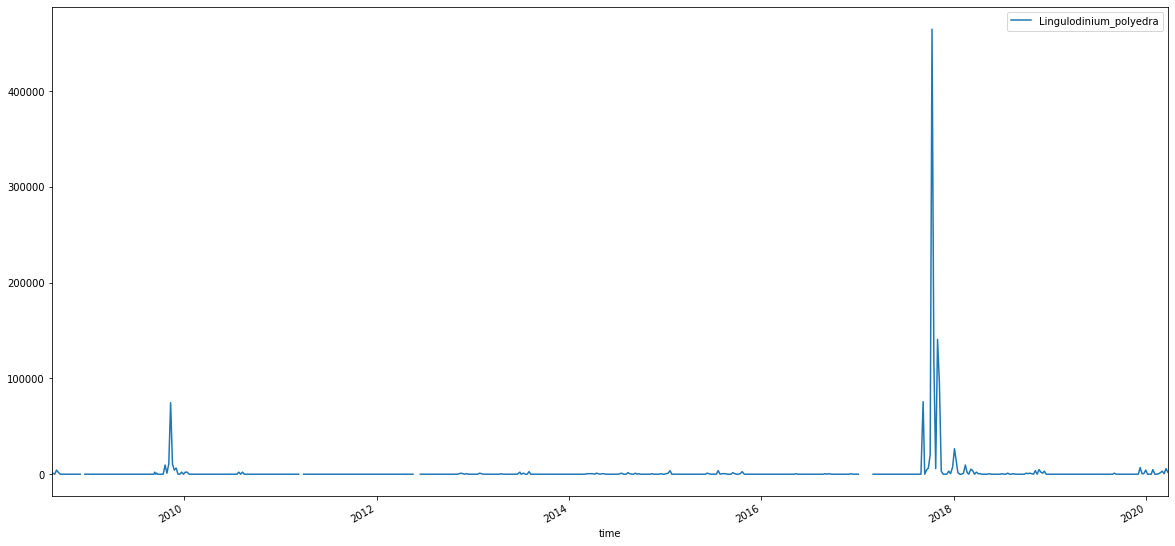

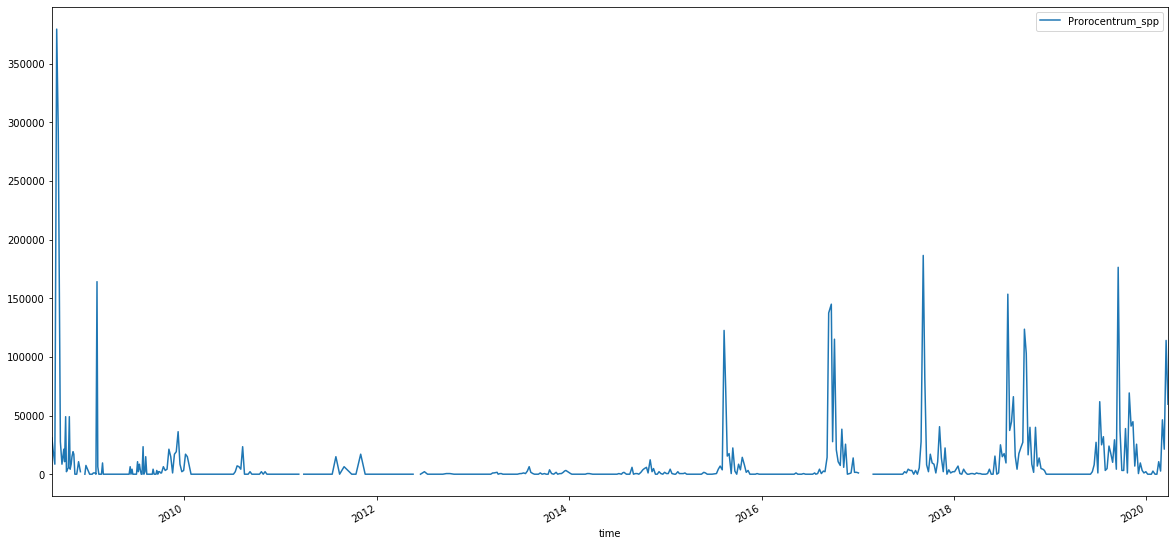

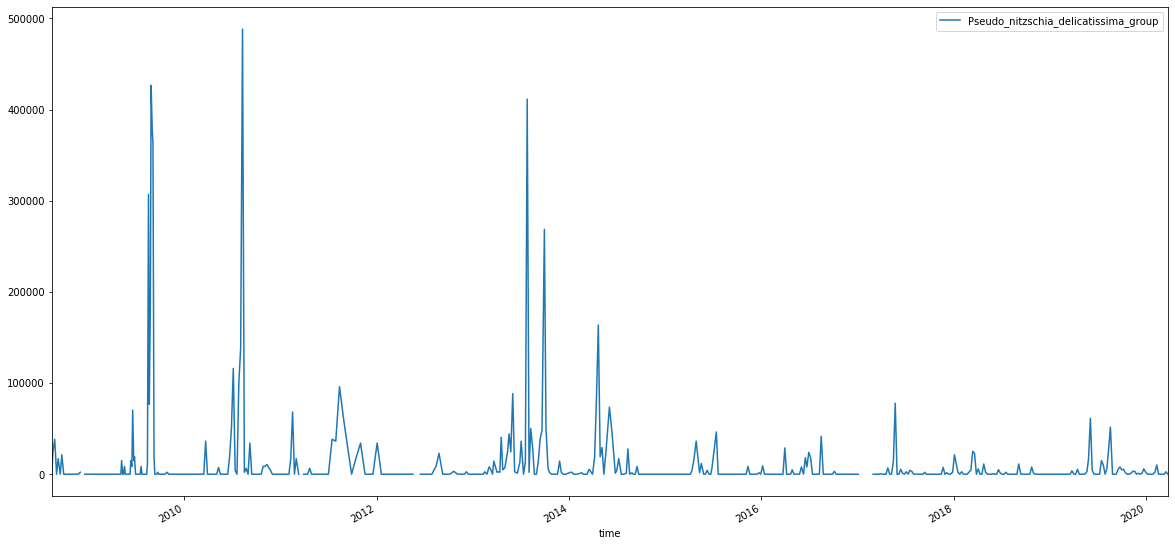

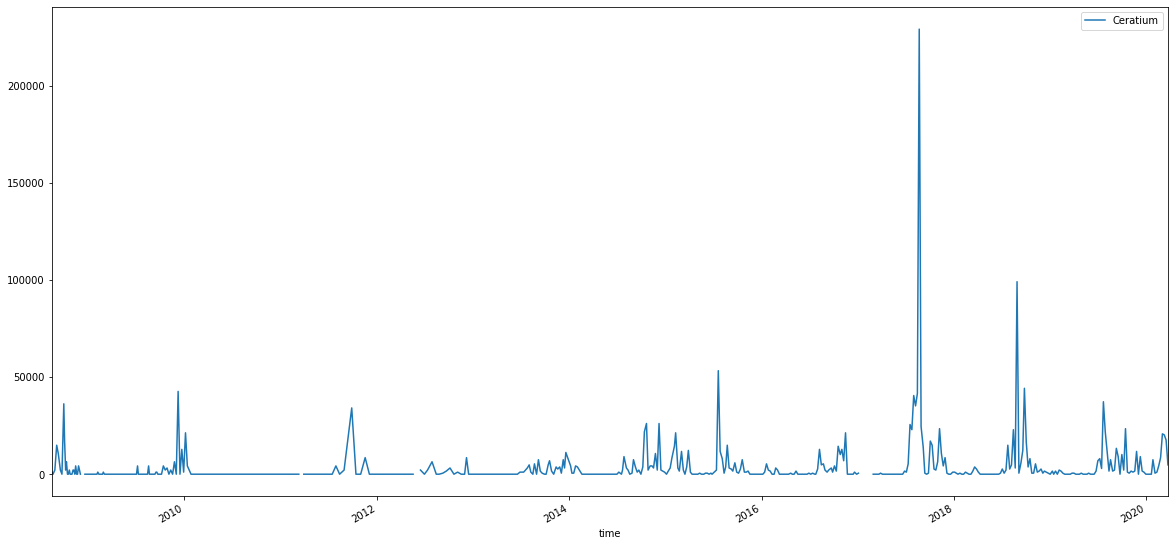

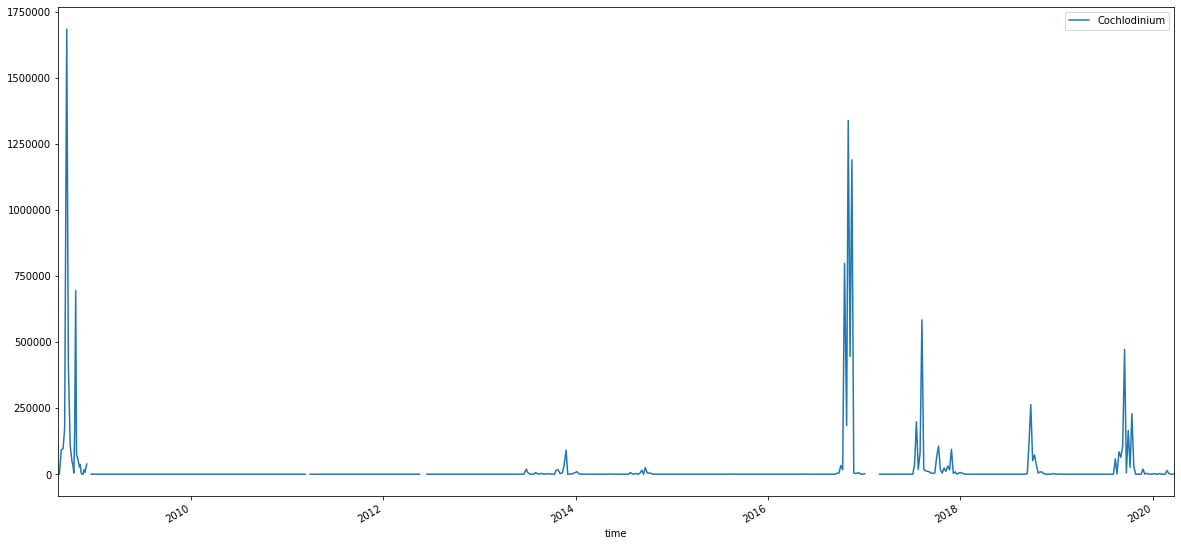

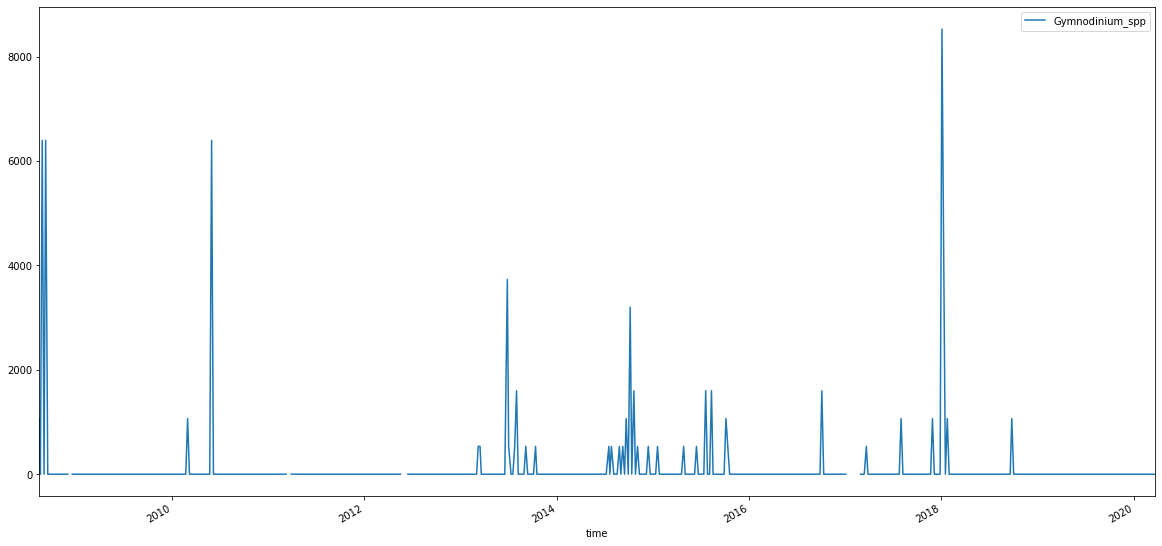

In [208]:
schab_df1.Akashiwo_sanguinea.plot(legend=True)
plt.show()
schab_df1.Alexandrium_spp.plot(legend=True)
plt.show()
schab_df1.Dinophysis_spp.plot(legend=True)
plt.show()
schab_df1.Lingulodinium_polyedra.plot(legend=True)
plt.show()
schab_df1.Prorocentrum_spp.plot(legend=True)
plt.show()
schab_df1.Pseudo_nitzschia_delicatissima_group.plot(legend=True)
plt.show()
schab_df1.Ceratium.plot(legend=True)
plt.show()
schab_df1.Cochlodinium.plot(legend=True)
plt.show()
schab_df1.Gymnodinium_spp.plot(legend=True)
plt.show()

In [392]:
# Florida - HAB data 
data_file = "data/Florida-HAB/"
fl_df_1 = pd.read_csv(data_file+"habsos_20200310.csv")
fl_df_2 = pd.read_csv(data_file+"habsos_20190211.csv")
fl_df_3 = pd.read_csv(data_file+"habsos_20180227.csv")
fl_df_4 = pd.read_csv(data_file+"habsos_20140806.csv")
fl_df_5 = pd.read_csv(data_file+"habsos_20140806 copy.csv")

fl_dfs = [fl_df_1, fl_df_2, fl_df_3, fl_df_4, fl_df_5]

/Users/saadghani/Development/miniconda3/envs/URFP_Plankton/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (20,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/saadghani/Development/miniconda3/envs/URFP_Plankton/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [393]:
# removing excess columns
for i in range(1, len(fl_dfs)):
    fl_dfs[i].drop("qa_comment", axis=1, inplace=True)
    if i >=3:
        fl_dfs[i].drop("shape", axis=1, inplace=True)
# after the above, all fl_dfs have same columns

# adding erything together
main_fl_df = fl_dfs[0]
#print("mdf", main_fl_df.shape)
for i in range(1, len(fl_dfs)):
    temp_df = fl_dfs[i]
    #print("tdf:", temp_df.shape)
    main_fl_df, temp_df = main_fl_df.align(temp_df, join='inner', axis=1)
    main_fl_df = main_fl_df.append(temp_df, ignore_index = True) 
    #print("mdf", main_fl_df.shape)

# show duplicates in main_df
duprows = main_fl_df.duplicated()
main_fl_df[duprows]

# drop duplicates
main_fl_df.drop_duplicates(inplace=True)
main_fl_df.shape

(558119, 25)

In [394]:
# preprocessing the entire df
fl_df = main_fl_df

# dropping columns which only have NaN values
x = fl_df.isna().all()
y = [x[x==True].index[i] for i in range(len(x[x==True]))]
fl_df.drop(y, axis=1, inplace=True)

# dropping columns which have only 1 value or have 2 values of which 1 is nan
y = []
for col in fl_df.columns:
    unq = fl_df[col].unique()
    if (len(unq) == 2 and pd.isna(unq).any()) or len(unq) == 1:
            y.append(col)
fl_df.drop(y, axis=1, inplace=True)

# dropping other columns/rows
fl_df.drop(["objectid", "description", "state_id", "wind_dir", "wind_dir_qa", "wind_speed", "wind_speed_qa"], axis=1, inplace=True)
fl_df.drop(0, axis=0, inplace=True) # erroneous row containing date of year "0153" (probably 1953 but we can ignore 1 row)

# converting time from str to datetime
fl_df.sample_date = pd.to_datetime(fl_df.sample_date)

# category has 5 values - not observed, very low, low, medium, high.
# These are the outputs which we have to forecast
# substituting these 5 values for 0, 1, 2, 3, 4
fl_df.category.where(fl_df.category != "not observed", 0, inplace=True)
fl_df.category.where(fl_df.category != "very low", 1, inplace=True)
fl_df.category.where(fl_df.category != "low", 2, inplace=True)
fl_df.category.where(fl_df.category != "medium", 3, inplace=True)
fl_df.category.where(fl_df.category != "high", 4, inplace=True)
fl_df.category = pd.to_numeric(fl_df.category)


In [395]:
# print("lat max:",fl_df.latitude.max())
# print("lat min:",fl_df.latitude.min())
# print("long max:",fl_df.longitude.max())
# print("long min:",fl_df.longitude.min())

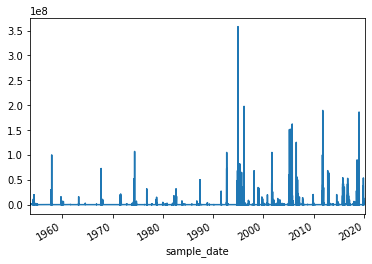

In [396]:
fl_df1.cellcount.plot() # this is kind of what we have to predict
# plt.show()
# fl_df1.salinity.plot()
# plt.show()
# fl_df1.water_temp.plot()
# plt.show()
# fl_df1.water_temp_qa.plot()
# plt.show()
# fl_df1.salinity_qa.plot()

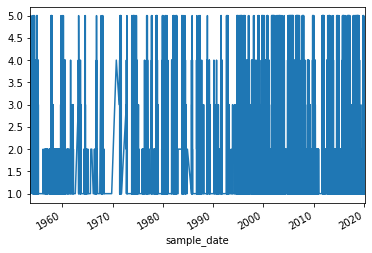

In [397]:
fl_df1.category.plot() # the output too.

In [398]:
# so 0.001 lat/long of each other are going to be considered the same point. aight?
# 0.001 = 100 meters. (approximated on google maps)
def group_coords(coords, ind, delta=0.001):
    #print(coords)
    n = len(coords)
    i=1
    while True and ind+i < n:
        if abs(coords[ind+i] - coords[ind]) < delta:
            coords[ind+i] = coords[ind]
            i+= 1
        else:
            break
    if ind+i < n:
        #print(coords)
        coords[ind+i:] = group_coords(coords[ind+i:], len(coords[ind+i:])//2, delta)

    i=-1
    while True and ind + i >= 0:
        # compare ind with ind + i
        if abs(coords[ind+i] - coords[ind]) < delta:
            coords[ind+i] = coords[ind]
            i-=1
        else:
            break
    if ind+i+1 > 0:
        coords[:ind+i+1] = group_coords(coords[:ind+i+1],len(coords[:ind+i+1])//2, delta)
    
    return coords

lat = fl_df.latitude.sort_values()
lat_ind = lat.index
lat = lat.to_numpy()

lng = fl_df.longitude.sort_values()
lng_ind = lng.index
lng = lng.to_numpy()

# average HAB in HK is about 1.76km by 1.76km
# 1 unit lat = 111 km
# 1 unit long at lat 27.335793345887428 (avg. lat) = 88 km
# 1.76 km = 0.016 lat and 0.02 long

group_coords(lat, len(lat)//2, 0.016/2)
group_coords(lng, len(lng)//2, 0.02/2)

fl_df.latitude.loc[lat_ind] = lat
fl_df.longitude.loc[lng_ind] = lng

# now to plot the above graphs under one lat/long first find out how many locations do we have
fl_df["lat_long"] = fl_df.apply(lambda row: (row.latitude, row.longitude), axis=1)

/Users/saadghani/Development/miniconda3/envs/URFP_Plankton/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


8533


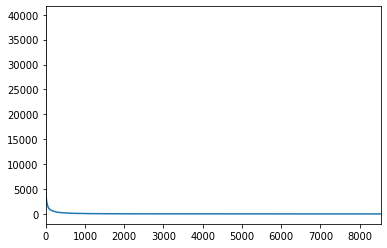

In [423]:
old = fl_df2.lat_long.value_counts()
old.reset_index().lat_long.plot()
print(len(old))

13814


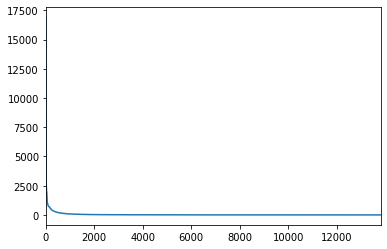

In [424]:
new = fl_df.lat_long.value_counts()
new.reset_index().lat_long.plot()
print(len(new))

In [429]:
print(len(new[new>500]))
print(len(old[old>500]))

212
221


In [285]:
# this is to find correlation between locations. so if theres a high correlation that means that the HAB event took place in that area.
fiveK = locs[locs>1000].index

df = pd.DataFrame(columns=[])

i=0
for loc in fiveK:
    vals = fl_df2[fl_df2.lat_long == loc].cellcount
    valSum = vals.groupby(vals.index).sum()
    
    # taking non-zero only
    non0 = valSum[valSum!=0]
    
    #ax = non0.plot(figsize=(20,8))
    #ax.legend(fiveK.values)
    df = pd.concat([df, non0.rename(str(i))], axis=1)
    i += 1
df = df.fillna(0)
df.corr()

0         1         2         3         4         5         6  \
0   1.000000  0.052023 -0.001200  0.013424  0.004683 -0.000847 -0.001915   
1   0.052023  1.000000 -0.000420  0.043915  0.004179 -0.000460 -0.001738   
2  -0.001200 -0.000420  1.000000 -0.000382  0.000032 -0.000522 -0.001021   
3   0.013424  0.043915 -0.000382  1.000000  0.004590  0.002369 -0.001067   
4   0.004683  0.004179  0.000032  0.004590  1.000000  0.003344  0.001872   
..       ...       ...       ...       ...       ...       ...       ...   
87 -0.001317 -0.000793 -0.000457 -0.000488 -0.000404 -0.000395  0.000374   
88 -0.002283 -0.000224  0.020208 -0.000905  0.001088 -0.001131 -0.001978   
89 -0.001852 -0.001092  0.008108 -0.000672 -0.000907 -0.000840 -0.001485   
90 -0.002380 -0.001399 -0.000846 -0.000862 -0.001163 -0.001076 -0.001903   
91 -0.000770 -0.000449  0.002459 -0.000277 -0.000375 -0.000348 -0.000616   

           7         8         9  ...        82        83        84        85  \
0   0.020374 -0.002667  0.011803  ...  0.001404 -0.001254 -0.000766  0.000733   
1   0.061207 -0.001233 -0.000617  ... -0.000736 -0.000737 -0.000450 -0.000809   
2   0.000886  0.001525 -0.000653  ... -0.000380  0.004380 -0.000276  0.001861   
3   0.022008 -0.000643  0.001496  ...  0.000032 -0.000454 -0.000277 -0.000498   
4   0.009204 -0.001297  0.003951  ...  0.001509 -0.000613 -0.000374 -0.000672   
..       ...       ...       ...  ...       ...       ...       ...       ...   
87 -0.000585 -0.001006 -0.000747  ... -0.000457 -0.000458 -0.000280 -0.000503   
88  0.000214 -0.001853 -0.002454  ... -0.000846  0.020177 -0.000518 -0.000930   
89 -0.000804  0.014345 -0.001824  ... -0.000628 -0.000630 -0.000384 -0.000691   
90 -0.001030 -0.001763 -0.002338  ... -0.000805 -0.000807 -0.000493 -0.000886   
91 -0.000322 -0.000440 -0.000757  ... -0.000261 -0.000261 -0.000159 -0.000287   

          86        87        88        89        90        91  
0  -0.001902 -0.001317 -0.002283 -0.001852 -0.002380 -0.000770  
1  -0.001118 -0.000793 -0.000224 -0.001092 -0.001399 -0.000449  
2  -0.000686 -0.000457  0.020208  0.008108 -0.000846  0.002459  
3  -0.000689 -0.000488 -0.000905 -0.000672 -0.000862 -0.000277  
4  -0.000929 -0.000404  0.001088 -0.000907 -0.001163 -0.000375  
..       ...       ...       ...       ...       ...       ...  
87 -0.000695  1.000000 -0.000913 -0.000678 -0.000869 -0.000281  
88 -0.001286 -0.000913  1.000000 -0.001255 -0.001609 -0.000521  
89 -0.000955 -0.000678 -0.001255  1.000000  0.083727  0.045781  
90  0.167621 -0.000869 -0.001609  0.083727  1.000000  0.036658  
91 -0.000396 -0.000281 -0.000521  0.045781  0.036658  1.000000  

[92 rows x 92 columns]

In [431]:
# this is to find out the largest consecutive records in a subset of locations.
def largest_conseq(bl):
    max_seq = 0
    cur_seq = 0
    
    cur_i = None
    max_i = None
    for index, row in bl.iterrows():
        if row.latitude==0:
            if cur_seq > max_seq:
                max_seq = cur_seq
                max_i = cur_i
            cur_seq=0
            cur_i = None
        else:
            if cur_i is None:
                cur_i = index
            cur_seq += 1
    return max_seq, max_i

In [432]:
# this is to find out the largest consecutive records in a subset of locations.
deltas = ["D", "2D", "3D", "4D", "5D", "6D", "W", "2W"]
all_data = {"loc":[], "max_seq":[], "max_freq": [], "min_miss":[], "size":[], "max_ind":[]}

fl_df2 = fl_df.set_index("sample_date")
locs = fl_df2.lat_long.value_counts()

for loc in locs[locs>1000].index:
    print("location:", loc)
    big_loc = fl_df2[fl_df2.lat_long==loc]
    
    bls = []
    for d in deltas:
        bls.append(big_loc.resample(d).sum())
    
    max_seq = 0
    max_freq = None
    max_ind = None
    min_miss = 1.0
    for bl in bls:
        conseq, ind = largest_conseq(bl)
        
        if ind is None:
            continue
        freq = ind.freq
        miss = len(bl[bl.latitude==0]) / len(bl)

        if max_seq < conseq:
            max_seq = conseq
            max_freq = freq
            max_ind = ind
        if min_miss > miss:
            min_miss = miss
    
    all_data["loc"].append(loc)
    all_data["max_seq"].append(max_seq)
    all_data["max_ind"].append(max_ind)
    all_data["max_freq"].append(max_freq)
    all_data["min_miss"].append(min_miss)
    all_data["size"].append(len(bl))
    
#     print("max conseq:", max_seq)
#     print("max index:", max_ind)
#     print("for freq:", max_freq)
#     print("min miss(%):", min_miss)
#     print("######################################")

location: (27.325740000000003, -82.57938)
location: (27.3384, -82.57938)
location: (27.0724, -82.4428)
location: (25.9124, -81.7267)
location: (27.5367, -82.7402)
location: (27.4417, -82.6882)
location: (26.131629999999998, -81.8063)
location: (26.7138, -82.2575)
location: (26.33105, -81.84574)
location: (26.81581, -82.27219000000001)
location: (26.2073, -81.8169)
location: (27.783, -82.78223)
location: (27.3046, -82.56244000000001)
location: (27.61, -82.7402)
location: (27.1048, -82.4688)
location: (27.37888, -82.632)
location: (26.893720000000002, -82.3416)
location: (27.11502, -82.4688)
location: (26.93, -82.36189)
location: (27.0103, -82.415)
location: (27.266479999999998, -82.56244000000001)
location: (27.819000000000003, -82.8333)
location: (27.3046, -82.57938)
location: (27.61, -82.6522)
location: (26.453979999999998, -81.95257)
location: (26.6083, -82.22)
location: (27.325740000000003, -82.56244000000001)
location: (27.218429999999998, -82.5208)
location: (27.6283, -82.6733)
lo

In [433]:
dfBL = pd.DataFrame(all_data)
dfBL

loc  max_seq                max_freq  \
0   (27.325740000000003, -82.57938)      355              <5 * Days>   
1              (27.3384, -82.57938)      351              <5 * Days>   
2               (27.0724, -82.4428)      229       <Week: weekday=6>   
3               (25.9124, -81.7267)      233  <2 * Weeks: weekday=6>   
4               (27.5367, -82.7402)      169       <Week: weekday=6>   
..                              ...      ...                     ...   
64   (27.266479999999998, -82.5442)       29  <2 * Weeks: weekday=6>   
65              (27.8867, -82.4688)       26       <Week: weekday=6>   
66              (27.9228, -82.5442)       15  <2 * Weeks: weekday=6>   
67   (27.325740000000003, -82.5442)       20  <2 * Weeks: weekday=6>   
68     (25.922, -81.63866999999999)       25  <2 * Weeks: weekday=6>   

    min_miss  size    max_ind  
0   0.572426  1719 2006-01-01  
1   0.614499  1476 2006-03-16  
2   0.670856  1273 2006-07-30  
3   0.662996  1362 2002-02-10  
4   0.651419  1727 2012-12-23  
..       ...   ...        ...  
64  0.887931  1624 2009-07-26  
65  0.793634   974 1964-02-09  
66  0.764984  1268 2013-12-15  
67  0.863768  1725 2017-08-13  
68  0.716495   582 2008-12-14  

[69 rows x 6 columns]

In [448]:
dfBL.nsmallest(5, 'min_miss')

loc  max_seq                max_freq  min_miss  size  \
42   (27.0724, -82.4535)      116  <2 * Weeks: weekday=6>  0.161725   371   
41  (26.9632, -82.38983)      116  <2 * Weeks: weekday=6>  0.273349   439   
39  (27.12332, -82.4688)       69  <2 * Weeks: weekday=6>  0.321199   467   
40    (27.057, -82.4428)      116  <2 * Weeks: weekday=6>  0.376953   512   
43   (26.3905, -81.8828)      220       <Week: weekday=6>  0.403409   528   

      max_ind  
42 2006-08-06  
41 2006-08-06  
39 2006-08-06  
40 2006-08-06  
43 2013-06-23

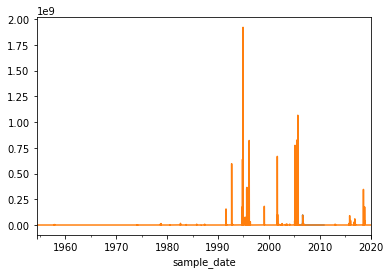

In [447]:
# taking in the location and frequency with the most number of consecutive records
sixD_maxLoc = fl_df2[fl_df2.lat_long==(27.325740000000003, -82.57938)].resample("5D").sum()
# number of records = 355, starting from "2006-01-01", location = 3774. 

starting_loc = sixD_maxLoc.index.get_loc("2006-01-01")
sixD_maxLoc.iloc[starting_loc:starting_loc+355].cellcount.plot()
sixD_maxLoc.cellcount.plot()

In [439]:
fl_df2.category = pd.to_numeric(fl_df2.category)

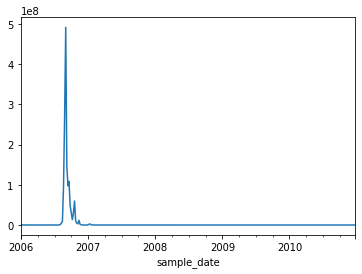

AttributeError: 'DataFrame' object has no attribute 'category'

In [382]:
sixD_maxLoc.iloc[3159:3159+305].cellcount.plot()
plt.show()
sixD_maxLoc.iloc[3159:3159+305].category.plot()

In [473]:
# lets do a simple time series analysis on allll the data
fl_df.category = pd.to_numeric(fl_df.category)
fl_df_ts = fl_df.set_index("sample_date")


In [479]:
# this is to find out the largest consecutive records in the deltas.
deltas = ["6H", "8H", "12H", "D", "2D", "3D", "4D", "5D", "6D", "W", "2W"]
all_data = {"delta":[], "max_seq":[], "max_freq": [], "min_miss":[], "size":[], "max_ind":[]}

i = 0
for delta in deltas:
    print(i)
    resampled = fl_df_ts.resample(delta).sum()
    
    max_seq = 0
    max_freq = None
    max_ind = None
    min_miss = 1.0
    conseq, ind = largest_conseq(resampled)
    if ind is None:
        continue

    freq = ind.freq
    miss = len(resampled[resampled.latitude==0]) / len(resampled)

    if max_seq < conseq:
        max_seq = conseq
        max_freq = freq
        max_ind = ind
    if min_miss > miss:
        min_miss = miss

    all_data["delta"].append(delta)
    all_data["max_seq"].append(max_seq)
    all_data["max_ind"].append(max_ind)
    all_data["max_freq"].append(max_freq)
    all_data["min_miss"].append(min_miss)
    all_data["size"].append(len(resampled))
    i+=1
#     print("max conseq:", max_seq)
#     print("max index:", max_ind)
#     print("for freq:", max_freq)
#     print("min miss(%):", min_miss)
#     print("######################################")

0
1
2
3
4
5
6
7
8
9
10


In [493]:
df = pd.DataFrame(all_data)
effective_seq = [3,4,6,12,24,36,48,60,72,84,168]
df["effective_seq"] = df.max_seq.multiply(effective_seq, axis=0)
df

delta  max_seq                max_freq  min_miss   size  \
0     6H       67             <6 * Hours>  0.790578  97239   
1     8H       68             <8 * Hours>  0.743929  72929   
2    12H       83            <12 * Hours>  0.694056  48620   
3      D      215                   <Day>  0.593089  24310   
4     2D      454              <2 * Days>  0.489757  12155   
5     3D      876              <3 * Days>  0.417201   8104   
6     4D      574              <4 * Days>  0.367062   6078   
7     5D      459              <5 * Days>  0.330317   4862   
8     6D      573              <6 * Days>  0.301333   4052   
9      W      706       <Week: weekday=6>  0.275187   3474   
10    2W      462  <2 * Weeks: weekday=6>  0.191024   1738   

               max_ind  effective_seq  
0  2018-10-08 12:00:00            201  
1  2017-06-06 08:00:00            272  
2  2018-09-14 12:00:00            498  
3  2019-01-21 00:00:00           2580  
4  2017-09-10 00:00:00          10896  
5  2012-12-25 00:00:00          31536  
6  2004-09-20 00:00:00          27552  
7  2004-09-20 00:00:00          27540  
8  2001-08-07 00:00:00          41256  
9  1997-06-29 00:00:00          59304  
10 1993-08-15 00:00:00          77616

1043


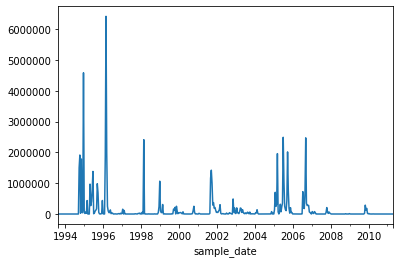

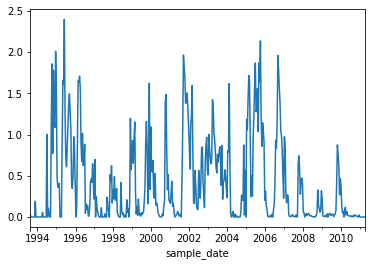

In [505]:
# taking effective_seq. 10	2W	462	<2 * Weeks: weekday=6>	0.191024	1738	1993-08-15 00:00:00	77616
# starting loc: 7226
max_seq_ts = fl_df_ts.resample("2W").mean()

st_loc = max_seq_ts.index.get_loc("1993-08-15 00:00:00")
print(st_loc)

max_seq_ts.iloc[st_loc:st_loc+462].cellcount.plot()
plt.show()

working_data = max_seq_ts.iloc[st_loc:st_loc+462].category
working_data.plot()
working_data = working_data.values

In [509]:
# normalizing the data
split = [0.8,0.2]
train_data = working_data[:int(len(working_data)*split[0])]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [510]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.9761496]
 [-1.       ]
 [-1.       ]
 [-1.       ]
 [-1.       ]]
[[-1.        ]
 [-0.99622279]
 [-0.97814039]
 [-1.        ]
 [-0.99521625]]


In [511]:
import torch
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [514]:
train_data_normalized

tensor([-9.7615e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -8.4100e-01, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -9.5362e-01, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.6524e-01, -1.0000e+00,
        -9.1213e-01, -9.5488e-01, -1.0000e+00, -1.0000e+00, -9.4834e-02,
         5.4920e-01, -3.5723e-01,  4.8657e-01, -3.1674e-02, -9.3976e-02,
         6.7663e-01,  2.9852e-01, -5.9808e-01, -6.9856e-01, -6.8873e-01,
        -6.5851e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -2.1599e-01,
         3.8315e-01,  3.4206e-01,  1.0000e+00,  6.0376e-02, -4.0639e-01,
        -4.9188e-01, -2.8800e-01, -1.0896e-01,  1.3968e-01,  2.4535e-01,
         7.3268e-02, -1.0992e-01, -6.4629e-01, -7.1195e-01, -5.9210e-01,
        -1.8842e-01, -3.3525e-01, -6.9335e-01, -1.0000e+00, -9.0368e-01,
        -2.7941e-01,  3.7726e-01,  3.6971e-01,  4.2

In [513]:
train_window = 10

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq

[(tensor([-0.9761, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410,
          -1.0000, -1.0000]), tensor([-1.])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410, -1.0000,
          -1.0000, -1.0000]),
  tensor([-1.])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410, -1.0000, -1.0000,
          -1.0000, -1.0000]), tensor([-1.])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.8410, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000]), tensor([-1.])),
 (tensor([-1.0000, -1.0000, -1.0000, -0.8410, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000]), tensor([-1.])),
 (tensor([-1.0000, -1.0000, -0.8410, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000]), tensor([-1.])),
 (tensor([-1.0000, -0.8410, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000]), tensor([-1.])),
 (tensor([-0.8410, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -

In [515]:
len(train_inout_seq)

359

In [516]:
from models.TS import LSTM
import torch.nn as nn

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [539]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        print("y_pred", y_pred)
        print("seq", seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

y_pred tensor([-0.8812], grad_fn=<SelectBackward>)
seq tensor([-0.9761, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410,
        -1.0000, -1.0000])
y_pred tensor([-1.0158], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9352], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9973], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.8410, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8995], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.8410, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9401], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.8410, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9460], gra

y_pred tensor([-0.7852], grad_fn=<SelectBackward>)
seq tensor([-0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921,
        -0.1884, -0.3352])
y_pred tensor([-1.0571], grad_fn=<SelectBackward>)
seq tensor([ 0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884,
        -0.3352, -0.6934])
y_pred tensor([-0.9329], grad_fn=<SelectBackward>)
seq tensor([ 0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352,
        -0.6934, -1.0000])
y_pred tensor([-0.3450], grad_fn=<SelectBackward>)
seq tensor([ 0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934,
        -1.0000, -0.9037])
y_pred tensor([0.2096], grad_fn=<SelectBackward>)
seq tensor([-0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000,
        -0.9037, -0.2794])
y_pred tensor([0.4019], grad_fn=<SelectBackward>)
seq tensor([-0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037,
        -0.2794,  0.3773])
y_pred tensor([0.2874], grad_f

y_pred tensor([-0.9727], grad_fn=<SelectBackward>)
seq tensor([-0.8159, -0.5905, -0.8300, -0.8265, -0.7126, -0.9536, -0.9806, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8338], grad_fn=<SelectBackward>)
seq tensor([-0.5905, -0.8300, -0.8265, -0.7126, -0.9536, -0.9806, -1.0000, -1.0000,
        -1.0000, -0.6522])
y_pred tensor([-0.8373], grad_fn=<SelectBackward>)
seq tensor([-0.8300, -0.8265, -0.7126, -0.9536, -0.9806, -1.0000, -1.0000, -1.0000,
        -0.6522, -0.9358])
y_pred tensor([-0.9818], grad_fn=<SelectBackward>)
seq tensor([-0.8265, -0.7126, -0.9536, -0.9806, -1.0000, -1.0000, -1.0000, -0.6522,
        -0.9358, -0.9739])
y_pred tensor([-0.9848], grad_fn=<SelectBackward>)
seq tensor([-0.7126, -0.9536, -0.9806, -1.0000, -1.0000, -1.0000, -0.6522, -0.9358,
        -0.9739, -0.9602])
y_pred tensor([-0.9427], grad_fn=<SelectBackward>)
seq tensor([-0.9536, -0.9806, -1.0000, -1.0000, -1.0000, -0.6522, -0.9358, -0.9739,
        -0.9602, -1.0000])
y_pred tensor([-1.0020], gra

y_pred tensor([-0.6634], grad_fn=<SelectBackward>)
seq tensor([-0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859,
        -0.8854, -0.8391])
y_pred tensor([-0.1477], grad_fn=<SelectBackward>)
seq tensor([-0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854,
        -0.8391,  0.1571])
y_pred tensor([-0.1983], grad_fn=<SelectBackward>)
seq tensor([-0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,
         0.1571,  0.2397])
y_pred tensor([-0.5342], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,
         0.2397, -0.3373])
y_pred tensor([-0.6276], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397,
        -0.3373, -0.7236])
y_pred tensor([-0.8158], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397, -0.3373,
        -0.7236, -0.5713])
y_pred tensor([-0.8360], gra

y_pred tensor([-0.4342], grad_fn=<SelectBackward>)
seq tensor([ 0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435,
        -0.3558, -0.2897])
y_pred tensor([-0.6773], grad_fn=<SelectBackward>)
seq tensor([-0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558,
        -0.2897, -0.3967])
y_pred tensor([-0.2316], grad_fn=<SelectBackward>)
seq tensor([-0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897,
        -0.3967, -0.6800])
y_pred tensor([-0.8161], grad_fn=<SelectBackward>)
seq tensor([-0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967,
        -0.6800, -0.2755])
y_pred tensor([-0.6894], grad_fn=<SelectBackward>)
seq tensor([-0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800,
        -0.2755, -0.8205])
y_pred tensor([-0.6240], grad_fn=<SelectBackward>)
seq tensor([-0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755,
        -0.8205, -0.6348])
y_pred tensor([-0.5039], gra

y_pred tensor([-0.1170], grad_fn=<SelectBackward>)
seq tensor([-0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,
         0.3070,  0.1574])
y_pred tensor([-0.1730], grad_fn=<SelectBackward>)
seq tensor([-0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,
         0.1574, -0.1195])
y_pred tensor([-0.3455], grad_fn=<SelectBackward>)
seq tensor([-0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574,
        -0.1195, -0.1767])
y_pred tensor([-0.6120], grad_fn=<SelectBackward>)
seq tensor([-0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195,
        -0.1767, -0.3290])
y_pred tensor([-0.7314], grad_fn=<SelectBackward>)
seq tensor([-0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195, -0.1767,
        -0.3290, -0.6070])
y_pred tensor([-0.3144], grad_fn=<SelectBackward>)
seq tensor([-0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195, -0.1767, -0.3290,
        -0.6070, -0.8089])
y_pred tensor([-0.3298], gra

seq tensor([-0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,
         0.3773,  0.3697])
y_pred tensor([0.3058], grad_fn=<SelectBackward>)
seq tensor([-0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,
         0.3697,  0.4254])
y_pred tensor([-0.2501], grad_fn=<SelectBackward>)
seq tensor([-0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,
         0.4254,  0.2899])
y_pred tensor([-0.5594], grad_fn=<SelectBackward>)
seq tensor([-0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,  0.4254,
         0.2899, -0.2541])
y_pred tensor([-0.1161], grad_fn=<SelectBackward>)
seq tensor([-0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,  0.4254,  0.2899,
        -0.2541, -0.4405])
y_pred tensor([-0.5853], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9037, -0.2794,  0.3773,  0.3697,  0.4254,  0.2899, -0.2541,
        -0.4405, -0.1540])
y_pred tensor([-0.3456], grad_fn=<SelectBackward>)
seq tensor([-0.9037, -0.2794,

y_pred tensor([-0.0007], grad_fn=<SelectBackward>)
seq tensor([-9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04,
        -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01, -2.0871e-01])
y_pred tensor([-0.7760], grad_fn=<SelectBackward>)
seq tensor([-9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01,
        -3.9290e-01, -2.2558e-01, -4.5537e-01, -2.0871e-01, -3.8560e-02])
y_pred tensor([-0.9627], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01,
        -2.2558e-01, -4.5537e-01, -2.0871e-01, -3.8560e-02, -7.3532e-01])
y_pred tensor([-0.8198], grad_fn=<SelectBackward>)
seq tensor([-8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01,
        -4.5537e-01, -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01])
y_pred tensor([-1.0800], grad_fn=<SelectBackward>)
seq tensor([-8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01,
        -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01, -8.9

y_pred tensor([-0.7959], grad_fn=<SelectBackward>)
seq tensor([-0.9437, -1.0000, -0.9906, -0.9807, -0.9712, -0.9429, -0.9614, -0.9892,
        -0.9889, -0.9731])
y_pred tensor([-0.8441], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9906, -0.9807, -0.9712, -0.9429, -0.9614, -0.9892, -0.9889,
        -0.9731, -1.0000])
y_pred tensor([-0.5308], grad_fn=<SelectBackward>)
seq tensor([-0.9906, -0.9807, -0.9712, -0.9429, -0.9614, -0.9892, -0.9889, -0.9731,
        -1.0000, -0.6051])
y_pred tensor([0.2337], grad_fn=<SelectBackward>)
seq tensor([-0.9807, -0.9712, -0.9429, -0.9614, -0.9892, -0.9889, -0.9731, -1.0000,
        -0.6051, -0.1307])
y_pred tensor([0.5394], grad_fn=<SelectBackward>)
seq tensor([-0.9712, -0.9429, -0.9614, -0.9892, -0.9889, -0.9731, -1.0000, -0.6051,
        -0.1307,  0.6372])
y_pred tensor([0.5005], grad_fn=<SelectBackward>)
seq tensor([-0.9429, -0.9614, -0.9892, -0.9889, -0.9731, -1.0000, -0.6051, -0.1307,
         0.6372,  0.5136])
y_pred tensor([0.1849], grad_fn

y_pred tensor([0.2365], grad_fn=<SelectBackward>)
seq tensor([-0.2755, -0.8205, -0.6348, -0.6353, -0.5230, -0.5897, -0.7103, -0.8052,
        -0.3302, -0.3423])
y_pred tensor([-0.4877], grad_fn=<SelectBackward>)
seq tensor([-0.8205, -0.6348, -0.6353, -0.5230, -0.5897, -0.7103, -0.8052, -0.3302,
        -0.3423,  0.3491])
y_pred tensor([-0.9379], grad_fn=<SelectBackward>)
seq tensor([-0.6348, -0.6353, -0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,
         0.3491, -0.4435])
y_pred tensor([-0.9570], grad_fn=<SelectBackward>)
seq tensor([-0.6353, -0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491,
        -0.4435, -0.9600])
y_pred tensor([-0.9728], grad_fn=<SelectBackward>)
seq tensor([-0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491, -0.4435,
        -0.9600, -1.0000])
y_pred tensor([-0.8986], grad_fn=<SelectBackward>)
seq tensor([-0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491, -0.4435, -0.9600,
        -1.0000, -0.9820])
y_pred tensor([-0.9552], grad

y_pred tensor([0.5394], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9726, -1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058,
        -0.0540,  0.6343])
y_pred tensor([0.3785], grad_fn=<SelectBackward>)
seq tensor([-0.9726, -1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,
         0.6343,  0.4913])
y_pred tensor([0.1070], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,
         0.4913,  0.3070])
y_pred tensor([-0.1581], grad_fn=<SelectBackward>)
seq tensor([-0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,
         0.3070,  0.1574])
y_pred tensor([-0.2374], grad_fn=<SelectBackward>)
seq tensor([-0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,
         0.1574, -0.1195])
y_pred tensor([-0.2903], grad_fn=<SelectBackward>)
seq tensor([-0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574,
        -0.1195, -0.1767])
y_pred tensor([-0.6050], grad_f

y_pred tensor([-0.7109], grad_fn=<SelectBackward>)
seq tensor([ 0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733,
        -0.1099, -0.6463])
y_pred tensor([-0.6700], grad_fn=<SelectBackward>)
seq tensor([-0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099,
        -0.6463, -0.7119])
y_pred tensor([-0.1768], grad_fn=<SelectBackward>)
seq tensor([-0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463,
        -0.7119, -0.5921])
y_pred tensor([-0.3450], grad_fn=<SelectBackward>)
seq tensor([-0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119,
        -0.5921, -0.1884])
y_pred tensor([-0.7025], grad_fn=<SelectBackward>)
seq tensor([-0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921,
        -0.1884, -0.3352])
y_pred tensor([-0.9613], grad_fn=<SelectBackward>)
seq tensor([ 0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884,
        -0.3352, -0.6934])
y_pred tensor([-0.8863], gra

y_pred tensor([-0.4976], grad_fn=<SelectBackward>)
seq tensor([-9.8165e-01, -1.0000e+00, -1.0000e+00, -8.2609e-01, -9.5230e-01,
        -9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01])
y_pred tensor([-0.2402], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -1.0000e+00, -8.2609e-01, -9.5230e-01, -9.1463e-01,
        -1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01])
y_pred tensor([-0.3458], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -8.2609e-01, -9.5230e-01, -9.1463e-01, -1.0000e+00,
        -8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01])
y_pred tensor([-0.1221], grad_fn=<SelectBackward>)
seq tensor([-8.2609e-01, -9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01,
        -8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01])
y_pred tensor([-0.0415], grad_fn=<SelectBackward>)
seq tensor([-9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04,
        -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01, -2.0

y_pred tensor([-0.2143], grad_fn=<SelectBackward>)
seq tensor([-0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,
         0.1158, -0.0634])
y_pred tensor([-0.4940], grad_fn=<SelectBackward>)
seq tensor([-0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158,
        -0.0634, -0.2590])
y_pred tensor([0.0506], grad_fn=<SelectBackward>)
seq tensor([ 0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634,
        -0.2590, -0.5145])
y_pred tensor([-0.0082], grad_fn=<SelectBackward>)
seq tensor([ 0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590,
        -0.5145, -0.0740])
y_pred tensor([0.2881], grad_fn=<SelectBackward>)
seq tensor([ 0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145,
        -0.0740,  0.0095])
y_pred tensor([-0.5413], grad_fn=<SelectBackward>)
seq tensor([ 0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145, -0.0740,
         0.0095,  0.3309])
y_pred tensor([-0.8993], grad_

y_pred tensor([0.4427], grad_fn=<SelectBackward>)
seq tensor([-0.7790, -0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113,
        -0.1170,  0.1946])
y_pred tensor([0.3541], grad_fn=<SelectBackward>)
seq tensor([-0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,
         0.1946,  0.4322])
y_pred tensor([-0.0406], grad_fn=<SelectBackward>)
seq tensor([-0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,
         0.4322,  0.3787])
y_pred tensor([-0.7524], grad_fn=<SelectBackward>)
seq tensor([-0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,
         0.3787, -0.2493])
y_pred tensor([-0.5223], grad_fn=<SelectBackward>)
seq tensor([-0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,  0.3787,
        -0.2493, -0.7962])
y_pred tensor([-0.7141], grad_fn=<SelectBackward>)
seq tensor([-0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,  0.3787, -0.2493,
        -0.7962, -0.5826])
y_pred tensor([-0.3346], grad_

seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9536, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.6362], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9536, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.1652])
y_pred tensor([-0.9797], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.1652, -1.0000])
y_pred tensor([-1.1606], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652,
        -1.0000, -0.9121])
y_pred tensor([-1.1189], grad_fn=<SelectBackward>)
seq tensor([-0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000,
        -0.9121, -0.9549])
y_pred tensor([-1.0013], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121,
        -0.9549, -1.0000])
y_pred tensor([0.1832], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000,

y_pred tensor([-1.0157], grad_fn=<SelectBackward>)
seq tensor([-0.7913, -0.9130, -0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055,
        -1.0000, -1.0000])
y_pred tensor([-0.9197], grad_fn=<SelectBackward>)
seq tensor([-0.9130, -0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9370], grad_fn=<SelectBackward>)
seq tensor([-0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8678], grad_fn=<SelectBackward>)
seq tensor([-0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9679])
y_pred tensor([-0.8706], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9679, -1.0000])
y_pred tensor([-0.9152], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679,
        -1.0000, -1.0000])
y_pred tensor([-0.8362], gra

y_pred tensor([-0.9977], grad_fn=<SelectBackward>)
seq tensor([-0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8780], grad_fn=<SelectBackward>)
seq tensor([-0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000,
        -1.0000, -0.9688])
y_pred tensor([-0.8867], grad_fn=<SelectBackward>)
seq tensor([-0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000,
        -0.9688, -0.9859])
y_pred tensor([-0.7831], grad_fn=<SelectBackward>)
seq tensor([-0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688,
        -0.9859, -0.8854])
y_pred tensor([-0.7012], grad_fn=<SelectBackward>)
seq tensor([-0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859,
        -0.8854, -0.8391])
y_pred tensor([-0.0231], grad_fn=<SelectBackward>)
seq tensor([-0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854,
        -0.8391,  0.1571])
y_pred tensor([-0.2200], gra

y_pred tensor([-0.7942], grad_fn=<SelectBackward>)
seq tensor([-0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967,
        -0.6800, -0.2755])
y_pred tensor([-0.6594], grad_fn=<SelectBackward>)
seq tensor([-0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800,
        -0.2755, -0.8205])
y_pred tensor([-0.6960], grad_fn=<SelectBackward>)
seq tensor([-0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755,
        -0.8205, -0.6348])
y_pred tensor([-0.5141], grad_fn=<SelectBackward>)
seq tensor([-0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755, -0.8205,
        -0.6348, -0.6353])
y_pred tensor([-0.6358], grad_fn=<SelectBackward>)
seq tensor([-0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755, -0.8205, -0.6348,
        -0.6353, -0.5230])
y_pred tensor([-0.6721], grad_fn=<SelectBackward>)
seq tensor([-0.3558, -0.2897, -0.3967, -0.6800, -0.2755, -0.8205, -0.6348, -0.6353,
        -0.5230, -0.5897])
y_pred tensor([-0.7718], gra

y_pred tensor([-0.0100], grad_fn=<SelectBackward>)
seq tensor([-0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,
         0.3070,  0.1574])
y_pred tensor([-0.1307], grad_fn=<SelectBackward>)
seq tensor([-0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,
         0.1574, -0.1195])
y_pred tensor([-0.3821], grad_fn=<SelectBackward>)
seq tensor([-0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574,
        -0.1195, -0.1767])
y_pred tensor([-0.6228], grad_fn=<SelectBackward>)
seq tensor([-0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195,
        -0.1767, -0.3290])
y_pred tensor([-0.8072], grad_fn=<SelectBackward>)
seq tensor([-0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195, -0.1767,
        -0.3290, -0.6070])
y_pred tensor([-0.1716], grad_fn=<SelectBackward>)
seq tensor([-0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195, -0.1767, -0.3290,
        -0.6070, -0.8089])
y_pred tensor([-0.2960], gra

y_pred tensor([0.6481], grad_fn=<SelectBackward>)
seq tensor([-0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,
         0.3773,  0.3697])
y_pred tensor([0.3117], grad_fn=<SelectBackward>)
seq tensor([-0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,
         0.3697,  0.4254])
y_pred tensor([-0.3006], grad_fn=<SelectBackward>)
seq tensor([-0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,
         0.4254,  0.2899])
y_pred tensor([-0.4528], grad_fn=<SelectBackward>)
seq tensor([-0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,  0.4254,
         0.2899, -0.2541])
y_pred tensor([-0.2199], grad_fn=<SelectBackward>)
seq tensor([-0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,  0.4254,  0.2899,
        -0.2541, -0.4405])
y_pred tensor([-0.3249], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9037, -0.2794,  0.3773,  0.3697,  0.4254,  0.2899, -0.2541,
        -0.4405, -0.1540])
y_pred tensor([-0.4104], grad_

y_pred tensor([-0.9519], grad_fn=<SelectBackward>)
seq tensor([-0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942,
        -0.9833, -0.8191])
y_pred tensor([-1.0500], grad_fn=<SelectBackward>)
seq tensor([-0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833,
        -0.8191, -0.9596])
y_pred tensor([-0.9531], grad_fn=<SelectBackward>)
seq tensor([-0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833, -0.8191,
        -0.9596, -0.9801])
y_pred tensor([-0.9679], grad_fn=<SelectBackward>)
seq tensor([-0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833, -0.8191, -0.9596,
        -0.9801, -0.9914])
y_pred tensor([-0.8954], grad_fn=<SelectBackward>)
seq tensor([-0.0386, -0.7353, -0.9691, -0.8942, -0.9833, -0.8191, -0.9596, -0.9801,
        -0.9914, -0.9572])
y_pred tensor([-0.9349], grad_fn=<SelectBackward>)
seq tensor([-0.7353, -0.9691, -0.8942, -0.9833, -0.8191, -0.9596, -0.9801, -0.9914,
        -0.9572, -0.9765])
y_pred tensor([-0.9143], gra

y_pred tensor([-0.2982], grad_fn=<SelectBackward>)
seq tensor([-0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,
         0.1158, -0.0634])
y_pred tensor([-0.5509], grad_fn=<SelectBackward>)
seq tensor([-0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158,
        -0.0634, -0.2590])
y_pred tensor([-0.0673], grad_fn=<SelectBackward>)
seq tensor([ 0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634,
        -0.2590, -0.5145])
y_pred tensor([0.0631], grad_fn=<SelectBackward>)
seq tensor([ 0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590,
        -0.5145, -0.0740])
y_pred tensor([0.3968], grad_fn=<SelectBackward>)
seq tensor([ 0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145,
        -0.0740,  0.0095])
y_pred tensor([-0.3643], grad_fn=<SelectBackward>)
seq tensor([ 0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145, -0.0740,
         0.0095,  0.3309])
y_pred tensor([-0.8104], grad_

y_pred tensor([-0.8439], grad_fn=<SelectBackward>)
seq tensor([-0.9600, -1.0000, -0.9820, -0.9430, -1.0000, -1.0000, -0.9686, -1.0000,
        -0.9845, -1.0000])
y_pred tensor([-0.8248], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9820, -0.9430, -1.0000, -1.0000, -0.9686, -1.0000, -0.9845,
        -1.0000, -1.0000])
y_pred tensor([-0.8339], grad_fn=<SelectBackward>)
seq tensor([-0.9820, -0.9430, -1.0000, -1.0000, -0.9686, -1.0000, -0.9845, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8601], grad_fn=<SelectBackward>)
seq tensor([-0.9430, -1.0000, -1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8485], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8186], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9583])
y_pred tensor([-0.5805], gra

y_pred tensor([-0.9923], grad_fn=<SelectBackward>)
seq tensor([-0.1767, -0.3290, -0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550,
        -0.7769, -0.7809])
y_pred tensor([-1.0127], grad_fn=<SelectBackward>)
seq tensor([-0.3290, -0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769,
        -0.7809, -0.9754])
y_pred tensor([-0.9927], grad_fn=<SelectBackward>)
seq tensor([-0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809,
        -0.9754, -0.9961])
y_pred tensor([-0.9982], grad_fn=<SelectBackward>)
seq tensor([-0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754,
        -0.9961, -0.9937])
y_pred tensor([-0.9356], grad_fn=<SelectBackward>)
seq tensor([-0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961,
        -0.9937, -0.9902])
y_pred tensor([-0.9645], grad_fn=<SelectBackward>)
seq tensor([-0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961, -0.9937,
        -0.9902, -0.9953])
y_pred tensor([-0.9264], gra

seq tensor([-0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119,
        -0.5921, -0.1884])
y_pred tensor([-0.7216], grad_fn=<SelectBackward>)
seq tensor([-0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921,
        -0.1884, -0.3352])
y_pred tensor([-0.9752], grad_fn=<SelectBackward>)
seq tensor([ 0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884,
        -0.3352, -0.6934])
y_pred tensor([-0.8591], grad_fn=<SelectBackward>)
seq tensor([ 0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352,
        -0.6934, -1.0000])
y_pred tensor([-0.3296], grad_fn=<SelectBackward>)
seq tensor([ 0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934,
        -1.0000, -0.9037])
y_pred tensor([0.4011], grad_fn=<SelectBackward>)
seq tensor([-0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000,
        -0.9037, -0.2794])
y_pred tensor([0.3132], grad_fn=<SelectBackward>)
seq tensor([-0.6463, -0.7119, 

y_pred tensor([-0.9652], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817,
        -1.0000, -1.0000])
y_pred tensor([-0.8633], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000,
        -1.0000, -0.8261])
y_pred tensor([-0.9933], grad_fn=<SelectBackward>)
seq tensor([-0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000,
        -0.8261, -0.9523])
y_pred tensor([-0.8940], grad_fn=<SelectBackward>)
seq tensor([-0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261,
        -0.9523, -0.9146])
y_pred tensor([-0.7787], grad_fn=<SelectBackward>)
seq tensor([-0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523,
        -0.9146, -1.0000])
y_pred tensor([-0.8421], grad_fn=<SelectBackward>)
seq tensor([-0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523, -0.9146,
        -1.0000, -0.8414])
y_pred tensor([-0.4506], gra

y_pred tensor([-0.9085], grad_fn=<SelectBackward>)
seq tensor([-0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000,
        -0.9688, -0.9859])
y_pred tensor([-0.7818], grad_fn=<SelectBackward>)
seq tensor([-0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688,
        -0.9859, -0.8854])
y_pred tensor([-0.6672], grad_fn=<SelectBackward>)
seq tensor([-0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859,
        -0.8854, -0.8391])
y_pred tensor([0.0476], grad_fn=<SelectBackward>)
seq tensor([-0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854,
        -0.8391,  0.1571])
y_pred tensor([-0.3215], grad_fn=<SelectBackward>)
seq tensor([-0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,
         0.1571,  0.2397])
y_pred tensor([-0.5574], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,
         0.2397, -0.3373])
y_pred tensor([-0.5416], grad

y_pred tensor([-0.6354], grad_fn=<SelectBackward>)
seq tensor([-0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558,
        -0.2897, -0.3967])
y_pred tensor([-0.2620], grad_fn=<SelectBackward>)
seq tensor([-0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897,
        -0.3967, -0.6800])
y_pred tensor([-0.8255], grad_fn=<SelectBackward>)
seq tensor([-0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967,
        -0.6800, -0.2755])
y_pred tensor([-0.6154], grad_fn=<SelectBackward>)
seq tensor([-0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800,
        -0.2755, -0.8205])
y_pred tensor([-0.6018], grad_fn=<SelectBackward>)
seq tensor([-0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755,
        -0.8205, -0.6348])
y_pred tensor([-0.4931], grad_fn=<SelectBackward>)
seq tensor([-0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755, -0.8205,
        -0.6348, -0.6353])
y_pred tensor([-0.5608], gra

y_pred tensor([-1.0966], grad_fn=<SelectBackward>)
seq tensor([-0.7405, -0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875,
        -1.0000, -0.9726])
y_pred tensor([-1.0891], grad_fn=<SelectBackward>)
seq tensor([-0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000,
        -0.9726, -1.0000])
y_pred tensor([-0.9223], grad_fn=<SelectBackward>)
seq tensor([-0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726,
        -1.0000, -0.9245])
y_pred tensor([-0.7994], grad_fn=<SelectBackward>)
seq tensor([-0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000,
        -0.9245, -0.8689])
y_pred tensor([-0.4754], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000, -0.9245,
        -0.8689, -0.6629])
y_pred tensor([0.1474], grad_fn=<SelectBackward>)
seq tensor([-0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000, -0.9245, -0.8689,
        -0.6629, -0.2229])
y_pred tensor([0.0129], grad_

y_pred tensor([-1.0988], grad_fn=<SelectBackward>)
seq tensor([-0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000,
        -0.9121, -0.9549])
y_pred tensor([-0.9718], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121,
        -0.9549, -1.0000])
y_pred tensor([-0.0081], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121, -0.9549,
        -1.0000, -1.0000])
y_pred tensor([0.5765], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121, -0.9549, -1.0000,
        -1.0000, -0.0948])
y_pred tensor([-0.6664], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.1652, -1.0000, -0.9121, -0.9549, -1.0000, -1.0000,
        -0.0948,  0.5492])
y_pred tensor([0.5201], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.1652, -1.0000, -0.9121, -0.9549, -1.0000, -1.0000, -0.0948,
         0.5492, -0.3572])
y_pred tensor([-0.1052], grad_

seq tensor([-0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9679])
y_pred tensor([-0.9217], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9679, -1.0000])
y_pred tensor([-0.9574], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679,
        -1.0000, -1.0000])
y_pred tensor([-0.8631], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000,
        -1.0000, -0.7989])
y_pred tensor([-0.7686], grad_fn=<SelectBackward>)
seq tensor([-0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000, -1.0000,
        -0.7989, -0.9072])
y_pred tensor([-0.8914], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000, -1.0000, -0.7989,
        -0.9072, -0.9478])
y_pred tensor([-0.9031], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000

y_pred tensor([-0.8997], grad_fn=<SelectBackward>)
seq tensor([-0.5467, -0.4276, -0.7764, -0.8098, -0.5592, -0.8795, -0.8563, -0.8784,
        -0.9608, -0.9705])
y_pred tensor([-1.0304], grad_fn=<SelectBackward>)
seq tensor([-0.4276, -0.7764, -0.8098, -0.5592, -0.8795, -0.8563, -0.8784, -0.9608,
        -0.9705, -0.9944])
y_pred tensor([-0.9146], grad_fn=<SelectBackward>)
seq tensor([-0.7764, -0.8098, -0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705,
        -0.9944, -1.0000])
y_pred tensor([-0.9193], grad_fn=<SelectBackward>)
seq tensor([-0.8098, -0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944,
        -1.0000, -1.0000])
y_pred tensor([-1.0054], grad_fn=<SelectBackward>)
seq tensor([-0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9070], grad_fn=<SelectBackward>)
seq tensor([-0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000,
        -1.0000, -0.9688])
y_pred tensor([-0.9077], gra

y_pred tensor([-0.5160], grad_fn=<SelectBackward>)
seq tensor([-0.4048,  0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535,
        -0.3651, -0.4435])
y_pred tensor([-0.3274], grad_fn=<SelectBackward>)
seq tensor([ 0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651,
        -0.4435, -0.3558])
y_pred tensor([-0.4255], grad_fn=<SelectBackward>)
seq tensor([ 0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435,
        -0.3558, -0.2897])
y_pred tensor([-0.6559], grad_fn=<SelectBackward>)
seq tensor([-0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558,
        -0.2897, -0.3967])
y_pred tensor([-0.2333], grad_fn=<SelectBackward>)
seq tensor([-0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897,
        -0.3967, -0.6800])
y_pred tensor([-0.7965], grad_fn=<SelectBackward>)
seq tensor([-0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967,
        -0.6800, -0.2755])
y_pred tensor([-0.5963], gra

y_pred tensor([0.3005], grad_fn=<SelectBackward>)
seq tensor([-0.9726, -1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,
         0.6343,  0.4913])
y_pred tensor([0.1809], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,
         0.4913,  0.3070])
y_pred tensor([-0.1194], grad_fn=<SelectBackward>)
seq tensor([-0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,
         0.3070,  0.1574])
y_pred tensor([-0.1508], grad_fn=<SelectBackward>)
seq tensor([-0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,
         0.1574, -0.1195])
y_pred tensor([-0.2682], grad_fn=<SelectBackward>)
seq tensor([-0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574,
        -0.1195, -0.1767])
y_pred tensor([-0.5791], grad_fn=<SelectBackward>)
seq tensor([-0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195,
        -0.1767, -0.3290])
y_pred tensor([-0.7586], grad_

y_pred tensor([-0.2720], grad_fn=<SelectBackward>)
seq tensor([ 0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934,
        -1.0000, -0.9037])
y_pred tensor([0.2415], grad_fn=<SelectBackward>)
seq tensor([-0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000,
        -0.9037, -0.2794])
y_pred tensor([0.2949], grad_fn=<SelectBackward>)
seq tensor([-0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037,
        -0.2794,  0.3773])
y_pred tensor([0.3887], grad_fn=<SelectBackward>)
seq tensor([-0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,
         0.3773,  0.3697])
y_pred tensor([0.2129], grad_fn=<SelectBackward>)
seq tensor([-0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,
         0.3697,  0.4254])
y_pred tensor([-0.2794], grad_fn=<SelectBackward>)
seq tensor([-0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,
         0.4254,  0.2899])
y_pred tensor([-0.5069], grad_fn

y_pred tensor([-0.8080], grad_fn=<SelectBackward>)
seq tensor([-8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01,
        -4.5537e-01, -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01])
y_pred tensor([-1.0333], grad_fn=<SelectBackward>)
seq tensor([-8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01,
        -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01, -8.9418e-01])
y_pred tensor([-0.8828], grad_fn=<SelectBackward>)
seq tensor([-0.5224, -0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691,
        -0.8942, -0.9833])
y_pred tensor([-0.9264], grad_fn=<SelectBackward>)
seq tensor([-0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942,
        -0.9833, -0.8191])
y_pred tensor([-0.9489], grad_fn=<SelectBackward>)
seq tensor([-0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833,
        -0.8191, -0.9596])
y_pred tensor([-1.0163], grad_fn=<SelectBackward>)
seq tensor([-0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0

y_pred tensor([-0.9141], grad_fn=<SelectBackward>)
seq tensor([-0.5145, -0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291,
        -0.6877, -0.8725])
y_pred tensor([-0.8940], grad_fn=<SelectBackward>)
seq tensor([-0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877,
        -0.8725, -0.9221])
y_pred tensor([-0.7162], grad_fn=<SelectBackward>)
seq tensor([ 0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725,
        -0.9221, -0.9241])
y_pred tensor([-0.7085], grad_fn=<SelectBackward>)
seq tensor([ 0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221,
        -0.9241, -0.5282])
y_pred tensor([-0.8106], grad_fn=<SelectBackward>)
seq tensor([-0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221, -0.9241,
        -0.5282, -0.7038])
y_pred tensor([-0.7039], grad_fn=<SelectBackward>)
seq tensor([-0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221, -0.9241, -0.5282,
        -0.7038, -0.8099])
y_pred tensor([-0.5218], gra

y_pred tensor([-0.1116], grad_fn=<SelectBackward>)
seq tensor([-0.7962, -0.5826, -0.7885, -0.1944,  0.0136,  0.3378,  0.5587,  0.0642,
         0.0900,  0.3000])
y_pred tensor([0.6241], grad_fn=<SelectBackward>)
seq tensor([-0.5826, -0.7885, -0.1944,  0.0136,  0.3378,  0.5587,  0.0642,  0.0900,
         0.3000, -0.1376])
y_pred tensor([0.2904], grad_fn=<SelectBackward>)
seq tensor([-0.7885, -0.1944,  0.0136,  0.3378,  0.5587,  0.0642,  0.0900,  0.3000,
        -0.1376,  0.5602])
y_pred tensor([0.7855], grad_fn=<SelectBackward>)
seq tensor([-0.1944,  0.0136,  0.3378,  0.5587,  0.0642,  0.0900,  0.3000, -0.1376,
         0.5602,  0.3672])
y_pred tensor([-0.1039], grad_fn=<SelectBackward>)
seq tensor([ 0.0136,  0.3378,  0.5587,  0.0642,  0.0900,  0.3000, -0.1376,  0.5602,
         0.3672,  0.7818])
y_pred tensor([-0.3660], grad_fn=<SelectBackward>)
seq tensor([ 0.3378,  0.5587,  0.0642,  0.0900,  0.3000, -0.1376,  0.5602,  0.3672,
         0.7818, -0.0113])
y_pred tensor([-0.0489], grad_f

y_pred tensor([-0.6293], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.0948,  0.5492, -0.3572,  0.4866, -0.0317, -0.0940,  0.6766,
         0.2985, -0.5981])
y_pred tensor([-0.6713], grad_fn=<SelectBackward>)
seq tensor([-0.0948,  0.5492, -0.3572,  0.4866, -0.0317, -0.0940,  0.6766,  0.2985,
        -0.5981, -0.6986])
y_pred tensor([-0.6840], grad_fn=<SelectBackward>)
seq tensor([ 0.5492, -0.3572,  0.4866, -0.0317, -0.0940,  0.6766,  0.2985, -0.5981,
        -0.6986, -0.6887])
y_pred tensor([-1.0003], grad_fn=<SelectBackward>)
seq tensor([-0.3572,  0.4866, -0.0317, -0.0940,  0.6766,  0.2985, -0.5981, -0.6986,
        -0.6887, -0.6585])
y_pred tensor([-1.0042], grad_fn=<SelectBackward>)
seq tensor([ 0.4866, -0.0317, -0.0940,  0.6766,  0.2985, -0.5981, -0.6986, -0.6887,
        -0.6585, -1.0000])
y_pred tensor([-0.9828], grad_fn=<SelectBackward>)
seq tensor([-0.0317, -0.0940,  0.6766,  0.2985, -0.5981, -0.6986, -0.6887, -0.6585,
        -1.0000, -1.0000])
y_pred tensor([-0.1686], gra

y_pred tensor([-0.9664], grad_fn=<SelectBackward>)
seq tensor([-0.5729, -0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300,
        -0.8265, -0.7126])
y_pred tensor([-1.0312], grad_fn=<SelectBackward>)
seq tensor([-0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300, -0.8265,
        -0.7126, -0.9536])
y_pred tensor([-1.0684], grad_fn=<SelectBackward>)
seq tensor([-0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300, -0.8265, -0.7126,
        -0.9536, -0.9806])
y_pred tensor([-0.9844], grad_fn=<SelectBackward>)
seq tensor([-0.8581, -0.7293, -0.8159, -0.5905, -0.8300, -0.8265, -0.7126, -0.9536,
        -0.9806, -1.0000])
y_pred tensor([-0.9846], grad_fn=<SelectBackward>)
seq tensor([-0.7293, -0.8159, -0.5905, -0.8300, -0.8265, -0.7126, -0.9536, -0.9806,
        -1.0000, -1.0000])
y_pred tensor([-0.9353], grad_fn=<SelectBackward>)
seq tensor([-0.8159, -0.5905, -0.8300, -0.8265, -0.7126, -0.9536, -0.9806, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8380], gra

y_pred tensor([-0.8643], grad_fn=<SelectBackward>)
seq tensor([-0.8609, -0.7670, -0.6387, -0.8916, -0.8585, -0.9437, -1.0000, -0.9906,
        -0.9807, -0.9712])
y_pred tensor([-0.9134], grad_fn=<SelectBackward>)
seq tensor([-0.7670, -0.6387, -0.8916, -0.8585, -0.9437, -1.0000, -0.9906, -0.9807,
        -0.9712, -0.9429])
y_pred tensor([-0.9123], grad_fn=<SelectBackward>)
seq tensor([-0.6387, -0.8916, -0.8585, -0.9437, -1.0000, -0.9906, -0.9807, -0.9712,
        -0.9429, -0.9614])
y_pred tensor([-0.8357], grad_fn=<SelectBackward>)
seq tensor([-0.8916, -0.8585, -0.9437, -1.0000, -0.9906, -0.9807, -0.9712, -0.9429,
        -0.9614, -0.9892])
y_pred tensor([-0.8131], grad_fn=<SelectBackward>)
seq tensor([-0.8585, -0.9437, -1.0000, -0.9906, -0.9807, -0.9712, -0.9429, -0.9614,
        -0.9892, -0.9889])
y_pred tensor([-0.7827], grad_fn=<SelectBackward>)
seq tensor([-0.9437, -1.0000, -0.9906, -0.9807, -0.9712, -0.9429, -0.9614, -0.9892,
        -0.9889, -0.9731])
y_pred tensor([-0.8414], gra

y_pred tensor([-0.7800], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9820, -0.9430, -1.0000, -1.0000, -0.9686, -1.0000, -0.9845,
        -1.0000, -1.0000])
y_pred tensor([-0.7626], grad_fn=<SelectBackward>)
seq tensor([-0.9820, -0.9430, -1.0000, -1.0000, -0.9686, -1.0000, -0.9845, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8256], grad_fn=<SelectBackward>)
seq tensor([-0.9430, -1.0000, -1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.7968], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.7894], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9583])
y_pred tensor([-0.5935], grad_fn=<SelectBackward>)
seq tensor([-0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9583, -0.7790])
y_pred tensor([-0.4658], gra

y_pred tensor([-0.9094], grad_fn=<SelectBackward>)
seq tensor([-0.9754, -0.9961, -0.9937, -0.9902, -0.9953, -0.9754, -0.9833, -0.9943,
        -1.0000, -0.9962])
y_pred tensor([-0.8817], grad_fn=<SelectBackward>)
seq tensor([-0.9961, -0.9937, -0.9902, -0.9953, -0.9754, -0.9833, -0.9943, -1.0000,
        -0.9962, -0.9781])
y_pred tensor([-0.9144], grad_fn=<SelectBackward>)
seq tensor([-0.9937, -0.9902, -0.9953, -0.9754, -0.9833, -0.9943, -1.0000, -0.9962,
        -0.9781, -1.0000])
y_pred tensor([-0.9097], grad_fn=<SelectBackward>)
seq tensor([-0.9761, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410,
        -1.0000, -1.0000])
y_pred tensor([-0.9188], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9270], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8410, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9311], gra

y_pred tensor([-0.7645], grad_fn=<SelectBackward>)
seq tensor([-0.9210, -0.8823, -0.9906, -0.9899, -0.8915, -0.6395, -0.6184, -0.6477,
        -0.4614, -0.6636])
y_pred tensor([-0.4438], grad_fn=<SelectBackward>)
seq tensor([-0.8823, -0.9906, -0.9899, -0.8915, -0.6395, -0.6184, -0.6477, -0.4614,
        -0.6636, -0.8179])
y_pred tensor([-0.9542], grad_fn=<SelectBackward>)
seq tensor([-0.9906, -0.9899, -0.8915, -0.6395, -0.6184, -0.6477, -0.4614, -0.6636,
        -0.8179, -0.4170])
y_pred tensor([-0.7194], grad_fn=<SelectBackward>)
seq tensor([-0.9899, -0.8915, -0.6395, -0.6184, -0.6477, -0.4614, -0.6636, -0.8179,
        -0.4170, -1.0000])
y_pred tensor([-0.8680], grad_fn=<SelectBackward>)
seq tensor([-0.8915, -0.6395, -0.6184, -0.6477, -0.4614, -0.6636, -0.8179, -0.4170,
        -1.0000, -0.7913])
y_pred tensor([-0.8995], grad_fn=<SelectBackward>)
seq tensor([-0.6395, -0.6184, -0.6477, -0.4614, -0.6636, -0.8179, -0.4170, -1.0000,
        -0.7913, -0.9130])
y_pred tensor([-0.9692], gra

y_pred tensor([-0.7622], grad_fn=<SelectBackward>)
seq tensor([-0.0330, -0.2870, -0.8661, -0.5786,  0.3537, -0.7206, -0.0870, -0.4783,
        -0.5467, -0.4276])
y_pred tensor([-0.8333], grad_fn=<SelectBackward>)
seq tensor([-0.2870, -0.8661, -0.5786,  0.3537, -0.7206, -0.0870, -0.4783, -0.5467,
        -0.4276, -0.7764])
y_pred tensor([-0.5334], grad_fn=<SelectBackward>)
seq tensor([-0.8661, -0.5786,  0.3537, -0.7206, -0.0870, -0.4783, -0.5467, -0.4276,
        -0.7764, -0.8098])
y_pred tensor([-0.8444], grad_fn=<SelectBackward>)
seq tensor([-0.5786,  0.3537, -0.7206, -0.0870, -0.4783, -0.5467, -0.4276, -0.7764,
        -0.8098, -0.5592])
y_pred tensor([-0.9025], grad_fn=<SelectBackward>)
seq tensor([ 0.3537, -0.7206, -0.0870, -0.4783, -0.5467, -0.4276, -0.7764, -0.8098,
        -0.5592, -0.8795])
y_pred tensor([-0.8881], grad_fn=<SelectBackward>)
seq tensor([-0.7206, -0.0870, -0.4783, -0.5467, -0.4276, -0.7764, -0.8098, -0.5592,
        -0.8795, -0.8563])
y_pred tensor([-0.9385], gra

seq tensor([-0.2831, -0.1922, -0.5301, -0.5744, -0.1652, -0.3122, -0.4111, -0.4613,
        -0.4048,  0.1868])
y_pred tensor([-0.0986], grad_fn=<SelectBackward>)
seq tensor([-0.1922, -0.5301, -0.5744, -0.1652, -0.3122, -0.4111, -0.4613, -0.4048,
         0.1868,  0.1251])
y_pred tensor([-0.2753], grad_fn=<SelectBackward>)
seq tensor([-0.5301, -0.5744, -0.1652, -0.3122, -0.4111, -0.4613, -0.4048,  0.1868,
         0.1251, -0.1487])
y_pred tensor([-0.3652], grad_fn=<SelectBackward>)
seq tensor([-0.5744, -0.1652, -0.3122, -0.4111, -0.4613, -0.4048,  0.1868,  0.1251,
        -0.1487, -0.2223])
y_pred tensor([-0.4850], grad_fn=<SelectBackward>)
seq tensor([-0.1652, -0.3122, -0.4111, -0.4613, -0.4048,  0.1868,  0.1251, -0.1487,
        -0.2223, -0.3404])
y_pred tensor([-0.6016], grad_fn=<SelectBackward>)
seq tensor([-0.3122, -0.4111, -0.4613, -0.4048,  0.1868,  0.1251, -0.1487, -0.2223,
        -0.3404, -0.5038])
y_pred tensor([-0.3818], grad_fn=<SelectBackward>)
seq tensor([-0.4111, -0.4613

seq tensor([-0.7405, -0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875,
        -1.0000, -0.9726])
y_pred tensor([-1.0555], grad_fn=<SelectBackward>)
seq tensor([-0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000,
        -0.9726, -1.0000])
y_pred tensor([-0.9476], grad_fn=<SelectBackward>)
seq tensor([-0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726,
        -1.0000, -0.9245])
y_pred tensor([-0.8385], grad_fn=<SelectBackward>)
seq tensor([-0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000,
        -0.9245, -0.8689])
y_pred tensor([-0.5527], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000, -0.9245,
        -0.8689, -0.6629])
y_pred tensor([0.0393], grad_fn=<SelectBackward>)
seq tensor([-0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000, -0.9245, -0.8689,
        -0.6629, -0.2229])
y_pred tensor([-0.2112], grad_fn=<SelectBackward>)
seq tensor([-0.9961, -0.9875,

y_pred tensor([-0.0700], grad_fn=<SelectBackward>)
seq tensor([ 0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,
         0.2453,  0.0733])
y_pred tensor([-0.6493], grad_fn=<SelectBackward>)
seq tensor([ 1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,
         0.0733, -0.1099])
y_pred tensor([-0.7542], grad_fn=<SelectBackward>)
seq tensor([ 0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733,
        -0.1099, -0.6463])
y_pred tensor([-0.6282], grad_fn=<SelectBackward>)
seq tensor([-0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099,
        -0.6463, -0.7119])
y_pred tensor([-0.1493], grad_fn=<SelectBackward>)
seq tensor([-0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463,
        -0.7119, -0.5921])
y_pred tensor([-0.3908], grad_fn=<SelectBackward>)
seq tensor([-0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119,
        -0.5921, -0.1884])
y_pred tensor([-0.7139], gra

y_pred tensor([-0.7437], grad_fn=<SelectBackward>)
seq tensor([-0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523,
        -0.9146, -1.0000])
y_pred tensor([-0.8094], grad_fn=<SelectBackward>)
seq tensor([-0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523, -0.9146,
        -1.0000, -0.8414])
y_pred tensor([-0.3465], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -9.8165e-01, -1.0000e+00, -1.0000e+00, -8.2609e-01,
        -9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04])
y_pred tensor([-0.3725], grad_fn=<SelectBackward>)
seq tensor([-9.8165e-01, -1.0000e+00, -1.0000e+00, -8.2609e-01, -9.5230e-01,
        -9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01])
y_pred tensor([-0.3096], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -1.0000e+00, -8.2609e-01, -9.5230e-01, -9.1463e-01,
        -1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01])
y_pred tensor([-0.5160], grad_fn=<SelectBackward>)
seq tensor([-1.0000

y_pred tensor([-0.3100], grad_fn=<SelectBackward>)
seq tensor([-0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158,
        -0.0634, -0.2590])
y_pred tensor([-0.1043], grad_fn=<SelectBackward>)
seq tensor([ 0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634,
        -0.2590, -0.5145])
y_pred tensor([-0.0592], grad_fn=<SelectBackward>)
seq tensor([ 0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590,
        -0.5145, -0.0740])
y_pred tensor([0.3051], grad_fn=<SelectBackward>)
seq tensor([ 0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145,
        -0.0740,  0.0095])
y_pred tensor([-0.3370], grad_fn=<SelectBackward>)
seq tensor([ 0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145, -0.0740,
         0.0095,  0.3309])
y_pred tensor([-0.8225], grad_fn=<SelectBackward>)
seq tensor([ 0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145, -0.0740,  0.0095,
         0.3309, -0.3885])
y_pred tensor([-0.8869], grad

y_pred tensor([0.4569], grad_fn=<SelectBackward>)
seq tensor([-0.7790, -0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113,
        -0.1170,  0.1946])
y_pred tensor([0.4046], grad_fn=<SelectBackward>)
seq tensor([-0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,
         0.1946,  0.4322])
y_pred tensor([-0.2822], grad_fn=<SelectBackward>)
seq tensor([-0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,
         0.4322,  0.3787])
y_pred tensor([-0.8365], grad_fn=<SelectBackward>)
seq tensor([-0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,
         0.3787, -0.2493])
y_pred tensor([-0.5319], grad_fn=<SelectBackward>)
seq tensor([-0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,  0.3787,
        -0.2493, -0.7962])
y_pred tensor([-0.8430], grad_fn=<SelectBackward>)
seq tensor([-0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,  0.3787, -0.2493,
        -0.7962, -0.5826])
y_pred tensor([-0.2452], grad_

y_pred tensor([-0.9477], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.1652, -1.0000])
y_pred tensor([-0.8810], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652,
        -1.0000, -0.9121])
y_pred tensor([-0.9477], grad_fn=<SelectBackward>)
seq tensor([-0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000,
        -0.9121, -0.9549])
y_pred tensor([-0.9975], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121,
        -0.9549, -1.0000])
y_pred tensor([-0.1605], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121, -0.9549,
        -1.0000, -1.0000])
y_pred tensor([0.4948], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121, -0.9549, -1.0000,
        -1.0000, -0.0948])
y_pred tensor([-0.3977], grad

y_pred tensor([-0.8701], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000,
        -1.0000, -0.7989])
y_pred tensor([-0.8279], grad_fn=<SelectBackward>)
seq tensor([-0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000, -1.0000,
        -0.7989, -0.9072])
y_pred tensor([-0.9060], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000, -1.0000, -0.7989,
        -0.9072, -0.9478])
y_pred tensor([-0.8533], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9679, -1.0000, -1.0000, -0.7989, -0.9072,
        -0.9478, -1.0000])
y_pred tensor([-0.5271], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9679, -1.0000, -1.0000, -0.7989, -0.9072, -0.9478,
        -1.0000, -0.5729])
y_pred tensor([-0.4458], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9679, -1.0000, -1.0000, -0.7989, -0.9072, -0.9478, -1.0000,
        -0.5729, -0.6451])
y_pred tensor([-0.7717], gra

y_pred tensor([-0.4695], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397,
        -0.3373, -0.7236])
y_pred tensor([-0.7106], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397, -0.3373,
        -0.7236, -0.5713])
y_pred tensor([-0.8398], grad_fn=<SelectBackward>)
seq tensor([-0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397, -0.3373, -0.7236,
        -0.5713, -0.8243])
y_pred tensor([-0.8651], grad_fn=<SelectBackward>)
seq tensor([-0.9859, -0.8854, -0.8391,  0.1571,  0.2397, -0.3373, -0.7236, -0.5713,
        -0.8243, -0.8467])
y_pred tensor([-0.8296], grad_fn=<SelectBackward>)
seq tensor([-0.8854, -0.8391,  0.1571,  0.2397, -0.3373, -0.7236, -0.5713, -0.8243,
        -0.8467, -0.8609])
y_pred tensor([-0.6354], grad_fn=<SelectBackward>)
seq tensor([-0.8391,  0.1571,  0.2397, -0.3373, -0.7236, -0.5713, -0.8243, -0.8467,
        -0.8609, -0.7670])
y_pred tensor([-0.9051], gra

y_pred tensor([-0.3163], grad_fn=<SelectBackward>)
seq tensor([-0.3967, -0.6800, -0.2755, -0.8205, -0.6348, -0.6353, -0.5230, -0.5897,
        -0.7103, -0.8052])
y_pred tensor([-0.3906], grad_fn=<SelectBackward>)
seq tensor([-0.6800, -0.2755, -0.8205, -0.6348, -0.6353, -0.5230, -0.5897, -0.7103,
        -0.8052, -0.3302])
y_pred tensor([0.3349], grad_fn=<SelectBackward>)
seq tensor([-0.2755, -0.8205, -0.6348, -0.6353, -0.5230, -0.5897, -0.7103, -0.8052,
        -0.3302, -0.3423])
y_pred tensor([-0.4879], grad_fn=<SelectBackward>)
seq tensor([-0.8205, -0.6348, -0.6353, -0.5230, -0.5897, -0.7103, -0.8052, -0.3302,
        -0.3423,  0.3491])
y_pred tensor([-0.9560], grad_fn=<SelectBackward>)
seq tensor([-0.6348, -0.6353, -0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,
         0.3491, -0.4435])
y_pred tensor([-1.0424], grad_fn=<SelectBackward>)
seq tensor([-0.6353, -0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491,
        -0.4435, -0.9600])
y_pred tensor([-1.0017], grad

y_pred tensor([-0.7925], grad_fn=<SelectBackward>)
seq tensor([ 0.1574, -0.1195, -0.1767, -0.3290, -0.6070, -0.8089, -0.1876, -0.2673,
        -0.7530, -0.8550])
y_pred tensor([-0.6115], grad_fn=<SelectBackward>)
seq tensor([-0.1195, -0.1767, -0.3290, -0.6070, -0.8089, -0.1876, -0.2673, -0.7530,
        -0.8550, -0.7769])
y_pred tensor([-0.8181], grad_fn=<SelectBackward>)
seq tensor([-0.1767, -0.3290, -0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550,
        -0.7769, -0.7809])
y_pred tensor([-1.0261], grad_fn=<SelectBackward>)
seq tensor([-0.3290, -0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769,
        -0.7809, -0.9754])
y_pred tensor([-0.8959], grad_fn=<SelectBackward>)
seq tensor([-0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809,
        -0.9754, -0.9961])
y_pred tensor([-0.9729], grad_fn=<SelectBackward>)
seq tensor([-0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754,
        -0.9961, -0.9937])
y_pred tensor([-0.9327], gra

seq tensor([ 0.3773,  0.3697,  0.4254,  0.2899, -0.2541, -0.4405, -0.1540, -0.4804,
        -0.4394, -0.2642])
y_pred tensor([-0.7830], grad_fn=<SelectBackward>)
seq tensor([ 0.3697,  0.4254,  0.2899, -0.2541, -0.4405, -0.1540, -0.4804, -0.4394,
        -0.2642, -0.9623])
y_pred tensor([-0.9258], grad_fn=<SelectBackward>)
seq tensor([ 0.4254,  0.2899, -0.2541, -0.4405, -0.1540, -0.4804, -0.4394, -0.2642,
        -0.9623, -0.8682])
y_pred tensor([-0.9537], grad_fn=<SelectBackward>)
seq tensor([ 0.2899, -0.2541, -0.4405, -0.1540, -0.4804, -0.4394, -0.2642, -0.9623,
        -0.8682, -0.9210])
y_pred tensor([-0.9732], grad_fn=<SelectBackward>)
seq tensor([-0.2541, -0.4405, -0.1540, -0.4804, -0.4394, -0.2642, -0.9623, -0.8682,
        -0.9210, -0.8823])
y_pred tensor([-1.0536], grad_fn=<SelectBackward>)
seq tensor([-0.4405, -0.1540, -0.4804, -0.4394, -0.2642, -0.9623, -0.8682, -0.9210,
        -0.8823, -0.9906])
y_pred tensor([-0.9311], grad_fn=<SelectBackward>)
seq tensor([-0.1540, -0.4804

y_pred tensor([-0.9066], grad_fn=<SelectBackward>)
seq tensor([-0.9691, -0.8942, -0.9833, -0.8191, -0.9596, -0.9801, -0.9914, -0.9572,
        -0.9765, -0.9568])
y_pred tensor([-0.9218], grad_fn=<SelectBackward>)
seq tensor([-0.8942, -0.9833, -0.8191, -0.9596, -0.9801, -0.9914, -0.9572, -0.9765,
        -0.9568, -0.9546])
y_pred tensor([-0.8582], grad_fn=<SelectBackward>)
seq tensor([-0.9833, -0.8191, -0.9596, -0.9801, -0.9914, -0.9572, -0.9765, -0.9568,
        -0.9546, -0.8516])
y_pred tensor([-0.6477], grad_fn=<SelectBackward>)
seq tensor([-0.8191, -0.9596, -0.9801, -0.9914, -0.9572, -0.9765, -0.9568, -0.9546,
        -0.8516, -0.6989])
y_pred tensor([-0.1377], grad_fn=<SelectBackward>)
seq tensor([-0.9596, -0.9801, -0.9914, -0.9572, -0.9765, -0.9568, -0.9546, -0.8516,
        -0.6989, -0.2681])
y_pred tensor([-0.1749], grad_fn=<SelectBackward>)
seq tensor([-0.9801, -0.9914, -0.9572, -0.9765, -0.9568, -0.9546, -0.8516, -0.6989,
        -0.2681, -0.0330])
y_pred tensor([-0.8688], gra

y_pred tensor([-0.8823], grad_fn=<SelectBackward>)
seq tensor([-0.9221, -0.9241, -0.5282, -0.7038, -0.8099, -0.6411, -0.3044, -0.2915,
        -0.6361, -0.7913])
y_pred tensor([-0.4481], grad_fn=<SelectBackward>)
seq tensor([-0.9241, -0.5282, -0.7038, -0.8099, -0.6411, -0.3044, -0.2915, -0.6361,
        -0.7913, -0.9046])
y_pred tensor([-0.3748], grad_fn=<SelectBackward>)
seq tensor([-0.5282, -0.7038, -0.8099, -0.6411, -0.3044, -0.2915, -0.6361, -0.7913,
        -0.9046, -0.4502])
y_pred tensor([-0.1764], grad_fn=<SelectBackward>)
seq tensor([-0.7038, -0.8099, -0.6411, -0.3044, -0.2915, -0.6361, -0.7913, -0.9046,
        -0.4502, -0.2831])
y_pred tensor([-0.5470], grad_fn=<SelectBackward>)
seq tensor([-0.8099, -0.6411, -0.3044, -0.2915, -0.6361, -0.7913, -0.9046, -0.4502,
        -0.2831, -0.1922])
y_pred tensor([-0.5513], grad_fn=<SelectBackward>)
seq tensor([-0.6411, -0.3044, -0.2915, -0.6361, -0.7913, -0.9046, -0.4502, -0.2831,
        -0.1922, -0.5301])
y_pred tensor([-0.1974], gra

y_pred tensor([-0.8322], grad_fn=<SelectBackward>)
seq tensor([ 0.3000, -0.1376,  0.5602,  0.3672,  0.7818, -0.0113, -0.2850, -0.0467,
        -0.1244, -0.2516])
y_pred tensor([-0.7455], grad_fn=<SelectBackward>)
seq tensor([-0.1376,  0.5602,  0.3672,  0.7818, -0.0113, -0.2850, -0.0467, -0.1244,
        -0.2516, -0.8295])
y_pred tensor([-0.8701], grad_fn=<SelectBackward>)
seq tensor([ 0.5602,  0.3672,  0.7818, -0.0113, -0.2850, -0.0467, -0.1244, -0.2516,
        -0.8295, -0.7405])
y_pred tensor([-0.9156], grad_fn=<SelectBackward>)
seq tensor([ 0.3672,  0.7818, -0.0113, -0.2850, -0.0467, -0.1244, -0.2516, -0.8295,
        -0.7405, -0.8857])
y_pred tensor([-0.9752], grad_fn=<SelectBackward>)
seq tensor([ 0.7818, -0.0113, -0.2850, -0.0467, -0.1244, -0.2516, -0.8295, -0.7405,
        -0.8857, -0.9203])
y_pred tensor([-1.0802], grad_fn=<SelectBackward>)
seq tensor([-0.0113, -0.2850, -0.0467, -0.1244, -0.2516, -0.8295, -0.7405, -0.8857,
        -0.9203, -0.9868])
y_pred tensor([-1.0285], gra

y_pred tensor([0.2006], grad_fn=<SelectBackward>)
seq tensor([ 0.2985, -0.5981, -0.6986, -0.6887, -0.6585, -1.0000, -1.0000, -1.0000,
        -0.2160,  0.3831])
y_pred tensor([0.8745], grad_fn=<SelectBackward>)
seq tensor([-0.5981, -0.6986, -0.6887, -0.6585, -1.0000, -1.0000, -1.0000, -0.2160,
         0.3831,  0.3421])
y_pred tensor([0.0994], grad_fn=<SelectBackward>)
seq tensor([-0.6986, -0.6887, -0.6585, -1.0000, -1.0000, -1.0000, -0.2160,  0.3831,
         0.3421,  1.0000])
y_pred tensor([-0.3919], grad_fn=<SelectBackward>)
seq tensor([-0.6887, -0.6585, -1.0000, -1.0000, -1.0000, -0.2160,  0.3831,  0.3421,
         1.0000,  0.0604])
y_pred tensor([-0.4904], grad_fn=<SelectBackward>)
seq tensor([-0.6585, -1.0000, -1.0000, -1.0000, -0.2160,  0.3831,  0.3421,  1.0000,
         0.0604, -0.4064])
y_pred tensor([-0.2770], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.2160,  0.3831,  0.3421,  1.0000,  0.0604,
        -0.4064, -0.4919])
y_pred tensor([-0.1688], grad_f

y_pred tensor([-1.0435], grad_fn=<SelectBackward>)
seq tensor([-0.7126, -0.9536, -0.9806, -1.0000, -1.0000, -1.0000, -0.6522, -0.9358,
        -0.9739, -0.9602])
y_pred tensor([-1.0145], grad_fn=<SelectBackward>)
seq tensor([-0.9536, -0.9806, -1.0000, -1.0000, -1.0000, -0.6522, -0.9358, -0.9739,
        -0.9602, -1.0000])
y_pred tensor([-0.8707], grad_fn=<SelectBackward>)
seq tensor([-0.9806, -1.0000, -1.0000, -1.0000, -0.6522, -0.9358, -0.9739, -0.9602,
        -1.0000, -0.9817])
y_pred tensor([-0.9706], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.6522, -0.9358, -0.9739, -0.9602, -1.0000,
        -0.9817, -1.0000])
y_pred tensor([-0.9604], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817,
        -1.0000, -1.0000])
y_pred tensor([-0.8938], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000,
        -1.0000, -0.8261])
y_pred tensor([-0.9690], gra

y_pred tensor([-0.4459], grad_fn=<SelectBackward>)
seq tensor([-0.9906, -0.9807, -0.9712, -0.9429, -0.9614, -0.9892, -0.9889, -0.9731,
        -1.0000, -0.6051])
y_pred tensor([0.2347], grad_fn=<SelectBackward>)
seq tensor([-0.9807, -0.9712, -0.9429, -0.9614, -0.9892, -0.9889, -0.9731, -1.0000,
        -0.6051, -0.1307])
y_pred tensor([0.5237], grad_fn=<SelectBackward>)
seq tensor([-0.9712, -0.9429, -0.9614, -0.9892, -0.9889, -0.9731, -1.0000, -0.6051,
        -0.1307,  0.6372])
y_pred tensor([0.1812], grad_fn=<SelectBackward>)
seq tensor([-0.9429, -0.9614, -0.9892, -0.9889, -0.9731, -1.0000, -0.6051, -0.1307,
         0.6372,  0.5136])
y_pred tensor([0.1921], grad_fn=<SelectBackward>)
seq tensor([-0.9614, -0.9892, -0.9889, -0.9731, -1.0000, -0.6051, -0.1307,  0.6372,
         0.5136,  0.4213])
y_pred tensor([0.1348], grad_fn=<SelectBackward>)
seq tensor([-0.9892, -0.9889, -0.9731, -1.0000, -0.6051, -0.1307,  0.6372,  0.5136,
         0.4213,  0.1501])
y_pred tensor([0.2603], grad_fn=<

y_pred tensor([-0.5119], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583,
        -0.7790, -0.7934])
y_pred tensor([-0.6354], grad_fn=<SelectBackward>)
seq tensor([-0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583, -0.7790,
        -0.7934, -0.8330])
y_pred tensor([-1.0873], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583, -0.7790, -0.7934,
        -0.8330, -0.2710])
y_pred tensor([-0.5339], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9583, -0.7790, -0.7934, -0.8330,
        -0.2710, -0.9791])
y_pred tensor([-1.0218], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9583, -0.7790, -0.7934, -0.8330, -0.2710,
        -0.9791, -0.5285])
y_pred tensor([-0.0598], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9583, -0.7790, -0.7934, -0.8330, -0.2710, -0.9791,
        -0.5285, -1.0000])
y_pred tensor([-0.1874], gra

y_pred tensor([-0.9105], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9536])
y_pred tensor([-0.9297], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9536, -1.0000])
y_pred tensor([-0.9755], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9536,
        -1.0000, -1.0000])
y_pred tensor([-0.9761], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9536, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9662], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9536, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9757], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9536, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.4771], gra

y_pred tensor([-0.9814], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.7913, -0.9130, -0.9491, -0.9859, -1.0000, -1.0000, -1.0000,
        -0.9055, -1.0000])
y_pred tensor([-1.1013], grad_fn=<SelectBackward>)
seq tensor([-0.7913, -0.9130, -0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055,
        -1.0000, -1.0000])
y_pred tensor([-0.9966], grad_fn=<SelectBackward>)
seq tensor([-0.9130, -0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9527], grad_fn=<SelectBackward>)
seq tensor([-0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9331], grad_fn=<SelectBackward>)
seq tensor([-0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9679])
y_pred tensor([-0.9335], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9679, -1.0000])
y_pred tensor([-0.9903], gra

y_pred tensor([-0.8916], grad_fn=<SelectBackward>)
seq tensor([-0.7764, -0.8098, -0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705,
        -0.9944, -1.0000])
y_pred tensor([-0.9207], grad_fn=<SelectBackward>)
seq tensor([-0.8098, -0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944,
        -1.0000, -1.0000])
y_pred tensor([-0.9583], grad_fn=<SelectBackward>)
seq tensor([-0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8753], grad_fn=<SelectBackward>)
seq tensor([-0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000,
        -1.0000, -0.9688])
y_pred tensor([-0.8632], grad_fn=<SelectBackward>)
seq tensor([-0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000,
        -0.9688, -0.9859])
y_pred tensor([-0.7862], grad_fn=<SelectBackward>)
seq tensor([-0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688,
        -0.9859, -0.8854])
y_pred tensor([-0.6330], gra

y_pred tensor([-0.4220], grad_fn=<SelectBackward>)
seq tensor([ 0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651,
        -0.4435, -0.3558])
y_pred tensor([-0.4175], grad_fn=<SelectBackward>)
seq tensor([ 0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435,
        -0.3558, -0.2897])
y_pred tensor([-0.6151], grad_fn=<SelectBackward>)
seq tensor([-0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558,
        -0.2897, -0.3967])
y_pred tensor([-0.2894], grad_fn=<SelectBackward>)
seq tensor([-0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897,
        -0.3967, -0.6800])
y_pred tensor([-0.8159], grad_fn=<SelectBackward>)
seq tensor([-0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967,
        -0.6800, -0.2755])
y_pred tensor([-0.5489], grad_fn=<SelectBackward>)
seq tensor([-0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800,
        -0.2755, -0.8205])
y_pred tensor([-0.7290], gra

y_pred tensor([0.3062], grad_fn=<SelectBackward>)
seq tensor([-0.9726, -1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,
         0.6343,  0.4913])
y_pred tensor([0.1537], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,
         0.4913,  0.3070])
y_pred tensor([-0.0744], grad_fn=<SelectBackward>)
seq tensor([-0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,
         0.3070,  0.1574])
y_pred tensor([-0.2781], grad_fn=<SelectBackward>)
seq tensor([-0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,
         0.1574, -0.1195])
y_pred tensor([-0.3053], grad_fn=<SelectBackward>)
seq tensor([-0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574,
        -0.1195, -0.1767])
y_pred tensor([-0.5788], grad_fn=<SelectBackward>)
seq tensor([-0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195,
        -0.1767, -0.3290])
y_pred tensor([-0.8322], grad_

seq tensor([ 0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934,
        -1.0000, -0.9037])
y_pred tensor([0.4317], grad_fn=<SelectBackward>)
seq tensor([-0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000,
        -0.9037, -0.2794])
y_pred tensor([0.3838], grad_fn=<SelectBackward>)
seq tensor([-0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037,
        -0.2794,  0.3773])
y_pred tensor([0.3696], grad_fn=<SelectBackward>)
seq tensor([-0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,
         0.3773,  0.3697])
y_pred tensor([0.2892], grad_fn=<SelectBackward>)
seq tensor([-0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,
         0.3697,  0.4254])
y_pred tensor([-0.2159], grad_fn=<SelectBackward>)
seq tensor([-0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,
         0.4254,  0.2899])
y_pred tensor([-0.4225], grad_fn=<SelectBackward>)
seq tensor([-0.3352, -0.6934, -1

seq tensor([-8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01,
        -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01, -8.9418e-01])
y_pred tensor([-0.7907], grad_fn=<SelectBackward>)
seq tensor([-0.5224, -0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691,
        -0.8942, -0.9833])
y_pred tensor([-0.9402], grad_fn=<SelectBackward>)
seq tensor([-0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942,
        -0.9833, -0.8191])
y_pred tensor([-0.9765], grad_fn=<SelectBackward>)
seq tensor([-0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833,
        -0.8191, -0.9596])
y_pred tensor([-0.9605], grad_fn=<SelectBackward>)
seq tensor([-0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833, -0.8191,
        -0.9596, -0.9801])
y_pred tensor([-0.9401], grad_fn=<SelectBackward>)
seq tensor([-0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833, -0.8191, -0.9596,
        -0.9801, -0.9914])
y_pred tensor([-0.9285], grad_fn=<Selec

seq tensor([-0.5145, -0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291,
        -0.6877, -0.8725])
y_pred tensor([-0.8909], grad_fn=<SelectBackward>)
seq tensor([-0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877,
        -0.8725, -0.9221])
y_pred tensor([-0.5656], grad_fn=<SelectBackward>)
seq tensor([ 0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725,
        -0.9221, -0.9241])
y_pred tensor([-0.5678], grad_fn=<SelectBackward>)
seq tensor([ 0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221,
        -0.9241, -0.5282])
y_pred tensor([-0.8926], grad_fn=<SelectBackward>)
seq tensor([-0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221, -0.9241,
        -0.5282, -0.7038])
y_pred tensor([-0.6587], grad_fn=<SelectBackward>)
seq tensor([-0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221, -0.9241, -0.5282,
        -0.7038, -0.8099])
y_pred tensor([-0.2912], grad_fn=<SelectBackward>)
seq tensor([-0.8632, -0.5291

seq tensor([-1.0000, -0.9583, -0.7790, -0.7934, -0.8330, -0.2710, -0.9791, -0.5285,
        -1.0000, -0.0113])
y_pred tensor([0.0916], grad_fn=<SelectBackward>)
seq tensor([-0.9583, -0.7790, -0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000,
        -0.0113, -0.1170])
y_pred tensor([0.3912], grad_fn=<SelectBackward>)
seq tensor([-0.7790, -0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113,
        -0.1170,  0.1946])
y_pred tensor([0.3431], grad_fn=<SelectBackward>)
seq tensor([-0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,
         0.1946,  0.4322])
y_pred tensor([-0.2821], grad_fn=<SelectBackward>)
seq tensor([-0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,
         0.4322,  0.3787])
y_pred tensor([-0.7070], grad_fn=<SelectBackward>)
seq tensor([-0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,
         0.3787, -0.2493])
y_pred tensor([-0.6140], grad_fn=<SelectBackward>)
seq tensor([-0.9791, -0.5285, -

y_pred tensor([-0.9296], grad_fn=<SelectBackward>)
seq tensor([-0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961, -0.9937, -0.9902,
        -0.9953, -0.9754])
y_pred tensor([-0.9348], grad_fn=<SelectBackward>)
seq tensor([-0.8550, -0.7769, -0.7809, -0.9754, -0.9961, -0.9937, -0.9902, -0.9953,
        -0.9754, -0.9833])
y_pred tensor([-0.9301], grad_fn=<SelectBackward>)
seq tensor([-0.7769, -0.7809, -0.9754, -0.9961, -0.9937, -0.9902, -0.9953, -0.9754,
        -0.9833, -0.9943])
y_pred tensor([-0.9333], grad_fn=<SelectBackward>)
seq tensor([-0.7809, -0.9754, -0.9961, -0.9937, -0.9902, -0.9953, -0.9754, -0.9833,
        -0.9943, -1.0000])
y_pred tensor([-0.9266], grad_fn=<SelectBackward>)
seq tensor([-0.9754, -0.9961, -0.9937, -0.9902, -0.9953, -0.9754, -0.9833, -0.9943,
        -1.0000, -0.9962])
y_pred tensor([-0.9008], grad_fn=<SelectBackward>)
seq tensor([-0.9961, -0.9937, -0.9902, -0.9953, -0.9754, -0.9833, -0.9943, -1.0000,
        -0.9962, -0.9781])
y_pred tensor([-0.9412], gra

y_pred tensor([-0.4204], grad_fn=<SelectBackward>)
seq tensor([-0.9037, -0.2794,  0.3773,  0.3697,  0.4254,  0.2899, -0.2541, -0.4405,
        -0.1540, -0.4804])
y_pred tensor([-0.3218], grad_fn=<SelectBackward>)
seq tensor([-0.2794,  0.3773,  0.3697,  0.4254,  0.2899, -0.2541, -0.4405, -0.1540,
        -0.4804, -0.4394])
y_pred tensor([-0.9498], grad_fn=<SelectBackward>)
seq tensor([ 0.3773,  0.3697,  0.4254,  0.2899, -0.2541, -0.4405, -0.1540, -0.4804,
        -0.4394, -0.2642])
y_pred tensor([-0.8472], grad_fn=<SelectBackward>)
seq tensor([ 0.3697,  0.4254,  0.2899, -0.2541, -0.4405, -0.1540, -0.4804, -0.4394,
        -0.2642, -0.9623])
y_pred tensor([-0.9344], grad_fn=<SelectBackward>)
seq tensor([ 0.4254,  0.2899, -0.2541, -0.4405, -0.1540, -0.4804, -0.4394, -0.2642,
        -0.9623, -0.8682])
y_pred tensor([-0.8333], grad_fn=<SelectBackward>)
seq tensor([ 0.2899, -0.2541, -0.4405, -0.1540, -0.4804, -0.4394, -0.2642, -0.9623,
        -0.8682, -0.9210])
y_pred tensor([-0.9996], gra

seq tensor([-0.7353, -0.9691, -0.8942, -0.9833, -0.8191, -0.9596, -0.9801, -0.9914,
        -0.9572, -0.9765])
y_pred tensor([-0.8742], grad_fn=<SelectBackward>)
seq tensor([-0.9691, -0.8942, -0.9833, -0.8191, -0.9596, -0.9801, -0.9914, -0.9572,
        -0.9765, -0.9568])
y_pred tensor([-0.8795], grad_fn=<SelectBackward>)
seq tensor([-0.8942, -0.9833, -0.8191, -0.9596, -0.9801, -0.9914, -0.9572, -0.9765,
        -0.9568, -0.9546])
y_pred tensor([-0.7906], grad_fn=<SelectBackward>)
seq tensor([-0.9833, -0.8191, -0.9596, -0.9801, -0.9914, -0.9572, -0.9765, -0.9568,
        -0.9546, -0.8516])
y_pred tensor([-0.5918], grad_fn=<SelectBackward>)
seq tensor([-0.8191, -0.9596, -0.9801, -0.9914, -0.9572, -0.9765, -0.9568, -0.9546,
        -0.8516, -0.6989])
y_pred tensor([-0.1167], grad_fn=<SelectBackward>)
seq tensor([-0.9596, -0.9801, -0.9914, -0.9572, -0.9765, -0.9568, -0.9546, -0.8516,
        -0.6989, -0.2681])
y_pred tensor([-0.1582], grad_fn=<SelectBackward>)
seq tensor([-0.9801, -0.9914

y_pred tensor([-0.5153], grad_fn=<SelectBackward>)
seq tensor([-0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158,
        -0.0634, -0.2590])
y_pred tensor([-0.0756], grad_fn=<SelectBackward>)
seq tensor([ 0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634,
        -0.2590, -0.5145])
y_pred tensor([0.0685], grad_fn=<SelectBackward>)
seq tensor([ 0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590,
        -0.5145, -0.0740])
y_pred tensor([0.3484], grad_fn=<SelectBackward>)
seq tensor([ 0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145,
        -0.0740,  0.0095])
y_pred tensor([-0.4050], grad_fn=<SelectBackward>)
seq tensor([ 0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145, -0.0740,
         0.0095,  0.3309])
y_pred tensor([-0.9055], grad_fn=<SelectBackward>)
seq tensor([ 0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145, -0.0740,  0.0095,
         0.3309, -0.3885])
y_pred tensor([-0.8679], grad_

y_pred tensor([-0.8074], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.7784], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9583])
y_pred tensor([-0.5751], grad_fn=<SelectBackward>)
seq tensor([-0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9583, -0.7790])
y_pred tensor([-0.4443], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583,
        -0.7790, -0.7934])
y_pred tensor([-0.5111], grad_fn=<SelectBackward>)
seq tensor([-0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583, -0.7790,
        -0.7934, -0.8330])
y_pred tensor([-0.9402], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583, -0.7790, -0.7934,
        -0.8330, -0.2710])
y_pred tensor([-0.5072], gra

seq tensor([-0.3290, -0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769,
        -0.7809, -0.9754])
y_pred tensor([-0.9976], grad_fn=<SelectBackward>)
seq tensor([-0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809,
        -0.9754, -0.9961])
y_pred tensor([-0.9227], grad_fn=<SelectBackward>)
seq tensor([-0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754,
        -0.9961, -0.9937])
y_pred tensor([-0.9987], grad_fn=<SelectBackward>)
seq tensor([-0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961,
        -0.9937, -0.9902])
y_pred tensor([-1.0041], grad_fn=<SelectBackward>)
seq tensor([-0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961, -0.9937,
        -0.9902, -0.9953])
y_pred tensor([-1.0152], grad_fn=<SelectBackward>)
seq tensor([-0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961, -0.9937, -0.9902,
        -0.9953, -0.9754])
y_pred tensor([-0.9389], grad_fn=<SelectBackward>)
seq tensor([-0.8550, -0.7769

y_pred tensor([-0.5832], grad_fn=<SelectBackward>)
seq tensor([-0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099,
        -0.6463, -0.7119])
y_pred tensor([-0.1555], grad_fn=<SelectBackward>)
seq tensor([-0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463,
        -0.7119, -0.5921])
y_pred tensor([-0.2636], grad_fn=<SelectBackward>)
seq tensor([-0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119,
        -0.5921, -0.1884])
y_pred tensor([-0.5702], grad_fn=<SelectBackward>)
seq tensor([-0.1090,  0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921,
        -0.1884, -0.3352])
y_pred tensor([-1.0412], grad_fn=<SelectBackward>)
seq tensor([ 0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884,
        -0.3352, -0.6934])
y_pred tensor([-0.9550], grad_fn=<SelectBackward>)
seq tensor([ 0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352,
        -0.6934, -1.0000])
y_pred tensor([-0.3729], gra

y_pred tensor([-0.8582], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000,
        -1.0000, -0.8261])
y_pred tensor([-0.9848], grad_fn=<SelectBackward>)
seq tensor([-0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000,
        -0.8261, -0.9523])
y_pred tensor([-0.9192], grad_fn=<SelectBackward>)
seq tensor([-0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261,
        -0.9523, -0.9146])
y_pred tensor([-0.7314], grad_fn=<SelectBackward>)
seq tensor([-0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523,
        -0.9146, -1.0000])
y_pred tensor([-0.7934], grad_fn=<SelectBackward>)
seq tensor([-0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523, -0.9146,
        -1.0000, -0.8414])
y_pred tensor([-0.3181], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -9.8165e-01, -1.0000e+00, -1.0000e+00, -8.2609e-01,
        -9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01, -8

seq tensor([-0.9892, -0.9889, -0.9731, -1.0000, -0.6051, -0.1307,  0.6372,  0.5136,
         0.4213,  0.1501])
y_pred tensor([0.2807], grad_fn=<SelectBackward>)
seq tensor([-0.9889, -0.9731, -1.0000, -0.6051, -0.1307,  0.6372,  0.5136,  0.4213,
         0.1501,  0.2302])
y_pred tensor([0.1924], grad_fn=<SelectBackward>)
seq tensor([-0.9731, -1.0000, -0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,
         0.2302,  0.2558])
y_pred tensor([-0.0154], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,
         0.2558,  0.1158])
y_pred tensor([-0.1792], grad_fn=<SelectBackward>)
seq tensor([-0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,
         0.1158, -0.0634])
y_pred tensor([-0.4207], grad_fn=<SelectBackward>)
seq tensor([-0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158,
        -0.0634, -0.2590])
y_pred tensor([-0.1235], grad_fn=<SelectBackward>)
seq tensor([ 0.6372,  0.5136, 

y_pred tensor([-0.9874], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9583, -0.7790, -0.7934, -0.8330, -0.2710,
        -0.9791, -0.5285])
y_pred tensor([0.0060], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9583, -0.7790, -0.7934, -0.8330, -0.2710, -0.9791,
        -0.5285, -1.0000])
y_pred tensor([-0.1007], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9583, -0.7790, -0.7934, -0.8330, -0.2710, -0.9791, -0.5285,
        -1.0000, -0.0113])
y_pred tensor([0.1381], grad_fn=<SelectBackward>)
seq tensor([-0.9583, -0.7790, -0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000,
        -0.0113, -0.1170])
y_pred tensor([0.4031], grad_fn=<SelectBackward>)
seq tensor([-0.7790, -0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113,
        -0.1170,  0.1946])
y_pred tensor([0.4501], grad_fn=<SelectBackward>)
seq tensor([-0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,
         0.1946,  0.4322])
y_pred tensor([-0.2513], grad_fn

y_pred tensor([-0.9426], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9536])
y_pred tensor([-0.9907], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9536, -1.0000])
y_pred tensor([-0.9998], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9536,
        -1.0000, -1.0000])
y_pred tensor([-1.0152], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9536, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-1.0075], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9536, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9948], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9536, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.3373], gra

y_pred tensor([-0.9367], grad_fn=<SelectBackward>)
seq tensor([-0.4170, -1.0000, -0.7913, -0.9130, -0.9491, -0.9859, -1.0000, -1.0000,
        -1.0000, -0.9055])
y_pred tensor([-0.9308], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.7913, -0.9130, -0.9491, -0.9859, -1.0000, -1.0000, -1.0000,
        -0.9055, -1.0000])
y_pred tensor([-1.0460], grad_fn=<SelectBackward>)
seq tensor([-0.7913, -0.9130, -0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055,
        -1.0000, -1.0000])
y_pred tensor([-0.9666], grad_fn=<SelectBackward>)
seq tensor([-0.9130, -0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9792], grad_fn=<SelectBackward>)
seq tensor([-0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.9185], grad_fn=<SelectBackward>)
seq tensor([-0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9679])
y_pred tensor([-0.9326], gra

seq tensor([-0.5467, -0.4276, -0.7764, -0.8098, -0.5592, -0.8795, -0.8563, -0.8784,
        -0.9608, -0.9705])
y_pred tensor([-0.9949], grad_fn=<SelectBackward>)
seq tensor([-0.4276, -0.7764, -0.8098, -0.5592, -0.8795, -0.8563, -0.8784, -0.9608,
        -0.9705, -0.9944])
y_pred tensor([-0.8964], grad_fn=<SelectBackward>)
seq tensor([-0.7764, -0.8098, -0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705,
        -0.9944, -1.0000])
y_pred tensor([-0.8981], grad_fn=<SelectBackward>)
seq tensor([-0.8098, -0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944,
        -1.0000, -1.0000])
y_pred tensor([-0.9755], grad_fn=<SelectBackward>)
seq tensor([-0.5592, -0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8958], grad_fn=<SelectBackward>)
seq tensor([-0.8795, -0.8563, -0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000,
        -1.0000, -0.9688])
y_pred tensor([-0.9089], grad_fn=<SelectBackward>)
seq tensor([-0.8563, -0.8784

y_pred tensor([-0.4242], grad_fn=<SelectBackward>)
seq tensor([-0.4613, -0.4048,  0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038,
        -0.5535, -0.3651])
y_pred tensor([-0.3445], grad_fn=<SelectBackward>)
seq tensor([-0.4048,  0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535,
        -0.3651, -0.4435])
y_pred tensor([-0.3568], grad_fn=<SelectBackward>)
seq tensor([ 0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651,
        -0.4435, -0.3558])
y_pred tensor([-0.3596], grad_fn=<SelectBackward>)
seq tensor([ 0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435,
        -0.3558, -0.2897])
y_pred tensor([-0.6693], grad_fn=<SelectBackward>)
seq tensor([-0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558,
        -0.2897, -0.3967])
y_pred tensor([-0.2955], grad_fn=<SelectBackward>)
seq tensor([-0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897,
        -0.3967, -0.6800])
y_pred tensor([-0.8010], gra

y_pred tensor([0.7406], grad_fn=<SelectBackward>)
seq tensor([-0.9875, -1.0000, -0.9726, -1.0000, -0.9245, -0.8689, -0.6629, -0.2229,
        -0.3058, -0.0540])
y_pred tensor([0.3135], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9726, -1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058,
        -0.0540,  0.6343])
y_pred tensor([0.2749], grad_fn=<SelectBackward>)
seq tensor([-0.9726, -1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,
         0.6343,  0.4913])
y_pred tensor([0.0011], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,
         0.4913,  0.3070])
y_pred tensor([-0.1201], grad_fn=<SelectBackward>)
seq tensor([-0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,
         0.3070,  0.1574])
y_pred tensor([-0.2006], grad_fn=<SelectBackward>)
seq tensor([-0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,
         0.1574, -0.1195])
y_pred tensor([-0.3867], grad_fn

y_pred tensor([0.1641], grad_fn=<SelectBackward>)
seq tensor([-0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000,
        -0.9037, -0.2794])
y_pred tensor([0.3117], grad_fn=<SelectBackward>)
seq tensor([-0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037,
        -0.2794,  0.3773])
y_pred tensor([0.4859], grad_fn=<SelectBackward>)
seq tensor([-0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,
         0.3773,  0.3697])
y_pred tensor([0.3096], grad_fn=<SelectBackward>)
seq tensor([-0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,
         0.3697,  0.4254])
y_pred tensor([-0.2199], grad_fn=<SelectBackward>)
seq tensor([-0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,
         0.4254,  0.2899])
y_pred tensor([-0.4322], grad_fn=<SelectBackward>)
seq tensor([-0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,  0.4254,
         0.2899, -0.2541])
y_pred tensor([-0.1609], grad_fn

y_pred tensor([-0.9661], grad_fn=<SelectBackward>)
seq tensor([-8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01,
        -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01, -8.9418e-01])
y_pred tensor([-0.7821], grad_fn=<SelectBackward>)
seq tensor([-0.5224, -0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691,
        -0.8942, -0.9833])
y_pred tensor([-0.9161], grad_fn=<SelectBackward>)
seq tensor([-0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942,
        -0.9833, -0.8191])
y_pred tensor([-0.9536], grad_fn=<SelectBackward>)
seq tensor([-0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833,
        -0.8191, -0.9596])
y_pred tensor([-0.9955], grad_fn=<SelectBackward>)
seq tensor([-0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833, -0.8191,
        -0.9596, -0.9801])
y_pred tensor([-0.9647], grad_fn=<SelectBackward>)
seq tensor([-0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833, -0.8191, -0.9596,
        -0.9801

y_pred tensor([-0.9616], grad_fn=<SelectBackward>)
seq tensor([-0.5145, -0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291,
        -0.6877, -0.8725])
y_pred tensor([-0.9175], grad_fn=<SelectBackward>)
seq tensor([-0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877,
        -0.8725, -0.9221])
y_pred tensor([-0.5569], grad_fn=<SelectBackward>)
seq tensor([ 0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725,
        -0.9221, -0.9241])
y_pred tensor([-0.6580], grad_fn=<SelectBackward>)
seq tensor([ 0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221,
        -0.9241, -0.5282])
y_pred tensor([-0.8386], grad_fn=<SelectBackward>)
seq tensor([-0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221, -0.9241,
        -0.5282, -0.7038])
y_pred tensor([-0.7206], grad_fn=<SelectBackward>)
seq tensor([-0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221, -0.9241, -0.5282,
        -0.7038, -0.8099])
y_pred tensor([-0.3713], gra

y_pred tensor([0.1025], grad_fn=<SelectBackward>)
seq tensor([ 0.3787, -0.2493, -0.7962, -0.5826, -0.7885, -0.1944,  0.0136,  0.3378,
         0.5587,  0.0642])
y_pred tensor([0.2639], grad_fn=<SelectBackward>)
seq tensor([-0.2493, -0.7962, -0.5826, -0.7885, -0.1944,  0.0136,  0.3378,  0.5587,
         0.0642,  0.0900])
y_pred tensor([-0.1386], grad_fn=<SelectBackward>)
seq tensor([-0.7962, -0.5826, -0.7885, -0.1944,  0.0136,  0.3378,  0.5587,  0.0642,
         0.0900,  0.3000])
y_pred tensor([0.4773], grad_fn=<SelectBackward>)
seq tensor([-0.5826, -0.7885, -0.1944,  0.0136,  0.3378,  0.5587,  0.0642,  0.0900,
         0.3000, -0.1376])
y_pred tensor([0.3057], grad_fn=<SelectBackward>)
seq tensor([-0.7885, -0.1944,  0.0136,  0.3378,  0.5587,  0.0642,  0.0900,  0.3000,
        -0.1376,  0.5602])
y_pred tensor([0.8197], grad_fn=<SelectBackward>)
seq tensor([-0.1944,  0.0136,  0.3378,  0.5587,  0.0642,  0.0900,  0.3000, -0.1376,
         0.5602,  0.3672])
y_pred tensor([0.0638], grad_fn=<

y_pred tensor([-0.1247], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9121, -0.9549, -1.0000, -1.0000, -0.0948,  0.5492, -0.3572,
         0.4866, -0.0317])
y_pred tensor([0.6816], grad_fn=<SelectBackward>)
seq tensor([-0.9121, -0.9549, -1.0000, -1.0000, -0.0948,  0.5492, -0.3572,  0.4866,
        -0.0317, -0.0940])
y_pred tensor([0.2461], grad_fn=<SelectBackward>)
seq tensor([-0.9549, -1.0000, -1.0000, -0.0948,  0.5492, -0.3572,  0.4866, -0.0317,
        -0.0940,  0.6766])
y_pred tensor([-0.6450], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.0948,  0.5492, -0.3572,  0.4866, -0.0317, -0.0940,
         0.6766,  0.2985])
y_pred tensor([-0.7709], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.0948,  0.5492, -0.3572,  0.4866, -0.0317, -0.0940,  0.6766,
         0.2985, -0.5981])
y_pred tensor([-0.6891], grad_fn=<SelectBackward>)
seq tensor([-0.0948,  0.5492, -0.3572,  0.4866, -0.0317, -0.0940,  0.6766,  0.2985,
        -0.5981, -0.6986])
y_pred tensor([-0.6025], grad_

y_pred tensor([-0.9124], grad_fn=<SelectBackward>)
seq tensor([-0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9679])
y_pred tensor([-0.9610], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9679, -1.0000])
y_pred tensor([-0.9832], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679,
        -1.0000, -1.0000])
y_pred tensor([-0.8771], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000,
        -1.0000, -0.7989])
y_pred tensor([-0.8385], grad_fn=<SelectBackward>)
seq tensor([-0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000, -1.0000,
        -0.7989, -0.9072])
y_pred tensor([-0.8635], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000, -1.0000, -0.7989,
        -0.9072, -0.9478])
y_pred tensor([-0.8664], gra

        -0.9859, -0.8854])
y_pred tensor([-0.6920], grad_fn=<SelectBackward>)
seq tensor([-0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859,
        -0.8854, -0.8391])
y_pred tensor([-0.0692], grad_fn=<SelectBackward>)
seq tensor([-0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854,
        -0.8391,  0.1571])
y_pred tensor([-0.3171], grad_fn=<SelectBackward>)
seq tensor([-0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,
         0.1571,  0.2397])
y_pred tensor([-0.6833], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,
         0.2397, -0.3373])
y_pred tensor([-0.5407], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397,
        -0.3373, -0.7236])
y_pred tensor([-0.8057], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397, -0.3373,
        -0.7236, -0.5713])
y

y_pred tensor([-0.3200], grad_fn=<SelectBackward>)
seq tensor([-0.4111, -0.4613, -0.4048,  0.1868,  0.1251, -0.1487, -0.2223, -0.3404,
        -0.5038, -0.5535])
y_pred tensor([-0.4724], grad_fn=<SelectBackward>)
seq tensor([-0.4613, -0.4048,  0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038,
        -0.5535, -0.3651])
y_pred tensor([-0.2545], grad_fn=<SelectBackward>)
seq tensor([-0.4048,  0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535,
        -0.3651, -0.4435])
y_pred tensor([-0.2788], grad_fn=<SelectBackward>)
seq tensor([ 0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651,
        -0.4435, -0.3558])
y_pred tensor([-0.3276], grad_fn=<SelectBackward>)
seq tensor([ 0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435,
        -0.3558, -0.2897])
y_pred tensor([-0.6954], grad_fn=<SelectBackward>)
seq tensor([-0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558,
        -0.2897, -0.3967])
y_pred tensor([-0.3020], gra

y_pred tensor([-1.0104], grad_fn=<SelectBackward>)
seq tensor([-0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000,
        -0.9726, -1.0000])
y_pred tensor([-0.9140], grad_fn=<SelectBackward>)
seq tensor([-0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726,
        -1.0000, -0.9245])
y_pred tensor([-0.8229], grad_fn=<SelectBackward>)
seq tensor([-0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000,
        -0.9245, -0.8689])
y_pred tensor([-0.5000], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000, -0.9245,
        -0.8689, -0.6629])
y_pred tensor([0.0709], grad_fn=<SelectBackward>)
seq tensor([-0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000, -0.9245, -0.8689,
        -0.6629, -0.2229])
y_pred tensor([-0.1918], grad_fn=<SelectBackward>)
seq tensor([-0.9961, -0.9875, -1.0000, -0.9726, -1.0000, -0.9245, -0.8689, -0.6629,
        -0.2229, -0.3058])
y_pred tensor([0.7289], grad_

y_pred tensor([-0.1120], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.2160,  0.3831,  0.3421,  1.0000,  0.0604, -0.4064,
        -0.4919, -0.2880])
y_pred tensor([0.0263], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.2160,  0.3831,  0.3421,  1.0000,  0.0604, -0.4064, -0.4919,
        -0.2880, -0.1090])
y_pred tensor([0.2593], grad_fn=<SelectBackward>)
seq tensor([-0.2160,  0.3831,  0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880,
        -0.1090,  0.1397])
y_pred tensor([0.1081], grad_fn=<SelectBackward>)
seq tensor([ 0.3831,  0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,
         0.1397,  0.2453])
y_pred tensor([-0.0719], grad_fn=<SelectBackward>)
seq tensor([ 0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,
         0.2453,  0.0733])
y_pred tensor([-0.5812], grad_fn=<SelectBackward>)
seq tensor([ 1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,
         0.0733, -0.1099])
y_pred tensor([-0.6944], grad_f

seq tensor([-0.7989, -0.9072, -0.9478, -1.0000, -0.5729, -0.6451, -0.4819, -0.8581,
        -0.7293, -0.8159])
y_pred tensor([-0.7967], grad_fn=<SelectBackward>)
seq tensor([-0.9072, -0.9478, -1.0000, -0.5729, -0.6451, -0.4819, -0.8581, -0.7293,
        -0.8159, -0.5905])
y_pred tensor([-0.8454], grad_fn=<SelectBackward>)
seq tensor([-0.9478, -1.0000, -0.5729, -0.6451, -0.4819, -0.8581, -0.7293, -0.8159,
        -0.5905, -0.8300])
y_pred tensor([-0.7625], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.5729, -0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905,
        -0.8300, -0.8265])
y_pred tensor([-0.9342], grad_fn=<SelectBackward>)
seq tensor([-0.5729, -0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300,
        -0.8265, -0.7126])
y_pred tensor([-1.0214], grad_fn=<SelectBackward>)
seq tensor([-0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300, -0.8265,
        -0.7126, -0.9536])
y_pred tensor([-1.0382], grad_fn=<SelectBackward>)
seq tensor([-0.4819, -0.8581

y_pred tensor([-0.2725], grad_fn=<SelectBackward>)
seq tensor([-0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,
         0.1571,  0.2397])
y_pred tensor([-0.8084], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,
         0.2397, -0.3373])
y_pred tensor([-0.5627], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397,
        -0.3373, -0.7236])
y_pred tensor([-0.7918], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397, -0.3373,
        -0.7236, -0.5713])
y_pred tensor([-0.8490], grad_fn=<SelectBackward>)
seq tensor([-0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397, -0.3373, -0.7236,
        -0.5713, -0.8243])
y_pred tensor([-0.9374], grad_fn=<SelectBackward>)
seq tensor([-0.9859, -0.8854, -0.8391,  0.1571,  0.2397, -0.3373, -0.7236, -0.5713,
        -0.8243, -0.8467])
y_pred tensor([-0.7214], gra

y_pred tensor([-0.4235], grad_fn=<SelectBackward>)
seq tensor([-0.4613, -0.4048,  0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038,
        -0.5535, -0.3651])
y_pred tensor([-0.3614], grad_fn=<SelectBackward>)
seq tensor([-0.4048,  0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535,
        -0.3651, -0.4435])
y_pred tensor([-0.3050], grad_fn=<SelectBackward>)
seq tensor([ 0.1868,  0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651,
        -0.4435, -0.3558])
y_pred tensor([-0.3193], grad_fn=<SelectBackward>)
seq tensor([ 0.1251, -0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435,
        -0.3558, -0.2897])
y_pred tensor([-0.6541], grad_fn=<SelectBackward>)
seq tensor([-0.1487, -0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558,
        -0.2897, -0.3967])
y_pred tensor([-0.2589], grad_fn=<SelectBackward>)
seq tensor([-0.2223, -0.3404, -0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897,
        -0.3967, -0.6800])
y_pred tensor([-0.8247], gra

y_pred tensor([-1.0607], grad_fn=<SelectBackward>)
seq tensor([-0.2516, -0.8295, -0.7405, -0.8857, -0.9203, -0.9868, -1.0000, -0.9928,
        -0.9961, -0.9875])
y_pred tensor([-1.0914], grad_fn=<SelectBackward>)
seq tensor([-0.8295, -0.7405, -0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961,
        -0.9875, -1.0000])
y_pred tensor([-1.0517], grad_fn=<SelectBackward>)
seq tensor([-0.7405, -0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875,
        -1.0000, -0.9726])
y_pred tensor([-1.0082], grad_fn=<SelectBackward>)
seq tensor([-0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000,
        -0.9726, -1.0000])
y_pred tensor([-0.8974], grad_fn=<SelectBackward>)
seq tensor([-0.9203, -0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726,
        -1.0000, -0.9245])
y_pred tensor([-0.7869], grad_fn=<SelectBackward>)
seq tensor([-0.9868, -1.0000, -0.9928, -0.9961, -0.9875, -1.0000, -0.9726, -1.0000,
        -0.9245, -0.8689])
y_pred tensor([-0.4548], gra

y_pred tensor([0.2211], grad_fn=<SelectBackward>)
seq tensor([-0.2160,  0.3831,  0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880,
        -0.1090,  0.1397])
y_pred tensor([0.1014], grad_fn=<SelectBackward>)
seq tensor([ 0.3831,  0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,
         0.1397,  0.2453])
y_pred tensor([-0.0610], grad_fn=<SelectBackward>)
seq tensor([ 0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,
         0.2453,  0.0733])
y_pred tensor([-0.6103], grad_fn=<SelectBackward>)
seq tensor([ 1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,
         0.0733, -0.1099])
y_pred tensor([-0.6896], grad_fn=<SelectBackward>)
seq tensor([ 0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733,
        -0.1099, -0.6463])
y_pred tensor([-0.5727], grad_fn=<SelectBackward>)
seq tensor([-0.4064, -0.4919, -0.2880, -0.1090,  0.1397,  0.2453,  0.0733, -0.1099,
        -0.6463, -0.7119])
y_pred tensor([-0.1658], grad_

y_pred tensor([-0.7904], grad_fn=<SelectBackward>)
seq tensor([-0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523,
        -0.9146, -1.0000])
y_pred tensor([-0.7898], grad_fn=<SelectBackward>)
seq tensor([-0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523, -0.9146,
        -1.0000, -0.8414])
y_pred tensor([-0.2480], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -9.8165e-01, -1.0000e+00, -1.0000e+00, -8.2609e-01,
        -9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04])
y_pred tensor([-0.3739], grad_fn=<SelectBackward>)
seq tensor([-9.8165e-01, -1.0000e+00, -1.0000e+00, -8.2609e-01, -9.5230e-01,
        -9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01])
y_pred tensor([-0.2518], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -1.0000e+00, -8.2609e-01, -9.5230e-01, -9.1463e-01,
        -1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01])
y_pred tensor([-0.4923], grad_fn=<SelectBackward>)
seq tensor([-1.0000

y_pred tensor([-0.2511], grad_fn=<SelectBackward>)
seq tensor([-0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,
         0.1158, -0.0634])
y_pred tensor([-0.4980], grad_fn=<SelectBackward>)
seq tensor([-0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158,
        -0.0634, -0.2590])
y_pred tensor([0.0121], grad_fn=<SelectBackward>)
seq tensor([ 0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634,
        -0.2590, -0.5145])
y_pred tensor([0.0671], grad_fn=<SelectBackward>)
seq tensor([ 0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590,
        -0.5145, -0.0740])
y_pred tensor([0.3766], grad_fn=<SelectBackward>)
seq tensor([ 0.4213,  0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145,
        -0.0740,  0.0095])
y_pred tensor([-0.3609], grad_fn=<SelectBackward>)
seq tensor([ 0.1501,  0.2302,  0.2558,  0.1158, -0.0634, -0.2590, -0.5145, -0.0740,
         0.0095,  0.3309])
y_pred tensor([-0.8617], grad_f

y_pred tensor([0.4178], grad_fn=<SelectBackward>)
seq tensor([-0.7934, -0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,
         0.1946,  0.4322])
y_pred tensor([-0.2054], grad_fn=<SelectBackward>)
seq tensor([-0.8330, -0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,
         0.4322,  0.3787])
y_pred tensor([-0.6862], grad_fn=<SelectBackward>)
seq tensor([-0.2710, -0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,
         0.3787, -0.2493])
y_pred tensor([-0.5632], grad_fn=<SelectBackward>)
seq tensor([-0.9791, -0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,  0.3787,
        -0.2493, -0.7962])
y_pred tensor([-0.7819], grad_fn=<SelectBackward>)
seq tensor([-0.5285, -1.0000, -0.0113, -0.1170,  0.1946,  0.4322,  0.3787, -0.2493,
        -0.7962, -0.5826])
y_pred tensor([-0.2523], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.0113, -0.1170,  0.1946,  0.4322,  0.3787, -0.2493, -0.7962,
        -0.5826, -0.7885])
y_pred tensor([-0.0175], grad

y_pred tensor([-0.9173], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652,
        -1.0000, -0.9121])
y_pred tensor([-1.0239], grad_fn=<SelectBackward>)
seq tensor([-0.9536, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000,
        -0.9121, -0.9549])
y_pred tensor([-1.0183], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121,
        -0.9549, -1.0000])
y_pred tensor([-0.0666], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121, -0.9549,
        -1.0000, -1.0000])
y_pred tensor([0.4781], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.1652, -1.0000, -0.9121, -0.9549, -1.0000,
        -1.0000, -0.0948])
y_pred tensor([-0.5006], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.1652, -1.0000, -0.9121, -0.9549, -1.0000, -1.0000,
        -0.0948,  0.5492])
y_pred tensor([0.5880], grad_

y_pred tensor([-0.9348], grad_fn=<SelectBackward>)
seq tensor([-0.9491, -0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8755], grad_fn=<SelectBackward>)
seq tensor([-0.9859, -1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9679])
y_pred tensor([-0.9889], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9679, -1.0000])
y_pred tensor([-0.9453], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679,
        -1.0000, -1.0000])
y_pred tensor([-0.8928], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000,
        -1.0000, -0.7989])
y_pred tensor([-0.8397], grad_fn=<SelectBackward>)
seq tensor([-0.9055, -1.0000, -1.0000, -1.0000, -1.0000, -0.9679, -1.0000, -1.0000,
        -0.7989, -0.9072])
y_pred tensor([-0.8849], gra

seq tensor([-0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688,
        -0.9859, -0.8854])
y_pred tensor([-0.7024], grad_fn=<SelectBackward>)
seq tensor([-0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859,
        -0.8854, -0.8391])
y_pred tensor([0.0044], grad_fn=<SelectBackward>)
seq tensor([-0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854,
        -0.8391,  0.1571])
y_pred tensor([-0.2066], grad_fn=<SelectBackward>)
seq tensor([-0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,
         0.1571,  0.2397])
y_pred tensor([-0.7765], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,
         0.2397, -0.3373])
y_pred tensor([-0.6052], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397,
        -0.3373, -0.7236])
y_pred tensor([-0.8415], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9688,

y_pred tensor([-0.7136], grad_fn=<SelectBackward>)
seq tensor([-0.5038, -0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800,
        -0.2755, -0.8205])
y_pred tensor([-0.7458], grad_fn=<SelectBackward>)
seq tensor([-0.5535, -0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755,
        -0.8205, -0.6348])
y_pred tensor([-0.4686], grad_fn=<SelectBackward>)
seq tensor([-0.3651, -0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755, -0.8205,
        -0.6348, -0.6353])
y_pred tensor([-0.5903], grad_fn=<SelectBackward>)
seq tensor([-0.4435, -0.3558, -0.2897, -0.3967, -0.6800, -0.2755, -0.8205, -0.6348,
        -0.6353, -0.5230])
y_pred tensor([-0.7347], grad_fn=<SelectBackward>)
seq tensor([-0.3558, -0.2897, -0.3967, -0.6800, -0.2755, -0.8205, -0.6348, -0.6353,
        -0.5230, -0.5897])
y_pred tensor([-0.7552], grad_fn=<SelectBackward>)
seq tensor([-0.2897, -0.3967, -0.6800, -0.2755, -0.8205, -0.6348, -0.6353, -0.5230,
        -0.5897, -0.7103])
y_pred tensor([-0.3344], gra

seq tensor([-0.9726, -1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,
         0.6343,  0.4913])
y_pred tensor([0.0947], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,
         0.4913,  0.3070])
y_pred tensor([-0.1823], grad_fn=<SelectBackward>)
seq tensor([-0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,
         0.3070,  0.1574])
y_pred tensor([-0.1687], grad_fn=<SelectBackward>)
seq tensor([-0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,
         0.1574, -0.1195])
y_pred tensor([-0.3558], grad_fn=<SelectBackward>)
seq tensor([-0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574,
        -0.1195, -0.1767])
y_pred tensor([-0.6529], grad_fn=<SelectBackward>)
seq tensor([-0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195,
        -0.1767, -0.3290])
y_pred tensor([-0.8116], grad_fn=<SelectBackward>)
seq tensor([-0.3058, -0.0540,

seq tensor([-0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000,
        -0.9037, -0.2794])
y_pred tensor([0.3070], grad_fn=<SelectBackward>)
seq tensor([-0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037,
        -0.2794,  0.3773])
y_pred tensor([0.4779], grad_fn=<SelectBackward>)
seq tensor([-0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,
         0.3773,  0.3697])
y_pred tensor([0.2189], grad_fn=<SelectBackward>)
seq tensor([-0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,
         0.3697,  0.4254])
y_pred tensor([-0.2174], grad_fn=<SelectBackward>)
seq tensor([-0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,
         0.4254,  0.2899])
y_pred tensor([-0.4479], grad_fn=<SelectBackward>)
seq tensor([-0.3352, -0.6934, -1.0000, -0.9037, -0.2794,  0.3773,  0.3697,  0.4254,
         0.2899, -0.2541])
y_pred tensor([-0.1437], grad_fn=<SelectBackward>)
seq tensor([-0.6934, -1.0000, -

y_pred tensor([-0.9584], grad_fn=<SelectBackward>)
seq tensor([-8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01,
        -4.5537e-01, -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01])
y_pred tensor([-1.0453], grad_fn=<SelectBackward>)
seq tensor([-8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01,
        -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01, -8.9418e-01])
y_pred tensor([-0.8821], grad_fn=<SelectBackward>)
seq tensor([-0.5224, -0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691,
        -0.8942, -0.9833])
y_pred tensor([-0.9586], grad_fn=<SelectBackward>)
seq tensor([-0.3929, -0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942,
        -0.9833, -0.8191])
y_pred tensor([-0.9768], grad_fn=<SelectBackward>)
seq tensor([-0.2256, -0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0.8942, -0.9833,
        -0.8191, -0.9596])
y_pred tensor([-0.9802], grad_fn=<SelectBackward>)
seq tensor([-0.4554, -0.2087, -0.0386, -0.7353, -0.9691, -0

seq tensor([-0.2590, -0.5145, -0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632,
        -0.5291, -0.6877])
y_pred tensor([-0.9493], grad_fn=<SelectBackward>)
seq tensor([-0.5145, -0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291,
        -0.6877, -0.8725])
y_pred tensor([-0.9291], grad_fn=<SelectBackward>)
seq tensor([-0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877,
        -0.8725, -0.9221])
y_pred tensor([-0.5254], grad_fn=<SelectBackward>)
seq tensor([ 0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725,
        -0.9221, -0.9241])
y_pred tensor([-0.8308], grad_fn=<SelectBackward>)
seq tensor([ 0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221,
        -0.9241, -0.5282])
y_pred tensor([-0.7129], grad_fn=<SelectBackward>)
seq tensor([-0.3885, -0.8552, -0.8632, -0.5291, -0.6877, -0.8725, -0.9221, -0.9241,
        -0.5282, -0.7038])
y_pred tensor([-0.6713], grad_fn=<SelectBackward>)
seq tensor([-0.8552, -0.8632

y_pred tensor([0.5475], grad_fn=<SelectBackward>)
seq tensor([ 0.1946,  0.4322,  0.3787, -0.2493, -0.7962, -0.5826, -0.7885, -0.1944,
         0.0136,  0.3378])
y_pred tensor([0.0357], grad_fn=<SelectBackward>)
seq tensor([ 0.4322,  0.3787, -0.2493, -0.7962, -0.5826, -0.7885, -0.1944,  0.0136,
         0.3378,  0.5587])
y_pred tensor([0.0803], grad_fn=<SelectBackward>)
seq tensor([ 0.3787, -0.2493, -0.7962, -0.5826, -0.7885, -0.1944,  0.0136,  0.3378,
         0.5587,  0.0642])
y_pred tensor([0.2794], grad_fn=<SelectBackward>)
seq tensor([-0.2493, -0.7962, -0.5826, -0.7885, -0.1944,  0.0136,  0.3378,  0.5587,
         0.0642,  0.0900])
y_pred tensor([-0.0796], grad_fn=<SelectBackward>)
seq tensor([-0.7962, -0.5826, -0.7885, -0.1944,  0.0136,  0.3378,  0.5587,  0.0642,
         0.0900,  0.3000])
y_pred tensor([0.6065], grad_fn=<SelectBackward>)
seq tensor([-0.5826, -0.7885, -0.1944,  0.0136,  0.3378,  0.5587,  0.0642,  0.0900,
         0.3000, -0.1376])
y_pred tensor([0.3661], grad_fn=<

y_pred tensor([0.4422], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.1652, -1.0000, -0.9121, -0.9549, -1.0000, -1.0000, -0.0948,
         0.5492, -0.3572])
y_pred tensor([0.0080], grad_fn=<SelectBackward>)
seq tensor([-0.1652, -1.0000, -0.9121, -0.9549, -1.0000, -1.0000, -0.0948,  0.5492,
        -0.3572,  0.4866])
y_pred tensor([0.0227], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9121, -0.9549, -1.0000, -1.0000, -0.0948,  0.5492, -0.3572,
         0.4866, -0.0317])
y_pred tensor([0.6149], grad_fn=<SelectBackward>)
seq tensor([-0.9121, -0.9549, -1.0000, -1.0000, -0.0948,  0.5492, -0.3572,  0.4866,
        -0.0317, -0.0940])
y_pred tensor([0.2866], grad_fn=<SelectBackward>)
seq tensor([-0.9549, -1.0000, -1.0000, -0.0948,  0.5492, -0.3572,  0.4866, -0.0317,
        -0.0940,  0.6766])
y_pred tensor([-0.6139], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.0948,  0.5492, -0.3572,  0.4866, -0.0317, -0.0940,
         0.6766,  0.2985])
y_pred tensor([-0.7099], grad_fn=

y_pred tensor([-0.7652], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.7989, -0.9072, -0.9478, -1.0000, -0.5729, -0.6451, -0.4819,
        -0.8581, -0.7293])
y_pred tensor([-0.6050], grad_fn=<SelectBackward>)
seq tensor([-0.7989, -0.9072, -0.9478, -1.0000, -0.5729, -0.6451, -0.4819, -0.8581,
        -0.7293, -0.8159])
y_pred tensor([-0.8458], grad_fn=<SelectBackward>)
seq tensor([-0.9072, -0.9478, -1.0000, -0.5729, -0.6451, -0.4819, -0.8581, -0.7293,
        -0.8159, -0.5905])
y_pred tensor([-0.8952], grad_fn=<SelectBackward>)
seq tensor([-0.9478, -1.0000, -0.5729, -0.6451, -0.4819, -0.8581, -0.7293, -0.8159,
        -0.5905, -0.8300])
y_pred tensor([-0.7629], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.5729, -0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905,
        -0.8300, -0.8265])
y_pred tensor([-0.9095], grad_fn=<SelectBackward>)
seq tensor([-0.5729, -0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300,
        -0.8265, -0.7126])
y_pred tensor([-1.0618], gra

seq tensor([ 0.2397, -0.3373, -0.7236, -0.5713, -0.8243, -0.8467, -0.8609, -0.7670,
        -0.6387, -0.8916])
y_pred tensor([-0.8733], grad_fn=<SelectBackward>)
seq tensor([-0.3373, -0.7236, -0.5713, -0.8243, -0.8467, -0.8609, -0.7670, -0.6387,
        -0.8916, -0.8585])
y_pred tensor([-0.9414], grad_fn=<SelectBackward>)
seq tensor([-0.7236, -0.5713, -0.8243, -0.8467, -0.8609, -0.7670, -0.6387, -0.8916,
        -0.8585, -0.9437])
y_pred tensor([-0.9720], grad_fn=<SelectBackward>)
seq tensor([-0.5713, -0.8243, -0.8467, -0.8609, -0.7670, -0.6387, -0.8916, -0.8585,
        -0.9437, -1.0000])
y_pred tensor([-1.0062], grad_fn=<SelectBackward>)
seq tensor([-0.8243, -0.8467, -0.8609, -0.7670, -0.6387, -0.8916, -0.8585, -0.9437,
        -1.0000, -0.9906])
y_pred tensor([-0.9302], grad_fn=<SelectBackward>)
seq tensor([-0.8467, -0.8609, -0.7670, -0.6387, -0.8916, -0.8585, -0.9437, -1.0000,
        -0.9906, -0.9807])
y_pred tensor([-0.8634], grad_fn=<SelectBackward>)
seq tensor([-0.8609, -0.7670

y_pred tensor([-1.0540], grad_fn=<SelectBackward>)
seq tensor([-0.6353, -0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491,
        -0.4435, -0.9600])
y_pred tensor([-0.9917], grad_fn=<SelectBackward>)
seq tensor([-0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491, -0.4435,
        -0.9600, -1.0000])
y_pred tensor([-0.9924], grad_fn=<SelectBackward>)
seq tensor([-0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491, -0.4435, -0.9600,
        -1.0000, -0.9820])
y_pred tensor([-0.9408], grad_fn=<SelectBackward>)
seq tensor([-0.7103, -0.8052, -0.3302, -0.3423,  0.3491, -0.4435, -0.9600, -1.0000,
        -0.9820, -0.9430])
y_pred tensor([-0.9898], grad_fn=<SelectBackward>)
seq tensor([-0.8052, -0.3302, -0.3423,  0.3491, -0.4435, -0.9600, -1.0000, -0.9820,
        -0.9430, -1.0000])
y_pred tensor([-0.9277], grad_fn=<SelectBackward>)
seq tensor([-0.3302, -0.3423,  0.3491, -0.4435, -0.9600, -1.0000, -0.9820, -0.9430,
        -1.0000, -1.0000])
y_pred tensor([-0.9178], gra

y_pred tensor([-0.9538], grad_fn=<SelectBackward>)
seq tensor([-0.8089, -0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754,
        -0.9961, -0.9937])
y_pred tensor([-0.9734], grad_fn=<SelectBackward>)
seq tensor([-0.1876, -0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961,
        -0.9937, -0.9902])
y_pred tensor([-0.9790], grad_fn=<SelectBackward>)
seq tensor([-0.2673, -0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961, -0.9937,
        -0.9902, -0.9953])
y_pred tensor([-1.0045], grad_fn=<SelectBackward>)
seq tensor([-0.7530, -0.8550, -0.7769, -0.7809, -0.9754, -0.9961, -0.9937, -0.9902,
        -0.9953, -0.9754])
y_pred tensor([-0.9289], grad_fn=<SelectBackward>)
seq tensor([-0.8550, -0.7769, -0.7809, -0.9754, -0.9961, -0.9937, -0.9902, -0.9953,
        -0.9754, -0.9833])
y_pred tensor([-0.9538], grad_fn=<SelectBackward>)
seq tensor([-0.7769, -0.7809, -0.9754, -0.9961, -0.9937, -0.9902, -0.9953, -0.9754,
        -0.9833, -0.9943])
y_pred tensor([-0.9357], gra

y_pred tensor([-0.9404], grad_fn=<SelectBackward>)
seq tensor([-0.1540, -0.4804, -0.4394, -0.2642, -0.9623, -0.8682, -0.9210, -0.8823,
        -0.9906, -0.9899])
y_pred tensor([-0.7293], grad_fn=<SelectBackward>)
seq tensor([-0.4804, -0.4394, -0.2642, -0.9623, -0.8682, -0.9210, -0.8823, -0.9906,
        -0.9899, -0.8915])
y_pred tensor([-0.5832], grad_fn=<SelectBackward>)
seq tensor([-0.4394, -0.2642, -0.9623, -0.8682, -0.9210, -0.8823, -0.9906, -0.9899,
        -0.8915, -0.6395])
y_pred tensor([-0.6574], grad_fn=<SelectBackward>)
seq tensor([-0.2642, -0.9623, -0.8682, -0.9210, -0.8823, -0.9906, -0.9899, -0.8915,
        -0.6395, -0.6184])
y_pred tensor([-0.4551], grad_fn=<SelectBackward>)
seq tensor([-0.9623, -0.8682, -0.9210, -0.8823, -0.9906, -0.9899, -0.8915, -0.6395,
        -0.6184, -0.6477])
y_pred tensor([-0.7182], grad_fn=<SelectBackward>)
seq tensor([-0.8682, -0.9210, -0.8823, -0.9906, -0.9899, -0.8915, -0.6395, -0.6184,
        -0.6477, -0.4614])
y_pred tensor([-0.7841], gra

y_pred tensor([-0.6918], grad_fn=<SelectBackward>)
seq tensor([-0.9568, -0.9546, -0.8516, -0.6989, -0.2681, -0.0330, -0.2870, -0.8661,
        -0.5786,  0.3537])
y_pred tensor([-0.0753], grad_fn=<SelectBackward>)
seq tensor([-0.9546, -0.8516, -0.6989, -0.2681, -0.0330, -0.2870, -0.8661, -0.5786,
         0.3537, -0.7206])
y_pred tensor([-0.4933], grad_fn=<SelectBackward>)
seq tensor([-0.8516, -0.6989, -0.2681, -0.0330, -0.2870, -0.8661, -0.5786,  0.3537,
        -0.7206, -0.0870])
y_pred tensor([-0.5016], grad_fn=<SelectBackward>)
seq tensor([-0.6989, -0.2681, -0.0330, -0.2870, -0.8661, -0.5786,  0.3537, -0.7206,
        -0.0870, -0.4783])
y_pred tensor([-0.4821], grad_fn=<SelectBackward>)
seq tensor([-0.2681, -0.0330, -0.2870, -0.8661, -0.5786,  0.3537, -0.7206, -0.0870,
        -0.4783, -0.5467])
y_pred tensor([-0.7740], grad_fn=<SelectBackward>)
seq tensor([-0.0330, -0.2870, -0.8661, -0.5786,  0.3537, -0.7206, -0.0870, -0.4783,
        -0.5467, -0.4276])
y_pred tensor([-0.7784], gra

y_pred tensor([-0.3752], grad_fn=<SelectBackward>)
seq tensor([-0.6361, -0.7913, -0.9046, -0.4502, -0.2831, -0.1922, -0.5301, -0.5744,
        -0.1652, -0.3122])
y_pred tensor([-0.4891], grad_fn=<SelectBackward>)
seq tensor([-0.7913, -0.9046, -0.4502, -0.2831, -0.1922, -0.5301, -0.5744, -0.1652,
        -0.3122, -0.4111])
y_pred tensor([-0.4761], grad_fn=<SelectBackward>)
seq tensor([-0.9046, -0.4502, -0.2831, -0.1922, -0.5301, -0.5744, -0.1652, -0.3122,
        -0.4111, -0.4613])
y_pred tensor([0.1286], grad_fn=<SelectBackward>)
seq tensor([-0.4502, -0.2831, -0.1922, -0.5301, -0.5744, -0.1652, -0.3122, -0.4111,
        -0.4613, -0.4048])
y_pred tensor([0.1096], grad_fn=<SelectBackward>)
seq tensor([-0.2831, -0.1922, -0.5301, -0.5744, -0.1652, -0.3122, -0.4111, -0.4613,
        -0.4048,  0.1868])
y_pred tensor([-0.1646], grad_fn=<SelectBackward>)
seq tensor([-0.1922, -0.5301, -0.5744, -0.1652, -0.3122, -0.4111, -0.4613, -0.4048,
         0.1868,  0.1251])
y_pred tensor([-0.2350], grad_

y_pred tensor([-0.9732], grad_fn=<SelectBackward>)
seq tensor([-0.0113, -0.2850, -0.0467, -0.1244, -0.2516, -0.8295, -0.7405, -0.8857,
        -0.9203, -0.9868])
y_pred tensor([-0.9708], grad_fn=<SelectBackward>)
seq tensor([-0.2850, -0.0467, -0.1244, -0.2516, -0.8295, -0.7405, -0.8857, -0.9203,
        -0.9868, -1.0000])
y_pred tensor([-0.9567], grad_fn=<SelectBackward>)
seq tensor([-0.0467, -0.1244, -0.2516, -0.8295, -0.7405, -0.8857, -0.9203, -0.9868,
        -1.0000, -0.9928])
y_pred tensor([-1.0051], grad_fn=<SelectBackward>)
seq tensor([-0.1244, -0.2516, -0.8295, -0.7405, -0.8857, -0.9203, -0.9868, -1.0000,
        -0.9928, -0.9961])
y_pred tensor([-1.1703], grad_fn=<SelectBackward>)
seq tensor([-0.2516, -0.8295, -0.7405, -0.8857, -0.9203, -0.9868, -1.0000, -0.9928,
        -0.9961, -0.9875])
y_pred tensor([-1.1683], grad_fn=<SelectBackward>)
seq tensor([-0.8295, -0.7405, -0.8857, -0.9203, -0.9868, -1.0000, -0.9928, -0.9961,
        -0.9875, -1.0000])
y_pred tensor([-1.1911], gra

y_pred tensor([-0.1840], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.2160,  0.3831,  0.3421,  1.0000,  0.0604,
        -0.4064, -0.4919])
y_pred tensor([-0.2679], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.2160,  0.3831,  0.3421,  1.0000,  0.0604, -0.4064,
        -0.4919, -0.2880])
y_pred tensor([0.0930], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.2160,  0.3831,  0.3421,  1.0000,  0.0604, -0.4064, -0.4919,
        -0.2880, -0.1090])
y_pred tensor([0.1992], grad_fn=<SelectBackward>)
seq tensor([-0.2160,  0.3831,  0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880,
        -0.1090,  0.1397])
y_pred tensor([0.0291], grad_fn=<SelectBackward>)
seq tensor([ 0.3831,  0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,
         0.1397,  0.2453])
y_pred tensor([-0.1729], grad_fn=<SelectBackward>)
seq tensor([ 0.3421,  1.0000,  0.0604, -0.4064, -0.4919, -0.2880, -0.1090,  0.1397,
         0.2453,  0.0733])
y_pred tensor([-0.5234], grad_f

y_pred tensor([-0.9635], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000,
        -1.0000, -0.8261])
y_pred tensor([-0.9682], grad_fn=<SelectBackward>)
seq tensor([-0.6522, -0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000,
        -0.8261, -0.9523])
y_pred tensor([-0.9231], grad_fn=<SelectBackward>)
seq tensor([-0.9358, -0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261,
        -0.9523, -0.9146])
y_pred tensor([-0.8057], grad_fn=<SelectBackward>)
seq tensor([-0.9739, -0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523,
        -0.9146, -1.0000])
y_pred tensor([-0.7839], grad_fn=<SelectBackward>)
seq tensor([-0.9602, -1.0000, -0.9817, -1.0000, -1.0000, -0.8261, -0.9523, -0.9146,
        -1.0000, -0.8414])
y_pred tensor([-0.3420], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -9.8165e-01, -1.0000e+00, -1.0000e+00, -8.2609e-01,
        -9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01, -8

y_pred tensor([0.2685], grad_fn=<SelectBackward>)
seq tensor([-0.9892, -0.9889, -0.9731, -1.0000, -0.6051, -0.1307,  0.6372,  0.5136,
         0.4213,  0.1501])
y_pred tensor([0.2602], grad_fn=<SelectBackward>)
seq tensor([-0.9889, -0.9731, -1.0000, -0.6051, -0.1307,  0.6372,  0.5136,  0.4213,
         0.1501,  0.2302])
y_pred tensor([0.1287], grad_fn=<SelectBackward>)
seq tensor([-0.9731, -1.0000, -0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,
         0.2302,  0.2558])
y_pred tensor([-0.1622], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,
         0.2558,  0.1158])
y_pred tensor([-0.2856], grad_fn=<SelectBackward>)
seq tensor([-0.6051, -0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,
         0.1158, -0.0634])
y_pred tensor([-0.5834], grad_fn=<SelectBackward>)
seq tensor([-0.1307,  0.6372,  0.5136,  0.4213,  0.1501,  0.2302,  0.2558,  0.1158,
        -0.0634, -0.2590])
y_pred tensor([-0.0356], grad_f

y_pred tensor([-1.0037], grad_fn=<SelectBackward>)
seq tensor([-0.6353, -0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491,
        -0.4435, -0.9600])
y_pred tensor([-0.9635], grad_fn=<SelectBackward>)
seq tensor([-0.5230, -0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491, -0.4435,
        -0.9600, -1.0000])
y_pred tensor([-1.0367], grad_fn=<SelectBackward>)
seq tensor([-0.5897, -0.7103, -0.8052, -0.3302, -0.3423,  0.3491, -0.4435, -0.9600,
        -1.0000, -0.9820])
y_pred tensor([-0.9517], grad_fn=<SelectBackward>)
seq tensor([-0.7103, -0.8052, -0.3302, -0.3423,  0.3491, -0.4435, -0.9600, -1.0000,
        -0.9820, -0.9430])
y_pred tensor([-1.0756], grad_fn=<SelectBackward>)
seq tensor([-0.8052, -0.3302, -0.3423,  0.3491, -0.4435, -0.9600, -1.0000, -0.9820,
        -0.9430, -1.0000])
y_pred tensor([-0.9562], grad_fn=<SelectBackward>)
seq tensor([-0.3302, -0.3423,  0.3491, -0.4435, -0.9600, -1.0000, -0.9820, -0.9430,
        -1.0000, -1.0000])
y_pred tensor([-0.8894], gra

y_pred tensor([0.3132], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,
         0.4913,  0.3070])
y_pred tensor([-0.0018], grad_fn=<SelectBackward>)
seq tensor([-0.9245, -0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,
         0.3070,  0.1574])
y_pred tensor([-0.1414], grad_fn=<SelectBackward>)
seq tensor([-0.8689, -0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,
         0.1574, -0.1195])
y_pred tensor([-0.2748], grad_fn=<SelectBackward>)
seq tensor([-0.6629, -0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574,
        -0.1195, -0.1767])
y_pred tensor([-0.5247], grad_fn=<SelectBackward>)
seq tensor([-0.2229, -0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195,
        -0.1767, -0.3290])
y_pred tensor([-0.8030], grad_fn=<SelectBackward>)
seq tensor([-0.3058, -0.0540,  0.6343,  0.4913,  0.3070,  0.1574, -0.1195, -0.1767,
        -0.3290, -0.6070])
y_pred tensor([-0.2142], grad

y_pred tensor([-0.9956], grad_fn=<SelectBackward>)
seq tensor([ 0.1397,  0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884,
        -0.3352, -0.6934])
y_pred tensor([-0.9346], grad_fn=<SelectBackward>)
seq tensor([ 0.2453,  0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352,
        -0.6934, -1.0000])
y_pred tensor([-0.3205], grad_fn=<SelectBackward>)
seq tensor([ 0.0733, -0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934,
        -1.0000, -0.9037])
y_pred tensor([0.4167], grad_fn=<SelectBackward>)
seq tensor([-0.1099, -0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000,
        -0.9037, -0.2794])
y_pred tensor([0.3967], grad_fn=<SelectBackward>)
seq tensor([-0.6463, -0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037,
        -0.2794,  0.3773])
y_pred tensor([0.1964], grad_fn=<SelectBackward>)
seq tensor([-0.7119, -0.5921, -0.1884, -0.3352, -0.6934, -1.0000, -0.9037, -0.2794,
         0.3773,  0.3697])
y_pred tensor([0.1876], grad_fn

seq tensor([-8.2609e-01, -9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01,
        -8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01])
y_pred tensor([0.0385], grad_fn=<SelectBackward>)
seq tensor([-9.5230e-01, -9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04,
        -5.2241e-01, -3.9290e-01, -2.2558e-01, -4.5537e-01, -2.0871e-01])
y_pred tensor([-0.7132], grad_fn=<SelectBackward>)
seq tensor([-9.1463e-01, -1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01,
        -3.9290e-01, -2.2558e-01, -4.5537e-01, -2.0871e-01, -3.8560e-02])
y_pred tensor([-0.9125], grad_fn=<SelectBackward>)
seq tensor([-1.0000e+00, -8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01,
        -2.2558e-01, -4.5537e-01, -2.0871e-01, -3.8560e-02, -7.3532e-01])
y_pred tensor([-0.8601], grad_fn=<SelectBackward>)
seq tensor([-8.4139e-01, -8.7838e-04, -5.2241e-01, -3.9290e-01, -2.2558e-01,
        -4.5537e-01, -2.0871e-01, -3.8560e-02, -7.3532e-01, -9.6908e-01])
y_pred tensor([-1.0238], grad_fn=<SelectBa

seq tensor([ 0.2558,  0.1158, -0.0634, -0.2590, -0.5145, -0.0740,  0.0095,  0.3309,
        -0.3885, -0.8552])
y_pred tensor([-0.4175], grad_fn=<SelectBackward>)
seq tensor([ 0.1158, -0.0634, -0.2590, -0.5145, -0.0740,  0.0095,  0.3309, -0.3885,
        -0.8552, -0.8632])
y_pred tensor([-0.7422], grad_fn=<SelectBackward>)
seq tensor([-0.0634, -0.2590, -0.5145, -0.0740,  0.0095,  0.3309, -0.3885, -0.8552,
        -0.8632, -0.5291])
y_pred tensor([-0.8732], grad_fn=<SelectBackward>)
seq tensor([-0.2590, -0.5145, -0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632,
        -0.5291, -0.6877])
y_pred tensor([-0.9016], grad_fn=<SelectBackward>)
seq tensor([-0.5145, -0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291,
        -0.6877, -0.8725])
y_pred tensor([-0.8817], grad_fn=<SelectBackward>)
seq tensor([-0.0740,  0.0095,  0.3309, -0.3885, -0.8552, -0.8632, -0.5291, -0.6877,
        -0.8725, -0.9221])
y_pred tensor([-0.4356], grad_fn=<SelectBackward>)
seq tensor([ 0.0095,  0.3309

y_pred tensor([-0.7953], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9583])
y_pred tensor([-0.5625], grad_fn=<SelectBackward>)
seq tensor([-0.9686, -1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9583, -0.7790])
y_pred tensor([-0.5129], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583,
        -0.7790, -0.7934])
y_pred tensor([-0.5239], grad_fn=<SelectBackward>)
seq tensor([-0.9845, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583, -0.7790,
        -0.7934, -0.8330])
y_pred tensor([-0.8385], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9583, -0.7790, -0.7934,
        -0.8330, -0.2710])
y_pred tensor([-0.5916], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9583, -0.7790, -0.7934, -0.8330,
        -0.2710, -0.9791])
y_pred tensor([-0.9174], gra

y_pred tensor([-0.3754], grad_fn=<SelectBackward>)
seq tensor([ 0.6343,  0.4913,  0.3070,  0.1574, -0.1195, -0.1767, -0.3290, -0.6070,
        -0.8089, -0.1876])
y_pred tensor([-0.7777], grad_fn=<SelectBackward>)
seq tensor([ 0.4913,  0.3070,  0.1574, -0.1195, -0.1767, -0.3290, -0.6070, -0.8089,
        -0.1876, -0.2673])
y_pred tensor([-0.7874], grad_fn=<SelectBackward>)
seq tensor([ 0.3070,  0.1574, -0.1195, -0.1767, -0.3290, -0.6070, -0.8089, -0.1876,
        -0.2673, -0.7530])
y_pred tensor([-0.7869], grad_fn=<SelectBackward>)
seq tensor([ 0.1574, -0.1195, -0.1767, -0.3290, -0.6070, -0.8089, -0.1876, -0.2673,
        -0.7530, -0.8550])
y_pred tensor([-0.8659], grad_fn=<SelectBackward>)
seq tensor([-0.1195, -0.1767, -0.3290, -0.6070, -0.8089, -0.1876, -0.2673, -0.7530,
        -0.8550, -0.7769])
y_pred tensor([-1.0289], grad_fn=<SelectBackward>)
seq tensor([-0.1767, -0.3290, -0.6070, -0.8089, -0.1876, -0.2673, -0.7530, -0.8550,
        -0.7769, -0.7809])
y_pred tensor([-1.0798], gra

y_pred tensor([-0.2986], grad_fn=<SelectBackward>)
seq tensor([-0.0940,  0.6766,  0.2985, -0.5981, -0.6986, -0.6887, -0.6585, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([0.3234], grad_fn=<SelectBackward>)
seq tensor([ 0.6766,  0.2985, -0.5981, -0.6986, -0.6887, -0.6585, -1.0000, -1.0000,
        -1.0000, -0.2160])
y_pred tensor([0.4093], grad_fn=<SelectBackward>)
seq tensor([ 0.2985, -0.5981, -0.6986, -0.6887, -0.6585, -1.0000, -1.0000, -1.0000,
        -0.2160,  0.3831])
y_pred tensor([0.9684], grad_fn=<SelectBackward>)
seq tensor([-0.5981, -0.6986, -0.6887, -0.6585, -1.0000, -1.0000, -1.0000, -0.2160,
         0.3831,  0.3421])
y_pred tensor([0.0855], grad_fn=<SelectBackward>)
seq tensor([-0.6986, -0.6887, -0.6585, -1.0000, -1.0000, -1.0000, -0.2160,  0.3831,
         0.3421,  1.0000])
y_pred tensor([-0.3944], grad_fn=<SelectBackward>)
seq tensor([-0.6887, -0.6585, -1.0000, -1.0000, -1.0000, -0.2160,  0.3831,  0.3421,
         1.0000,  0.0604])
y_pred tensor([-0.4922], grad_fn

y_pred tensor([-0.9794], grad_fn=<SelectBackward>)
seq tensor([-0.5729, -0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300,
        -0.8265, -0.7126])
y_pred tensor([-1.0564], grad_fn=<SelectBackward>)
seq tensor([-0.6451, -0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300, -0.8265,
        -0.7126, -0.9536])
y_pred tensor([-1.0202], grad_fn=<SelectBackward>)
seq tensor([-0.4819, -0.8581, -0.7293, -0.8159, -0.5905, -0.8300, -0.8265, -0.7126,
        -0.9536, -0.9806])
y_pred tensor([-0.9934], grad_fn=<SelectBackward>)
seq tensor([-0.8581, -0.7293, -0.8159, -0.5905, -0.8300, -0.8265, -0.7126, -0.9536,
        -0.9806, -1.0000])
y_pred tensor([-0.9802], grad_fn=<SelectBackward>)
seq tensor([-0.7293, -0.8159, -0.5905, -0.8300, -0.8265, -0.7126, -0.9536, -0.9806,
        -1.0000, -1.0000])
y_pred tensor([-0.8881], grad_fn=<SelectBackward>)
seq tensor([-0.8159, -0.5905, -0.8300, -0.8265, -0.7126, -0.9536, -0.9806, -1.0000,
        -1.0000, -1.0000])
y_pred tensor([-0.8697], gra

seq tensor([-0.8784, -0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688,
        -0.9859, -0.8854])
y_pred tensor([-0.6415], grad_fn=<SelectBackward>)
seq tensor([-0.9608, -0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859,
        -0.8854, -0.8391])
y_pred tensor([-0.0894], grad_fn=<SelectBackward>)
seq tensor([-0.9705, -0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854,
        -0.8391,  0.1571])
y_pred tensor([-0.3799], grad_fn=<SelectBackward>)
seq tensor([-0.9944, -1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,
         0.1571,  0.2397])
y_pred tensor([-0.6353], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,
         0.2397, -0.3373])
y_pred tensor([-0.6263], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -1.0000, -0.9688, -0.9859, -0.8854, -0.8391,  0.1571,  0.2397,
        -0.3373, -0.7236])
y_pred tensor([-0.8259], grad_fn=<SelectBackward>)
seq tensor([-1.0000, -0.9688

y_pred tensor([0.1343], grad_fn=<SelectBackward>)
seq tensor([-0.2831, -0.1922, -0.5301, -0.5744, -0.1652, -0.3122, -0.4111, -0.4613,
        -0.4048,  0.1868])
y_pred tensor([-0.0796], grad_fn=<SelectBackward>)
seq tensor([-0.1922, -0.5301, -0.5744, -0.1652, -0.3122, -0.4111, -0.4613, -0.4048,
         0.1868,  0.1251])
y_pred tensor([-0.2079], grad_fn=<SelectBackward>)
seq tensor([-0.5301, -0.5744, -0.1652, -0.3122, -0.4111, -0.4613, -0.4048,  0.1868,
         0.1251, -0.1487])
y_pred tensor([-0.2868], grad_fn=<SelectBackward>)
seq tensor([-0.5744, -0.1652, -0.3122, -0.4111, -0.4613, -0.4048,  0.1868,  0.1251,
        -0.1487, -0.2223])
y_pred tensor([-0.4640], grad_fn=<SelectBackward>)
seq tensor([-0.1652, -0.3122, -0.4111, -0.4613, -0.4048,  0.1868,  0.1251, -0.1487,
        -0.2223, -0.3404])
y_pred tensor([-0.6396], grad_fn=<SelectBackward>)
seq tensor([-0.3122, -0.4111, -0.4613, -0.4048,  0.1868,  0.1251, -0.1487, -0.2223,
        -0.3404, -0.5038])
y_pred tensor([-0.3699], grad

KeyboardInterrupt: 

In [542]:
fut_pred = 10

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.9902366995811462, -0.9953365325927734, -0.9754481315612793, -0.9832628965377808, -0.9942921996116638, -1.0, -0.9962227940559387, -0.9781404137611389, -1.0, -0.9952162504196167]


In [545]:
model.eval()
print(fut_pred)
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    print(seq)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        v = model(seq)
        print(v)
        print(v.item())
        test_inputs.append(v.item())
        print(test_inputs)

10
tensor([-0.4133, -0.5649, -0.2598, -0.1306, -0.1576, -0.4016, -0.5325, -0.6012,
        -0.3388, -0.3286])
tensor([-0.1618])
-0.16181695461273193
[-0.9902366995811462, -0.9953365325927734, -0.9754481315612793, -0.9832628965377808, -0.9942921996116638, -1.0, -0.9962227940559387, -0.9781404137611389, -1.0, -0.9952162504196167, -0.8703286051750183, -0.6553357839584351, -0.33052143454551697, 0.10512876510620117, 0.1745031177997589, -0.12896284461021423, -0.11260734498500824, -0.1818815916776657, -0.197636216878891, -0.23254279792308807, -0.41325855255126953, -0.5648999214172363, -0.25984108448028564, -0.13058125972747803, -0.1575547754764557, -0.40156084299087524, -0.532515823841095, -0.60124671459198, -0.3388139009475708, -0.3286431133747101, -0.16181695461273193]
tensor([-0.5649, -0.2598, -0.1306, -0.1576, -0.4016, -0.5325, -0.6012, -0.3388,
        -0.3286, -0.1618])
tensor([-0.2953])
-0.29534175992012024
[-0.9902366995811462, -0.9953365325927734, -0.9754481315612793, -0.983262896537

In [521]:
test_inputs[fut_pred:]

[-0.904757022857666,
 -0.8233133554458618,
 -0.647692084312439,
 -0.32117152214050293,
 0.13152673840522766,
 -0.0679602175951004,
 -0.7058645486831665,
 -0.2648470103740692,
 -0.21189266443252563,
 -0.40979912877082825]

In [522]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[0.1140957 ]
 [0.21166061]
 [0.42204496]
 [0.81319813]
 [1.35550504]
 [1.11653095]
 [0.35235764]
 [0.8806717 ]
 [0.94410802]
 [0.70702726]]


In [524]:
train_data[-10:]

array([0.01169591, 0.00558659, 0.02941176, 0.02005013, 0.00683761,
       0.        , 0.00452489, 0.02618658, 0.        , 0.00573066])

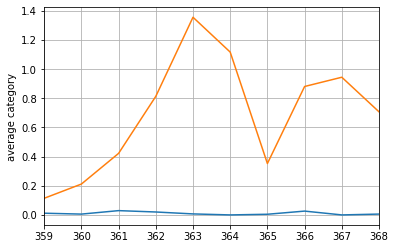

In [538]:
x = np.arange(359, 369, 1)

plt.ylabel('average category')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x, train_data[-10:])
plt.plot(x,actual_predictions)
plt.show()
